In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib

# demos for this notebook
classif_plotter = nonlib.nonlinear_classification_demos
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'
sup_datapath = '../../mlrefined_datasets/superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 
import copy

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# 1.   General pursuit of nonlinearity

Press the button 'Toggle code' below to toggle code on and off for entire this presentation.

In [2]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is eåxported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

- We have seen how we can inject nonlinear functions into supervised/unsupervised

- In general we cannot determine what sort of nonliearity to use for a given dataset

<p>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/nonlinear_combined.png' width="80%" height="80%" alt=""/>
</p>

- So we try various combinations of different generic nonlinear functions, and see which combination works best

- We need to be organized and discipline in this search 

- Simply taking random combinations of various functions does not allow for effecient computation or fine-tuning of nonlinearity

- Conversely if we retrict ourselves to using a set of related functions we can better manage, optimize, and perform the task

#### <span style="color:#a50e3e;">Example 1. </span>  A combination of very different functions is difficult to use

- Suppose we have a regression dataset where we cannot guess (via visualization or intuition) a good nonlinearity 

- We  use a familiar toy data below to simulate our task of searching over various combinations of nonlinear functions to find a fitting nonlinear representation for the data

<IPython.core.display.Javascript object>


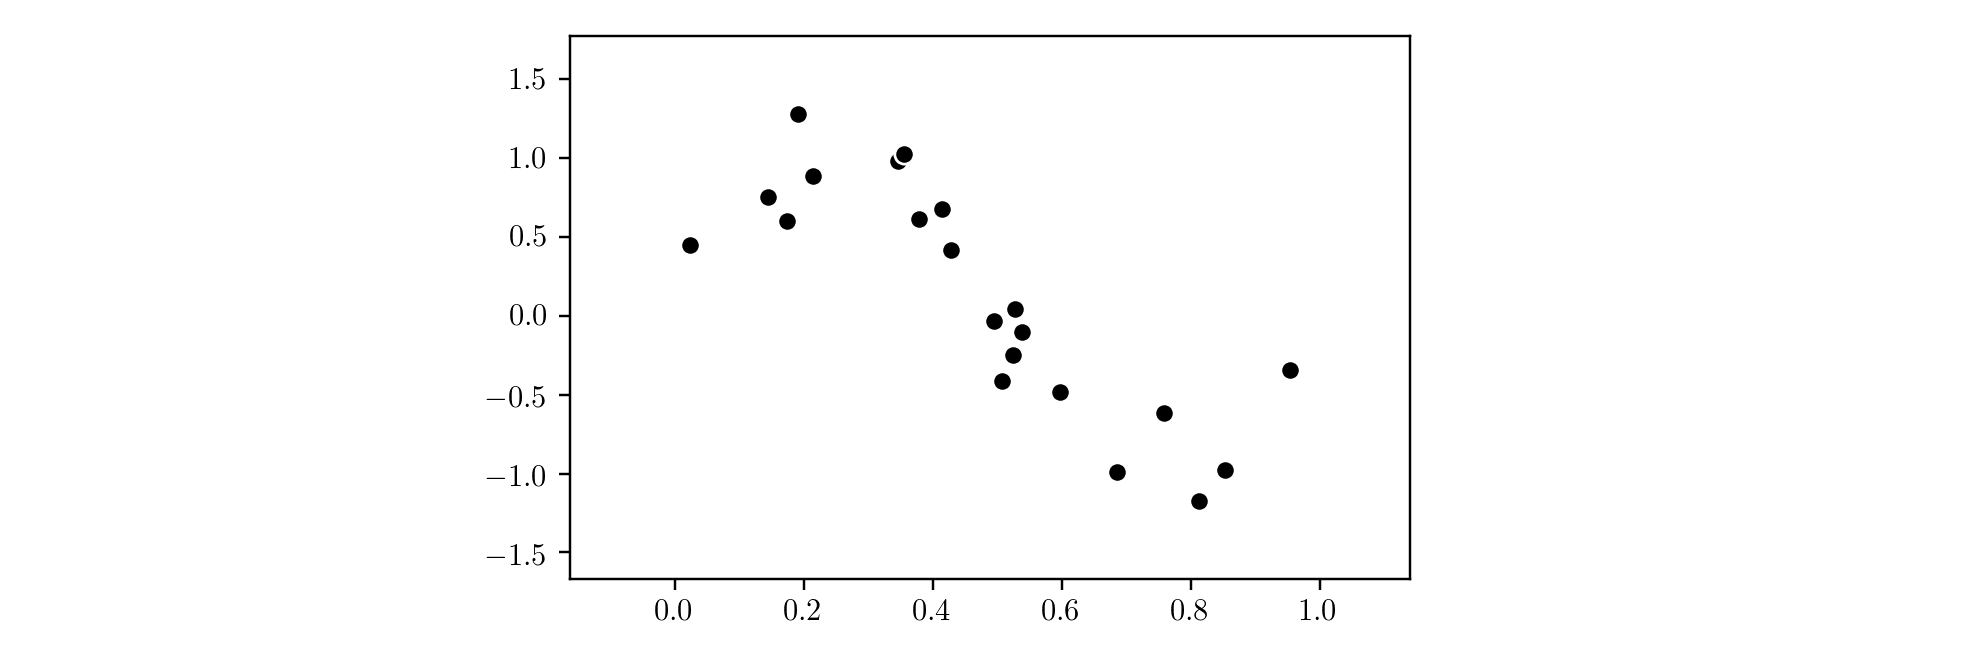

In [2]:
# create instance of linear regression demo, used below and in the next examples
csvname =  datapath + 'noisy_sin_sample.csv'
demo1 = nonlib.demos_part_2.Visualizer(csvname)
demo1.show_pts()

- Say we limit ourselves to trying linear combinations of the following three functions

\begin{equation}
f_1(x) = x ~~~~~~~~~~~~~~ f_2(x) = x^2 ~~~~~~~~~~~~~~ f_3(x) = \text{sinc}(10x)
\end{equation}

<IPython.core.display.Javascript object>


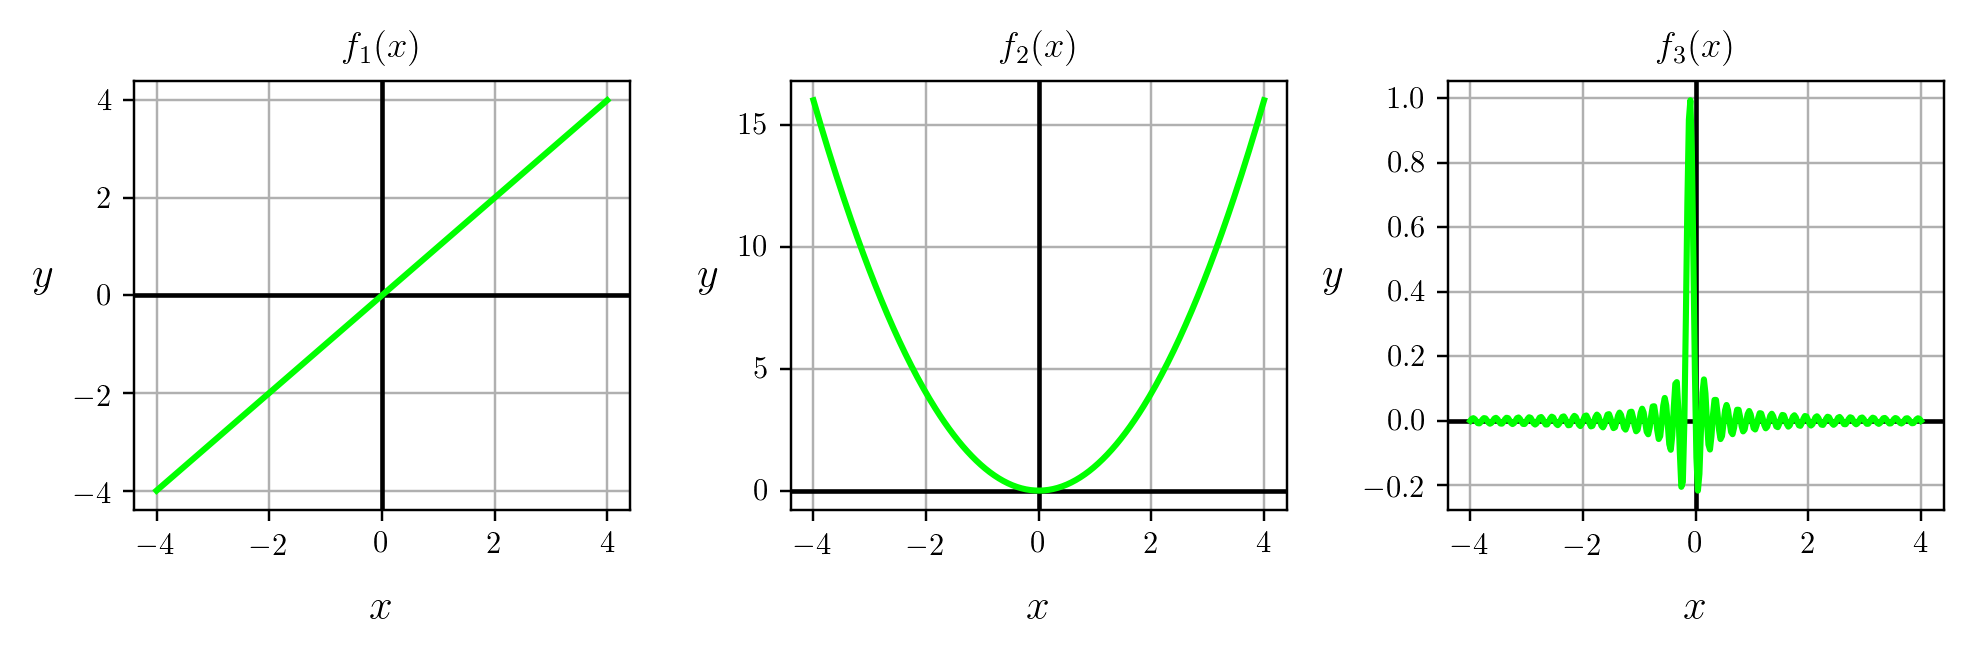

In [3]:
# plot our features
demo1.plot_feats(version = 1)

- We first try 

\begin{equation}
\text{model}(x,\mathbf{w}) = w_0 + w_1f_1(x)
\end{equation}

- then 

\begin{equation}
\text{model}(x,\mathbf{w}) = w_0 + w_1\,f_1(x) + w_2\,f_2(x)
\end{equation}

- and finally 

\begin{equation}
\text{model}(x,\mathbf{w}) = w_0 + w_1\,f_1(x) + w_2\,f_2(x) + w_3\,f_3(x)
\end{equation}

<IPython.core.display.Javascript object>


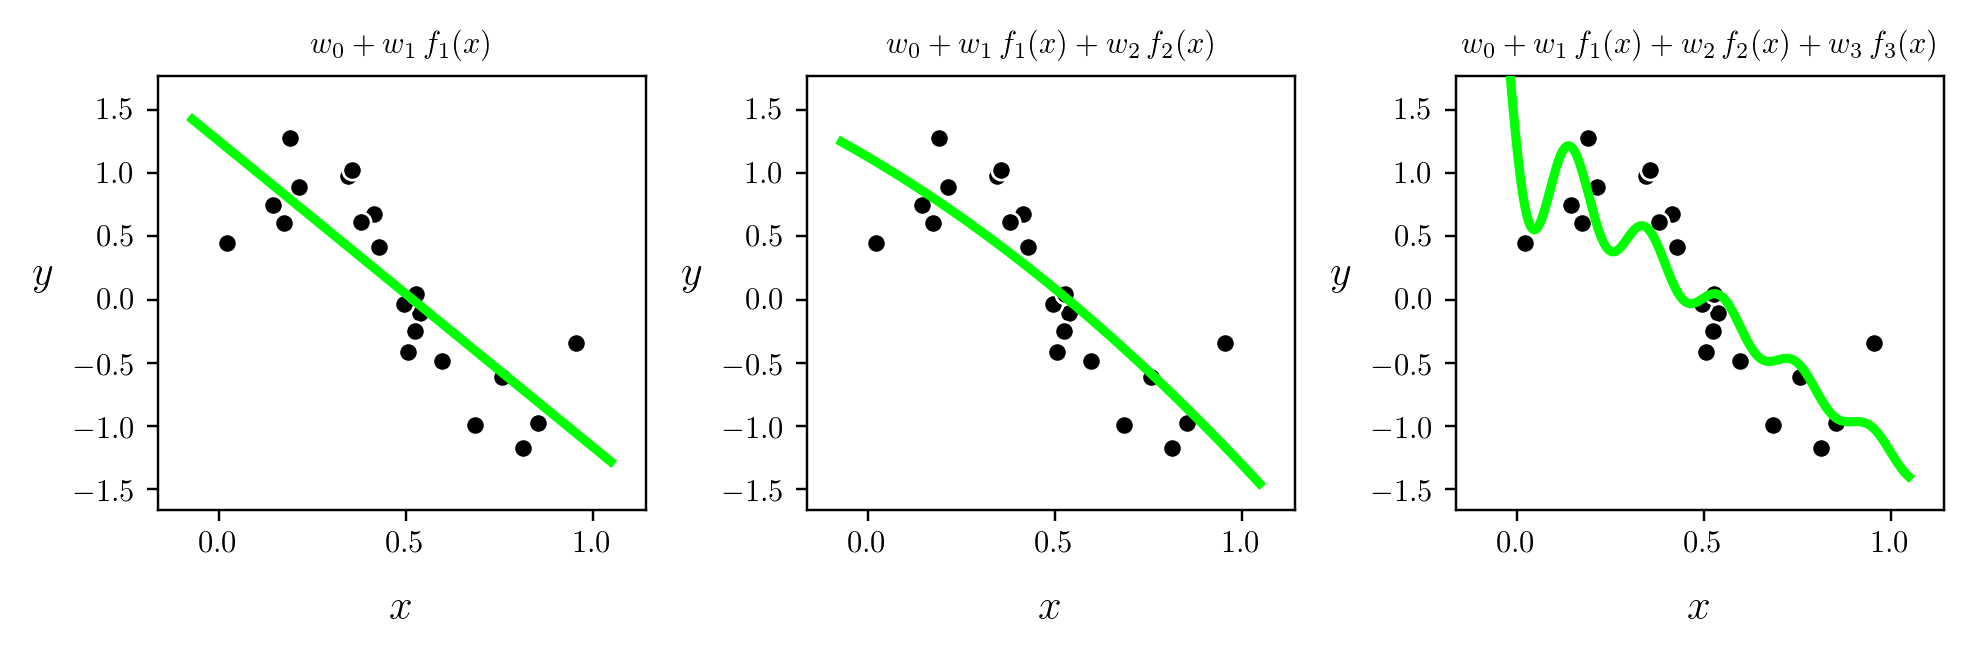

In [4]:
# show first round of fits
demo1.show_fits(version = 1)

- Here the third function is wildly different than the first two, we are unable to control gradual change in nonlinearity

- Now lets try same experiment but with all three functions related --> polynomials

\begin{equation}
f_1(x) = x ~~~~~~~~~~~~~~ f_2(x) = x^2 ~~~~~~~~~~~~~~ f_3(x) = x^3
\end{equation}

<IPython.core.display.Javascript object>


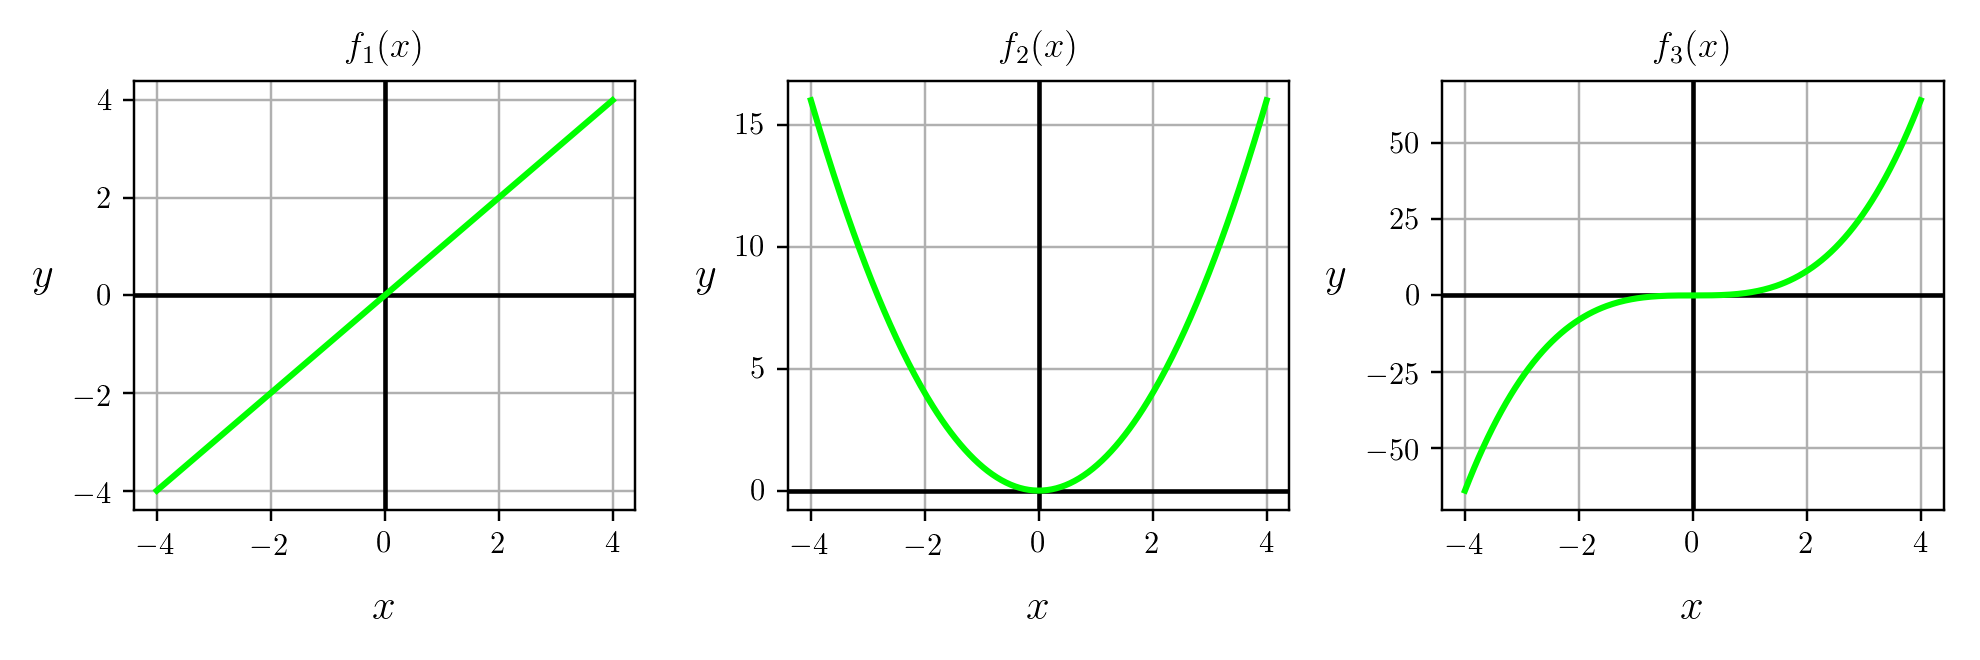

In [5]:
# plot our features
demo1.plot_feats(version = 2)

<IPython.core.display.Javascript object>


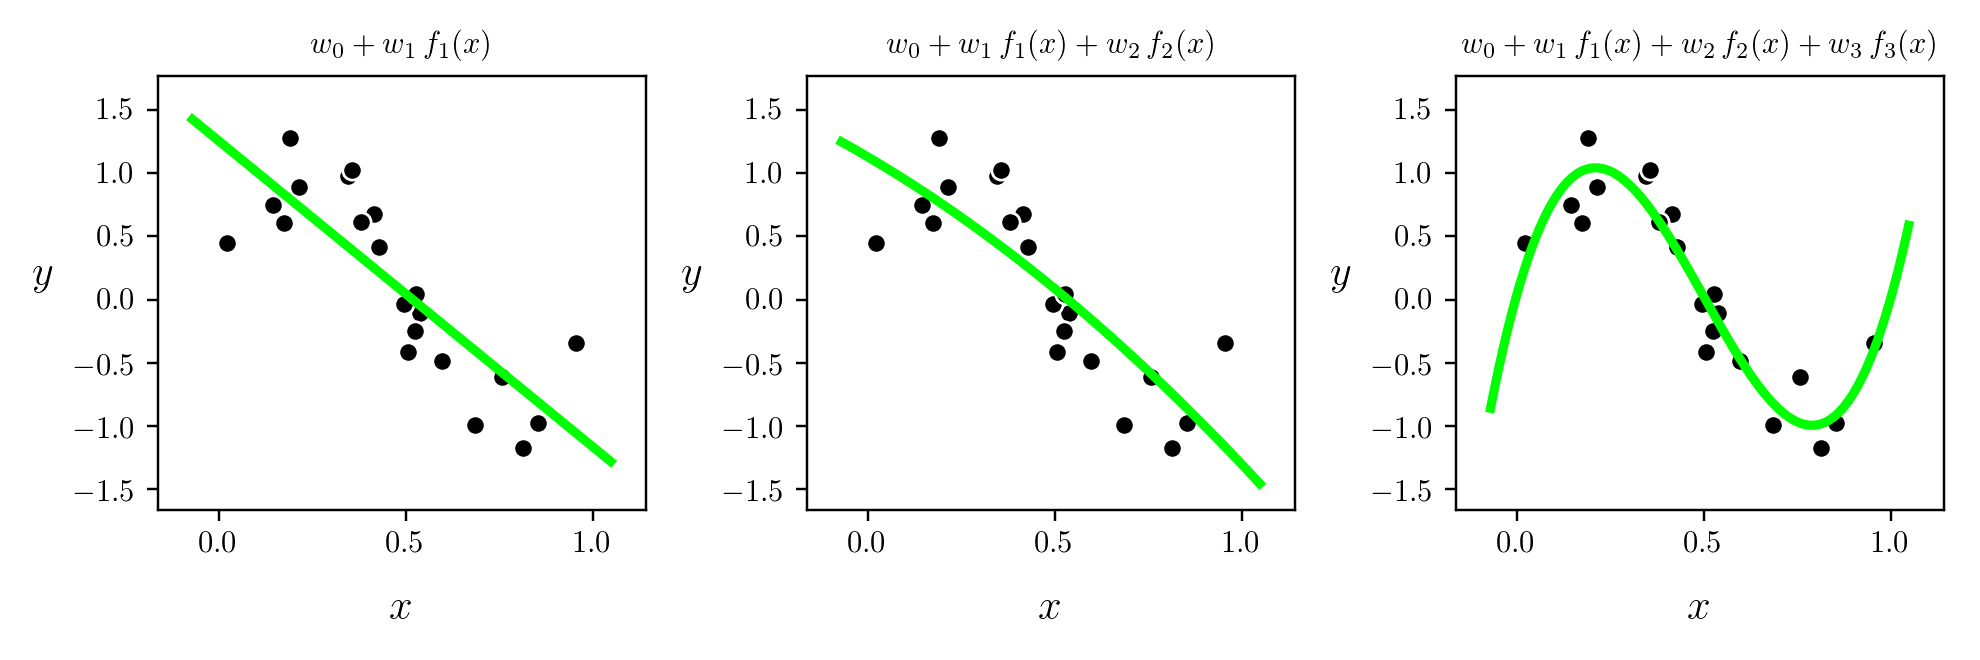

In [6]:
# show first round of fits
demo1.show_fits(version = 2)

- We get a better fit of course, but the change in nonlinearity is more gradual, predictable, and controllable

## The three standard species of functions used for prediction

- We could try adding various random functions for our nonlinear predictor e.g.,

\begin{equation}
\text{model}(x,\mathbf{w}) = w_0 + w_1\text{tanh}\left(w_2 + w_3x\right) + w_4e^{w_5x} + w_6x^{10} + \cdots
\end{equation}

- But to make computationally effecient search methods we need to be more organized than this

- Hence in practice we typically stick to combining functions from a single species - or collection of similar behaving functions

- We use $B$ functions from such a species, making a `model` function of the form

\begin{equation}
\text{model}(x,\mathbf{w}) = w_0 + w_1\,f_1(x) + w_2\,f_2(x) + w_3\,f_3(x) + \cdots + w_B\,f_B(x)
\end{equation}

- By adding together such functions we can create any sort of non-linearity we want, easier to control and optimize

- At a high level: three main types of *species* used in practice - kernels, neural networks, and trees

- Inside each catalog there are many sub-species, here we introduce each species via a simple but common example from each

- We will then circle back to discuss more complex sub-species of neural networks

### 1.  Kernels

- **Basic example:** polynomials 

\begin{equation}
f_1(x) = x^1, ~~ f_2(x) = x^2, ~~ f_3(x) = x^3, ~~ f_4(x) = x^4, ...
\end{equation}

<IPython.core.display.Javascript object>


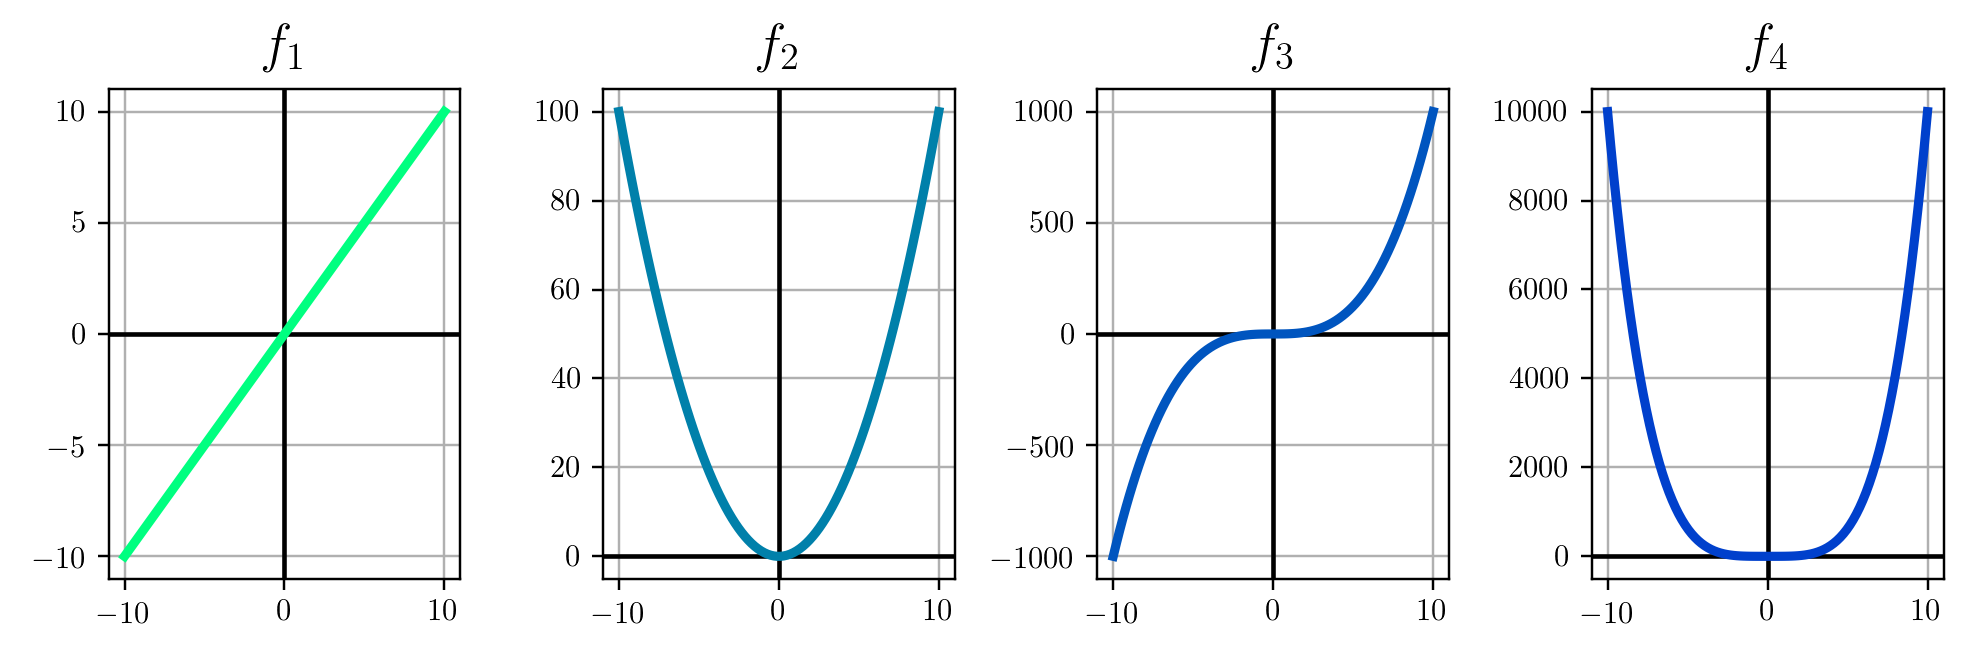

In [8]:
# import Draw_Bases class for visualizing various basis element types
demo = nonlib.DrawBases.Visualizer()

# plot the first 4 elements of the polynomial basis
demo.show_1d_poly()


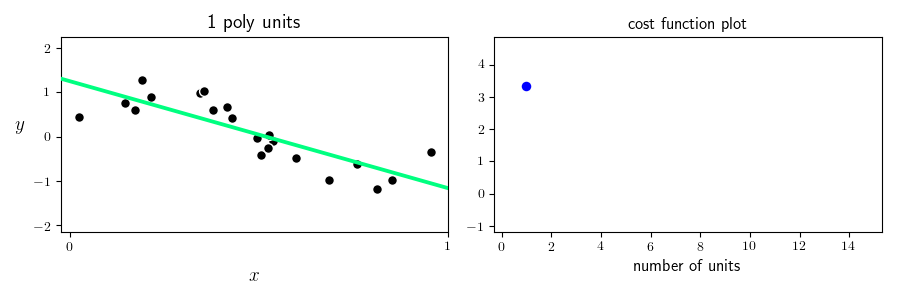
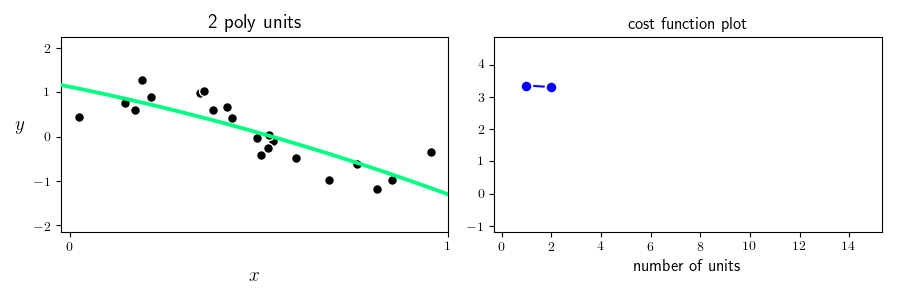
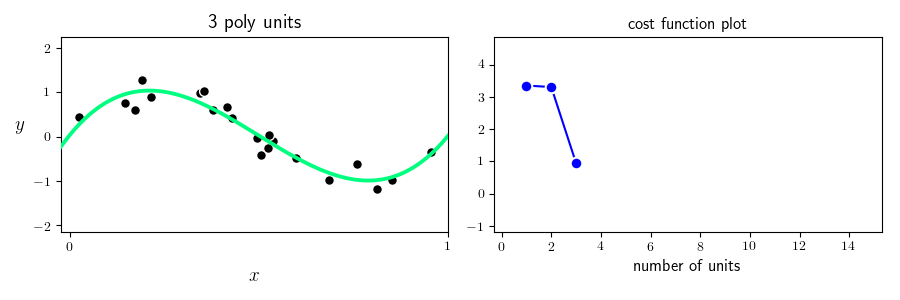
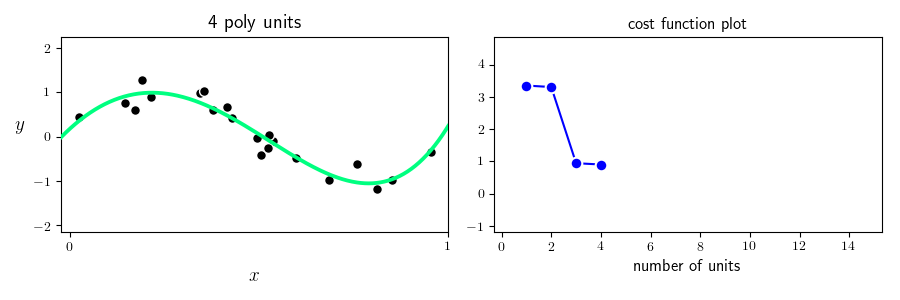
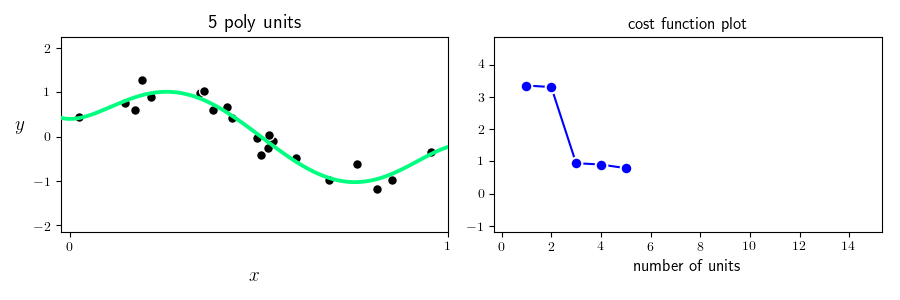
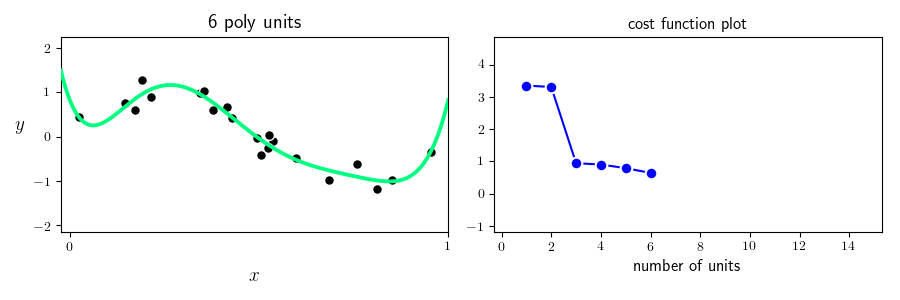
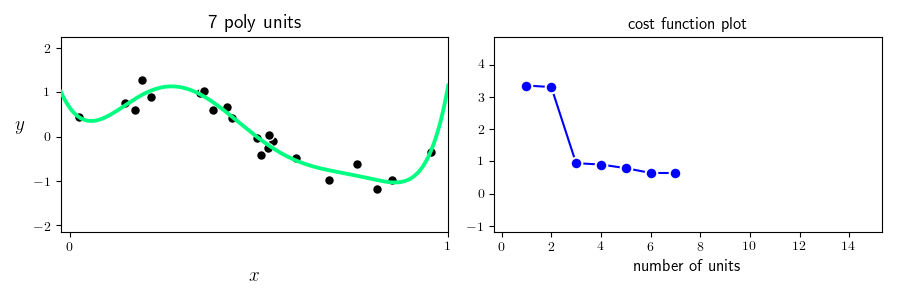
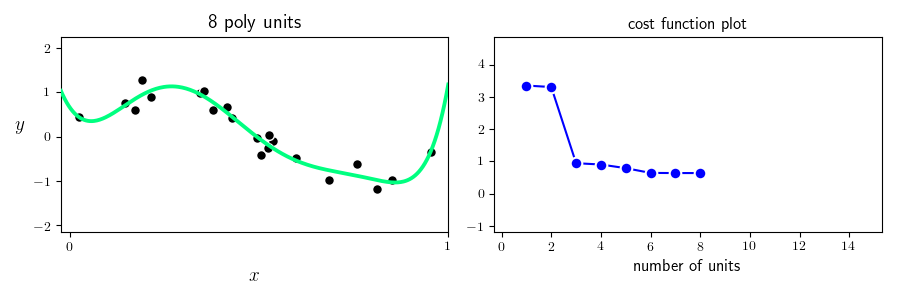
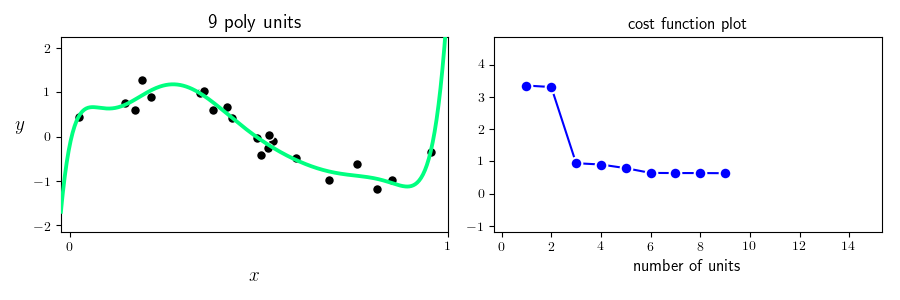
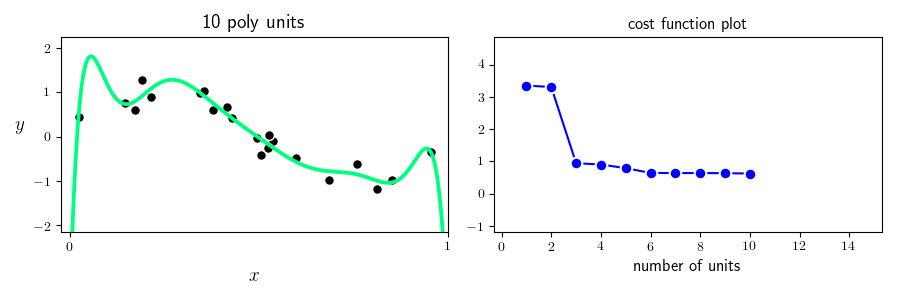
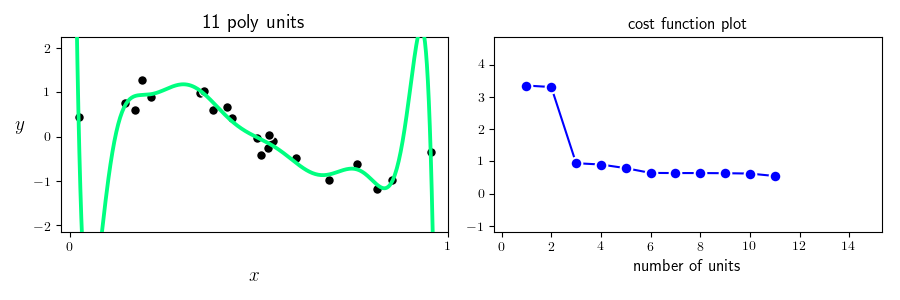
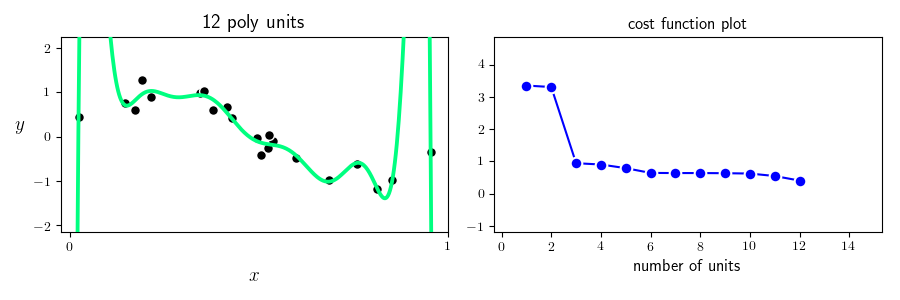
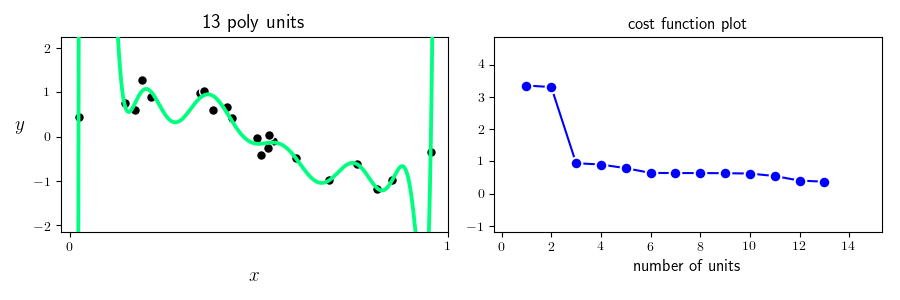
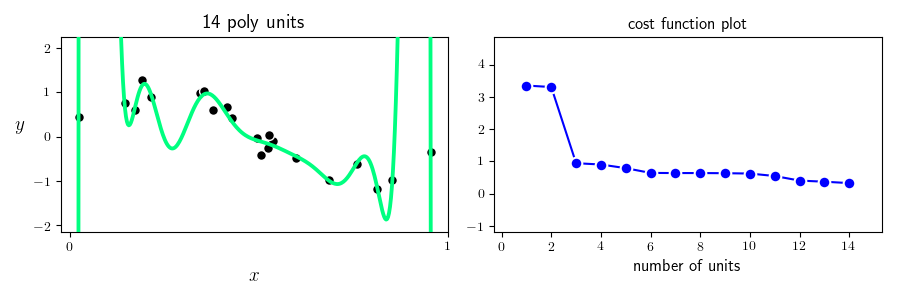

In [11]:
demo = nonlib.regression_basis_single.Visualizer()
csvname =  datapath + 'noisy_sin_sample.csv'
demo.load_data(csvname)
demo.brows_single_fit(basis='poly',num_units = [v for v in range(1,15)])

- For two inputs - $x_1$ and $x_2$ - the catalog of polynomial elements looks like

\begin{equation}
f_1(x_1,x_2) = x_1, ~~ f_2(x_1,x_2) = x_2^2,  ~~ f(x_1,x_2) = x_1x_2^3, ~~ f(x_1,x_2) = x_1^4x_2^6,...
\end{equation}

- In general a degree $D$ element takes the form 

\begin{equation}
f_m(x_1,x_2) = x_1^px_2^q 
\end{equation}

where where $p$ and $q$ are nonnegative integers and $p + q \leq D$


<IPython.core.display.Javascript object>


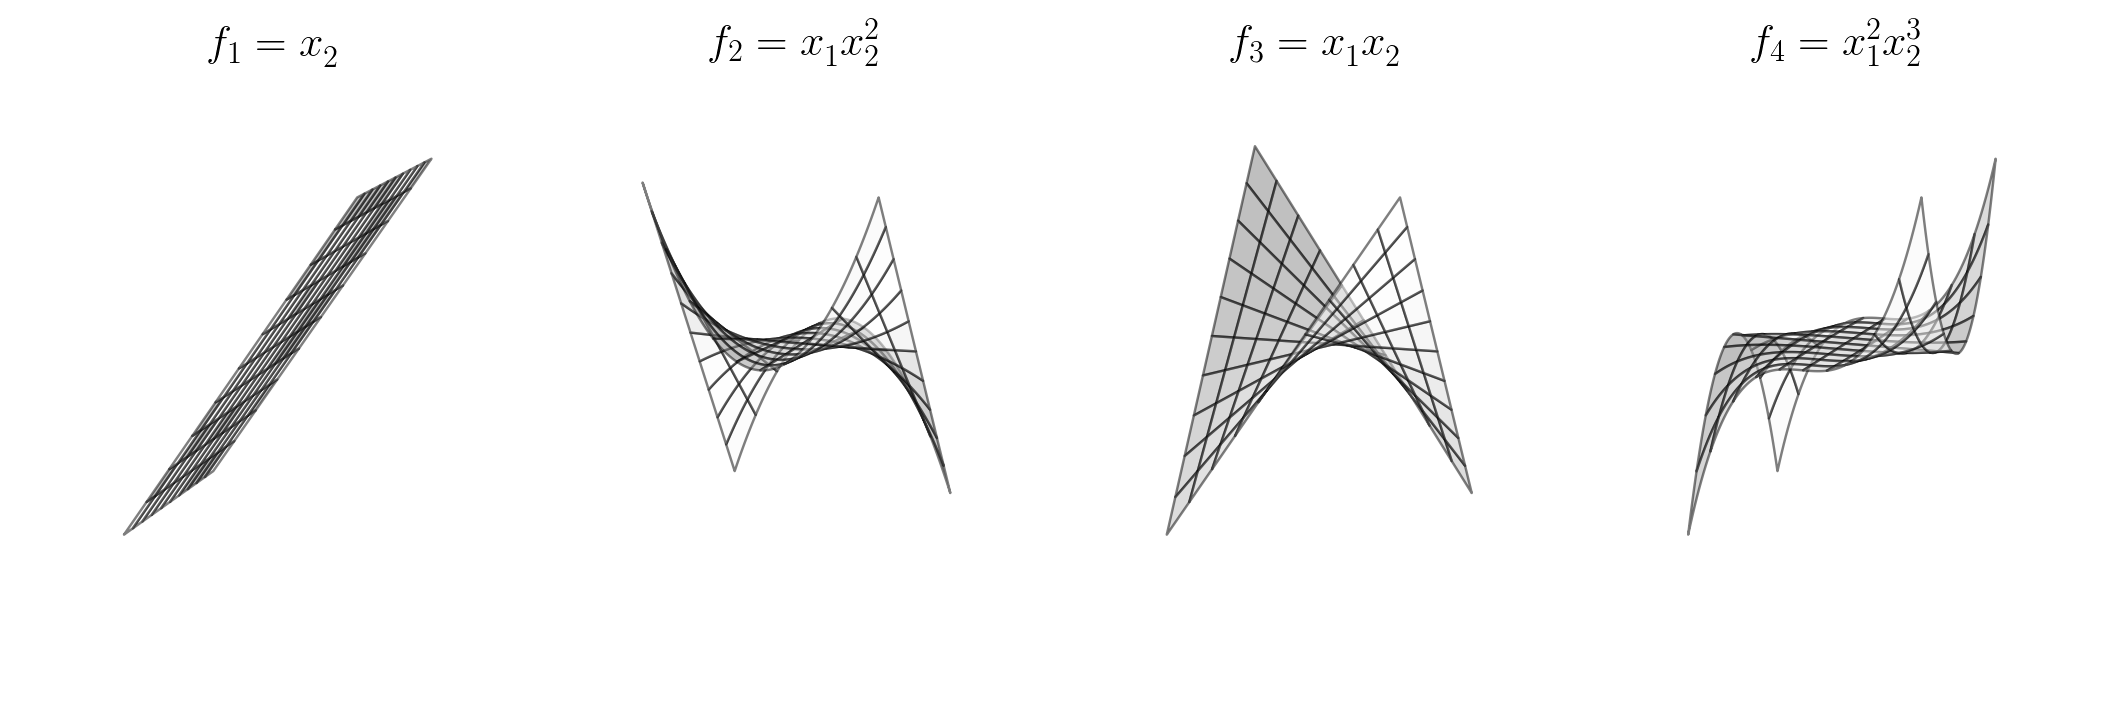

In [9]:
demo.show_2d_poly()


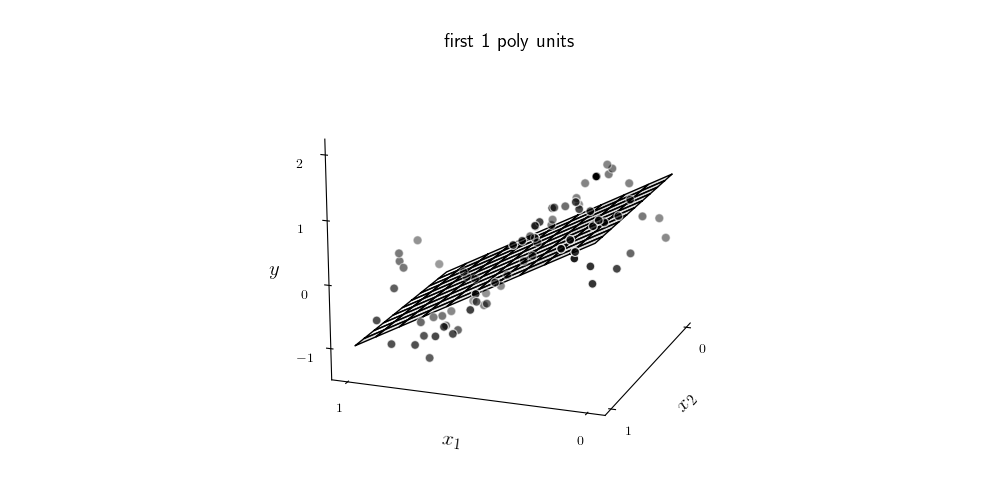
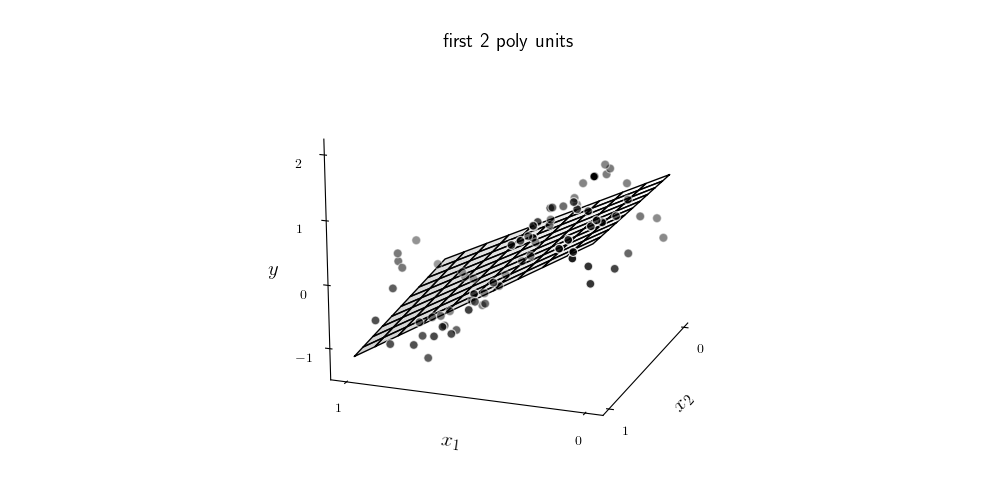
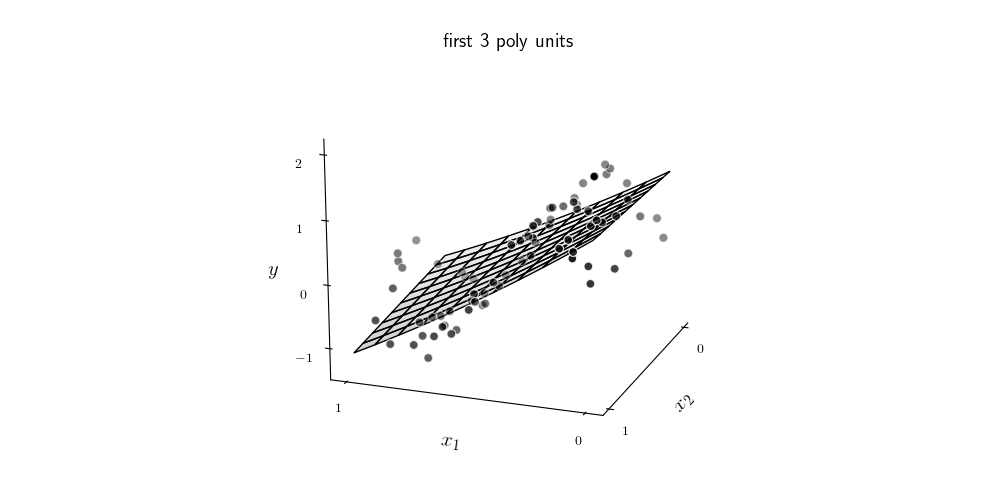
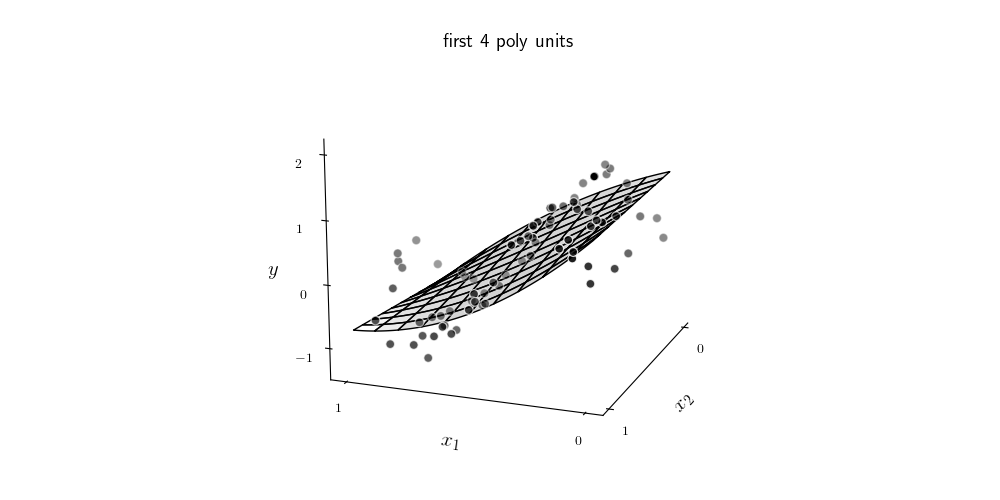
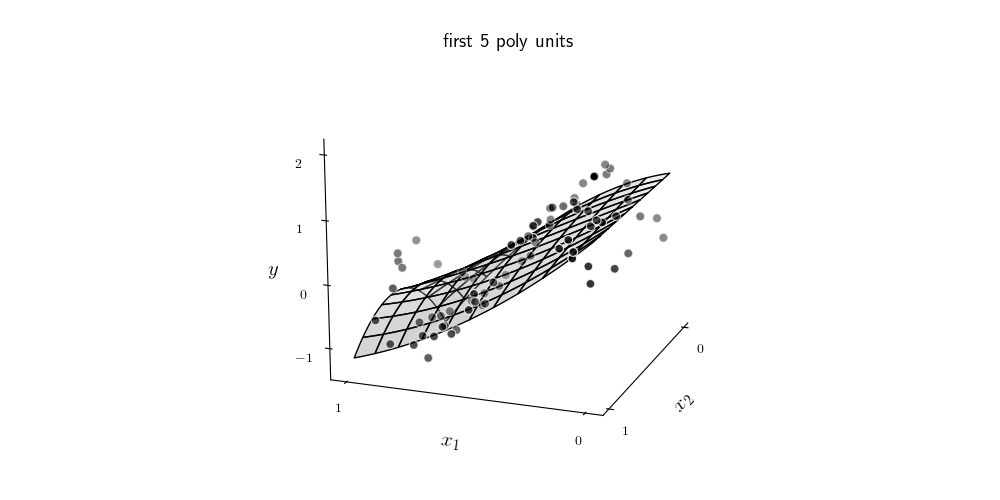
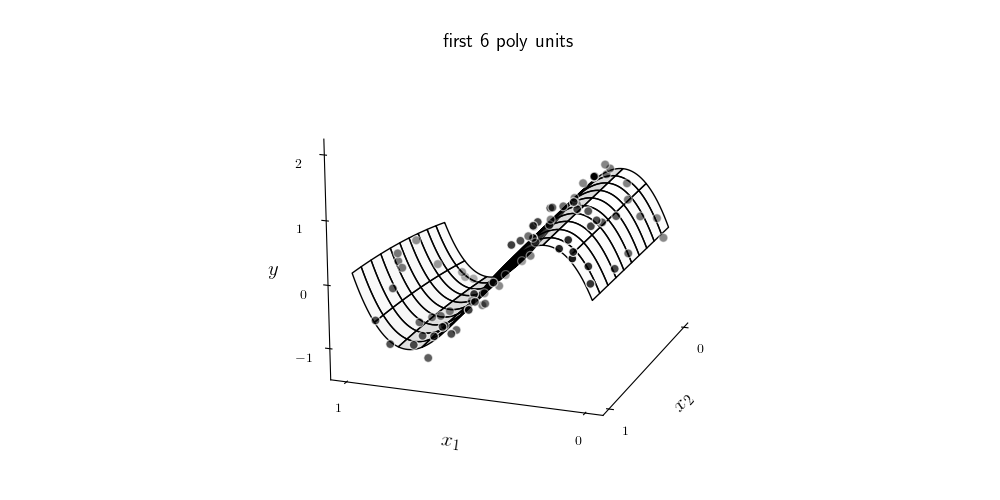
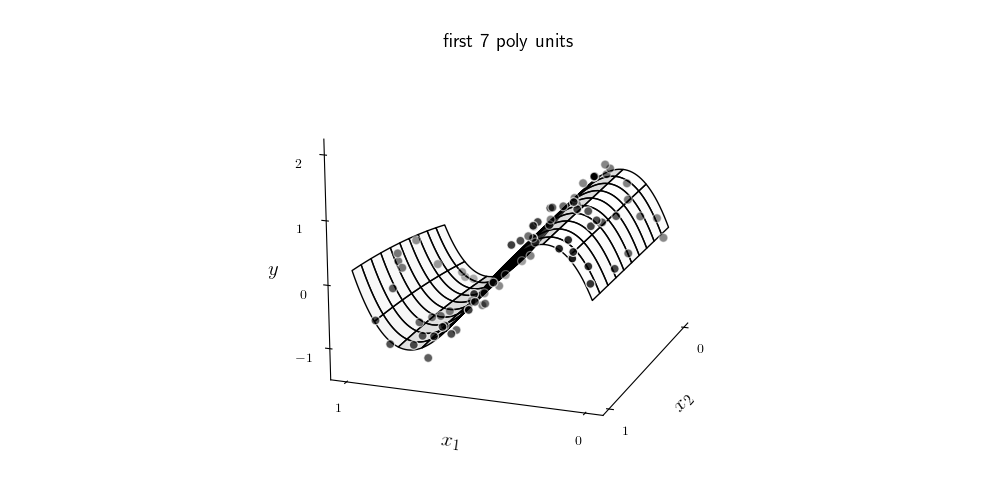
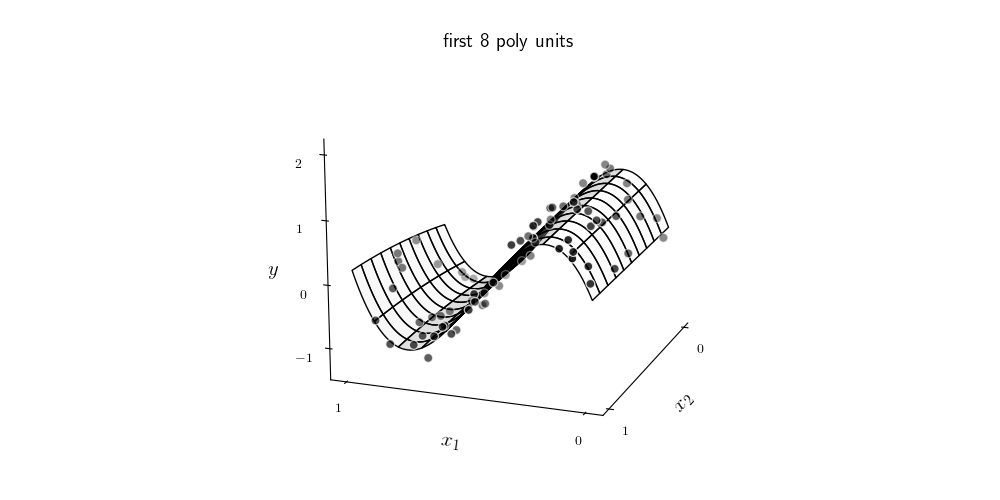
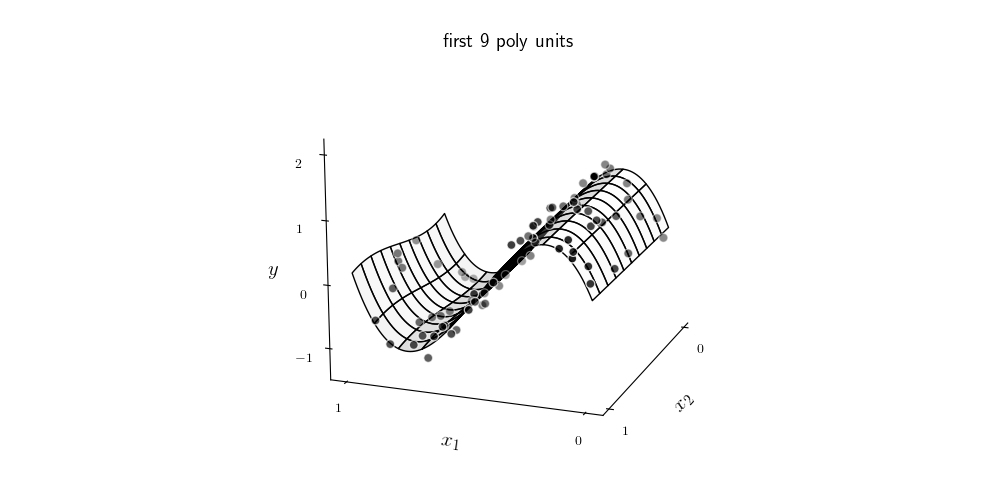

In [5]:
demo = nonlib.regression_basis_comparison_3d.Visualizer()
csvname =  datapath + '3d_noisy_sin_sample.csv'
demo.load_data(csvname)
demo.brows_single_fits(num_elements =  [v for v in range(1,10)] ,view = [20,110],basis = 'poly')

- Can be defined likewise for general $N$ input dimension

- **General attributes of kernel bases:**
    - classic examples also include: Fourier and cosine bases, radial basis functions
    - each element has a *fixed* shape (no internal parameters), elements are *ordered* from simple to complex
    - always leads to *convex* cost functions for regression / classification
    - great for medium sized problems, but many varieties have serious scaling issues when $N$ and $P$ are large 
    - often used with support vector machines (for historical reasons)

# 2.  Neural networks

- **Basic example:** single hidden layer network with *tanh* activation

\begin{equation}
f_1(x) = \text{tanh}\left(w_{1,0} + w_{1,1}x\right), ~~ f_2(x) = \text{tanh}\left(w_{2,0} + w_{2,1}x\right), ~~ f_3(x) = \text{tanh}\left(w_{3,0} + w_{3,1}x\right), ~~ f_4(x) = \text{tanh}\left(w_{4,0} + w_{4,1}x\right), ...
\end{equation}

- Internal parameters make each function *flexible*

- e.g., take $f_1$ with various internal parameter settings

<IPython.core.display.Javascript object>


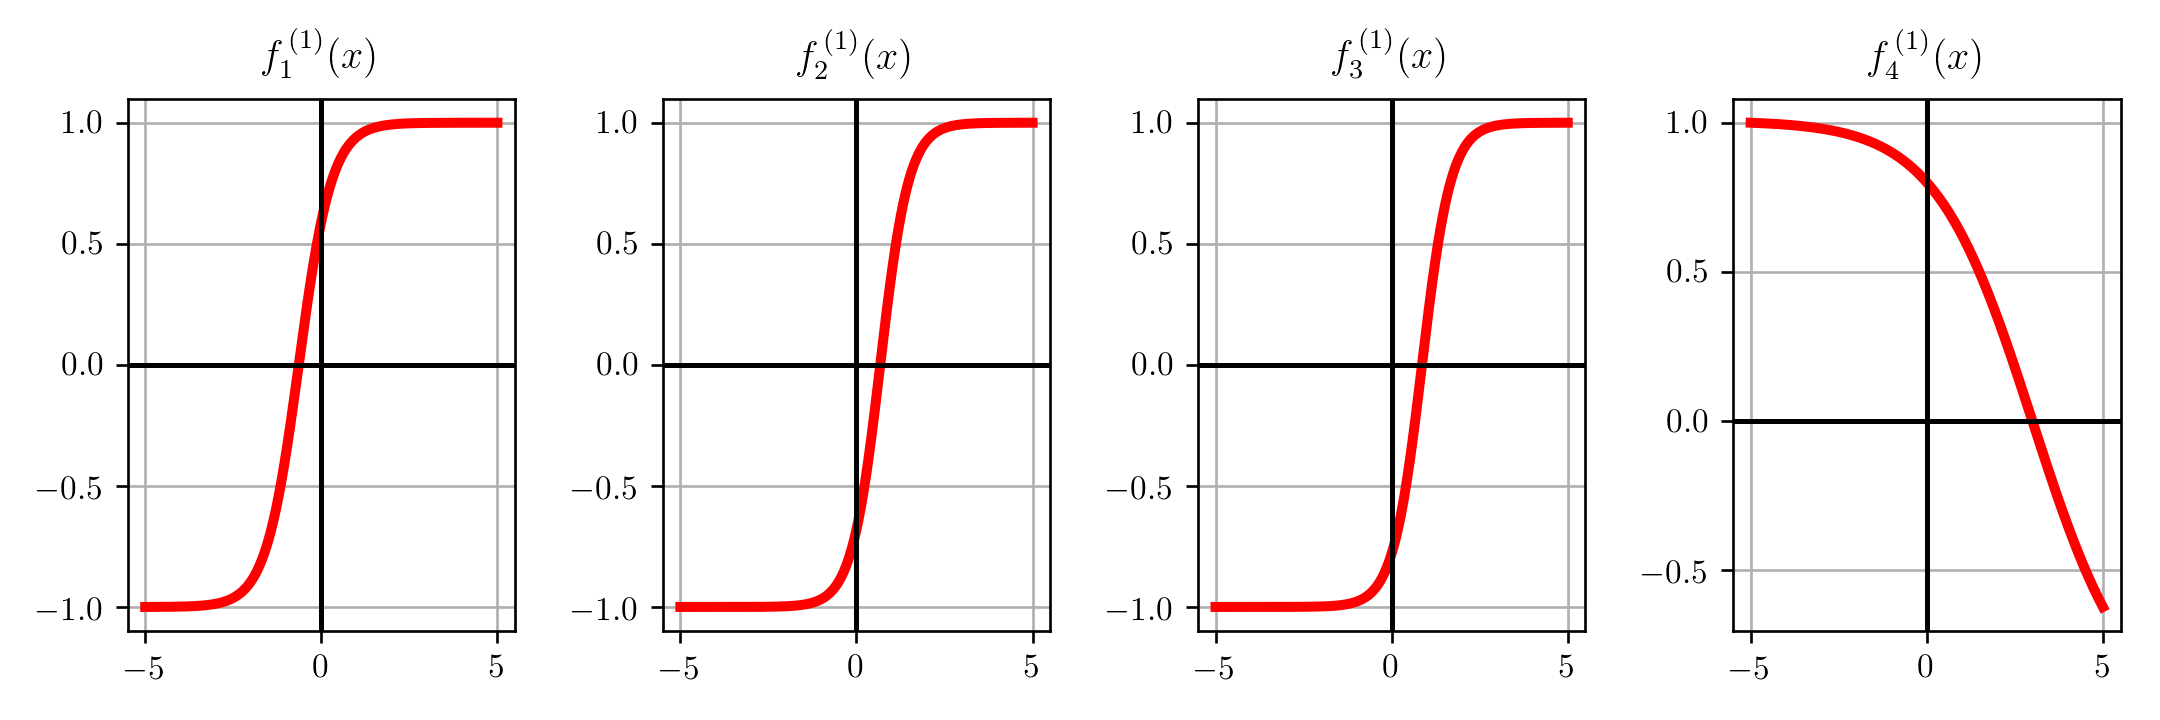

In [12]:
# import Draw_Bases class for visualizing various basis element types
demo = nonlib.DrawBases.Visualizer()

# plot the first 4 elements of the polynomial basis
demo.show_1d_net(num_layers = 1,activation = 'tanh')

- **Basic example:** single hidden layer network with *relu* activation

\begin{equation}
f_1(x) = \text{max}\left(0,w_{1,0} + w_{1,1}x\right), ~~ f_2(x) = \text{max}\left(0,w_{2,0} + w_{2,1}x\right), ~~ f_3(x) = \text{max}\left(0,w_{3,0} + w_{3,1}x\right), ~~ f_4(x) = \text{max}\left(0,w_{4,0} + w_{4,1}x\right), ...
\end{equation}

- Internal parameters make each function *flexible*

<IPython.core.display.Javascript object>


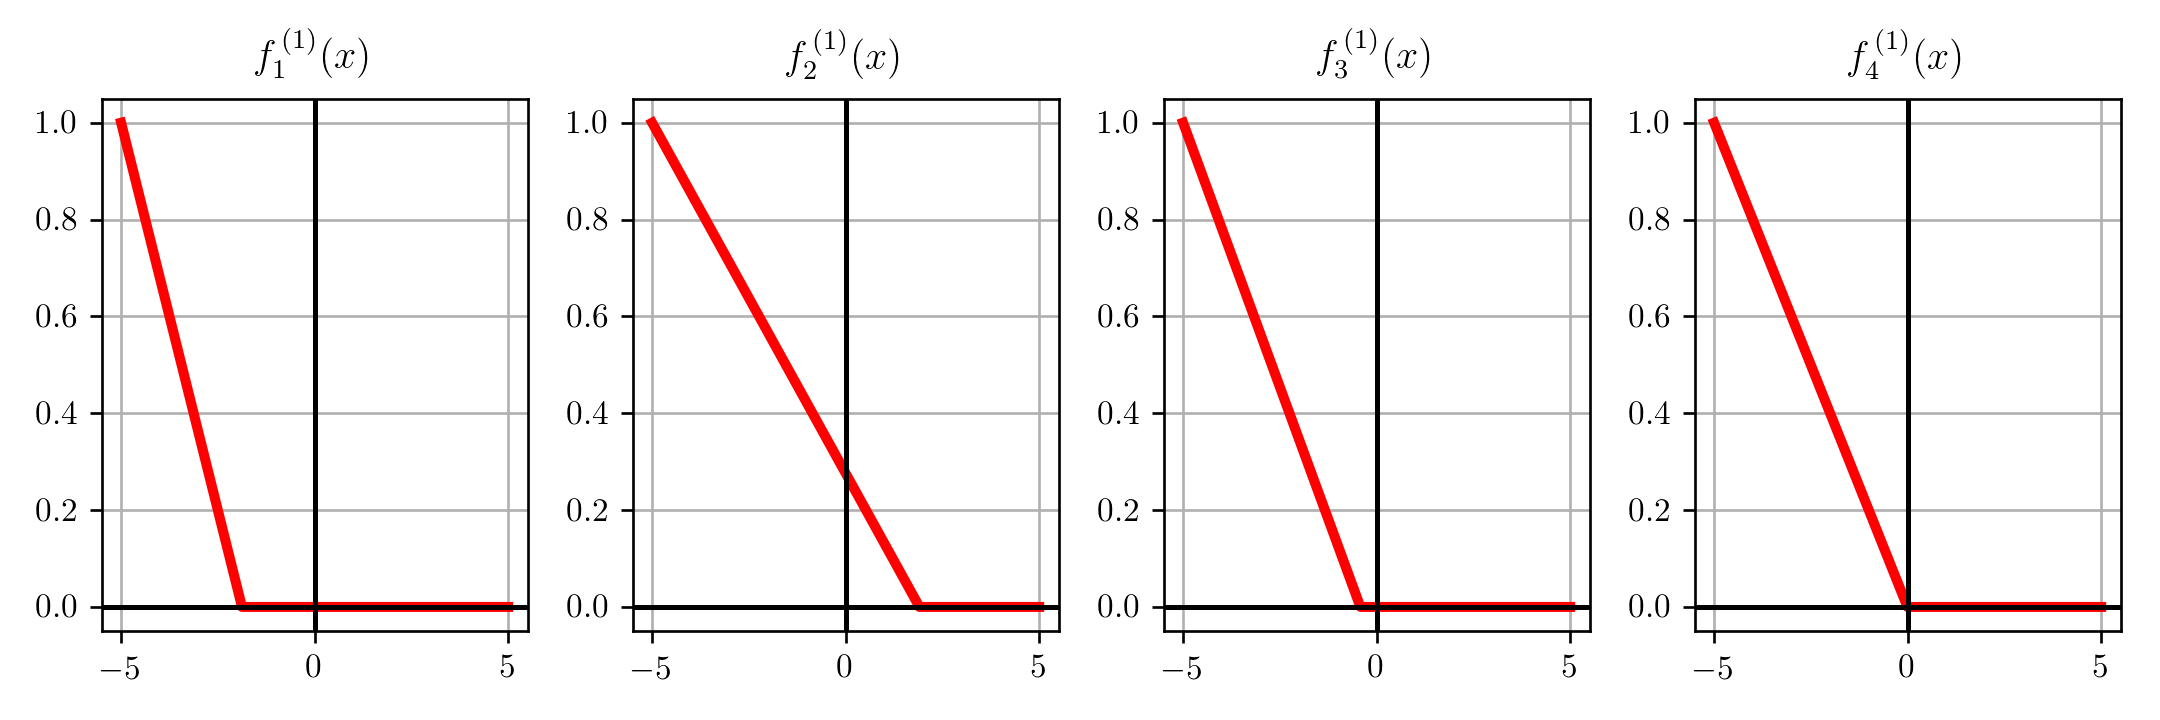

In [13]:
# import Draw_Bases class for visualizing various basis element types
demo = nonlib.DrawBases.Visualizer()

# plot the first 4 elements of the polynomial basis
demo.show_1d_net(num_layers = 1,activation = 'relu')


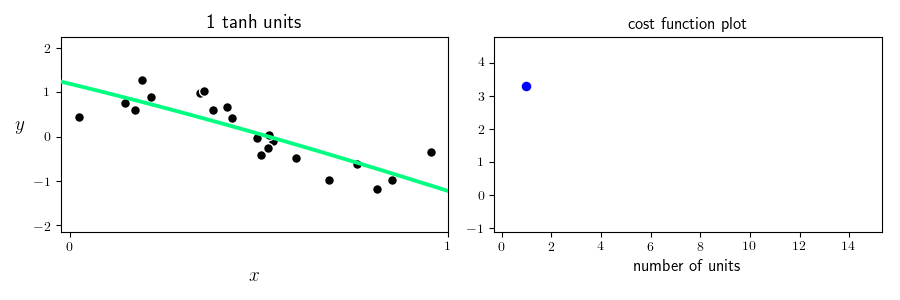
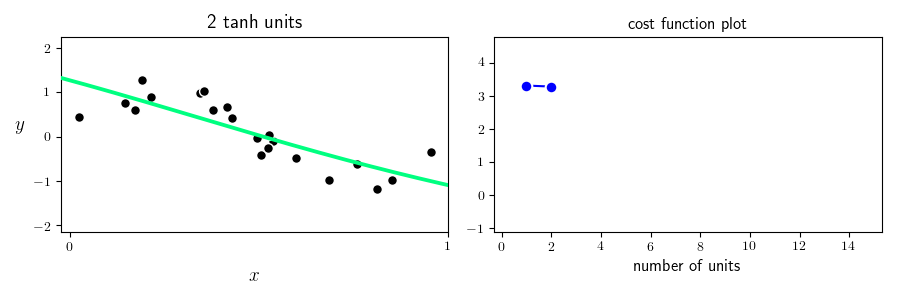
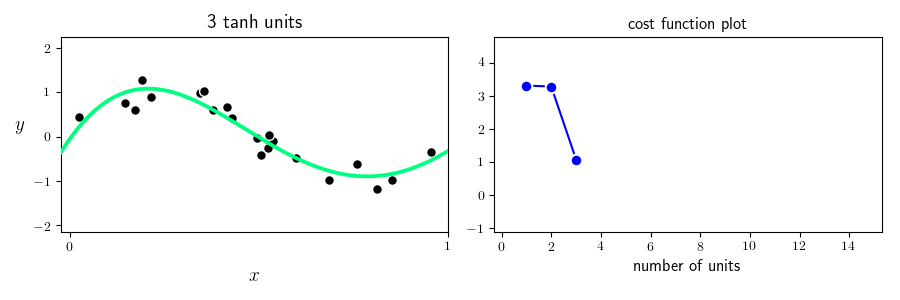
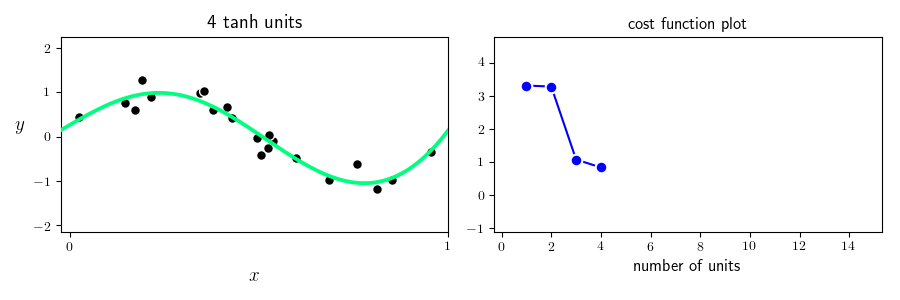
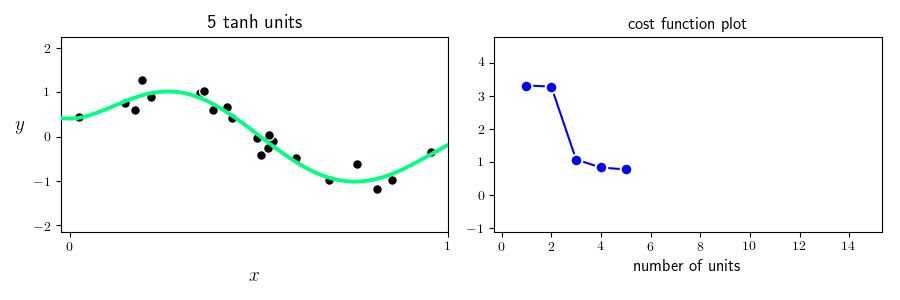
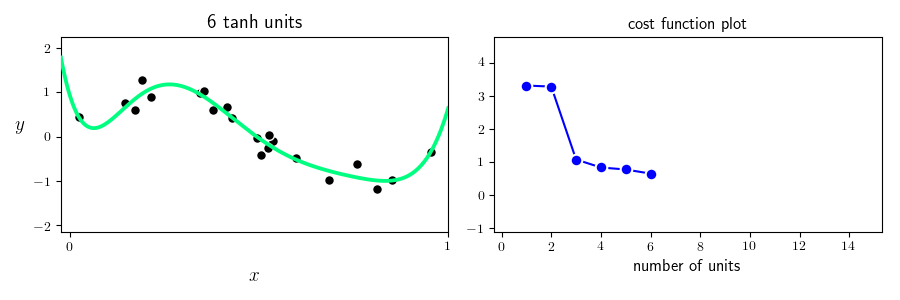
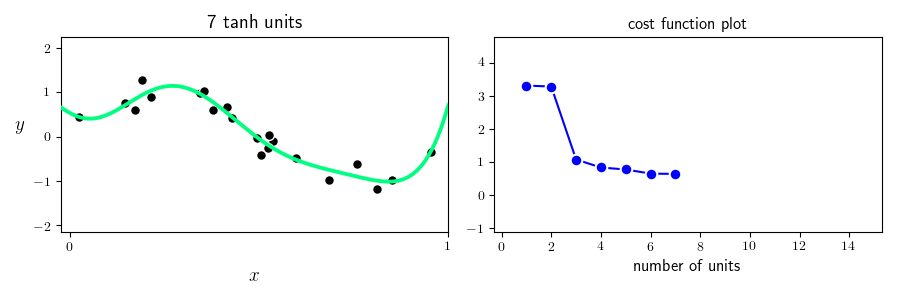
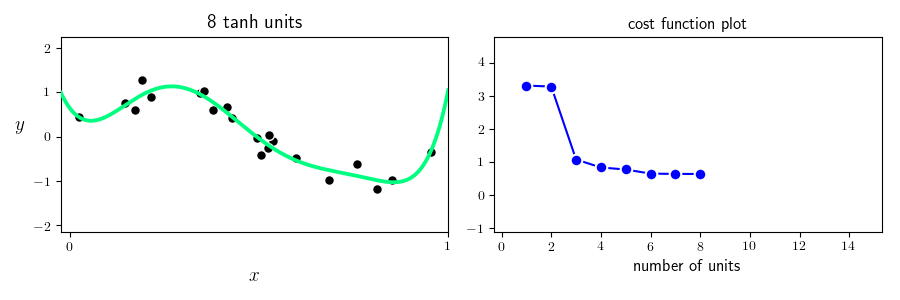
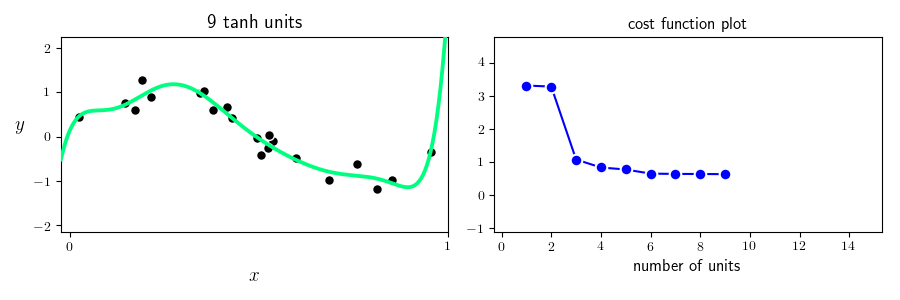
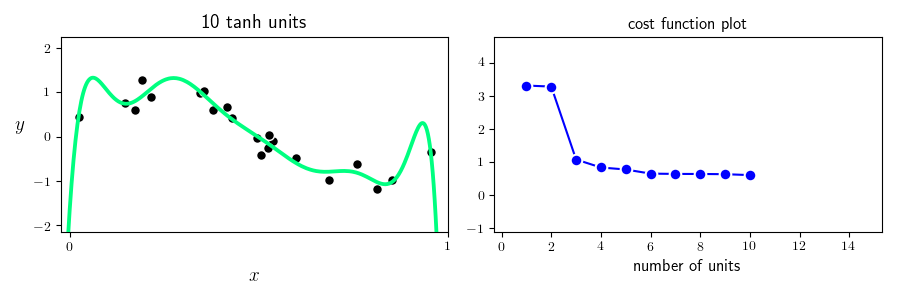
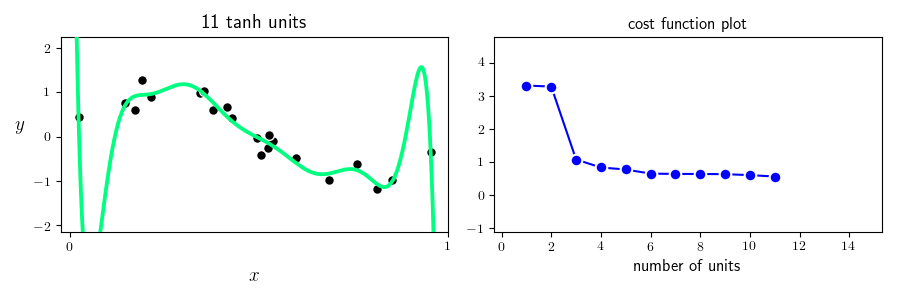
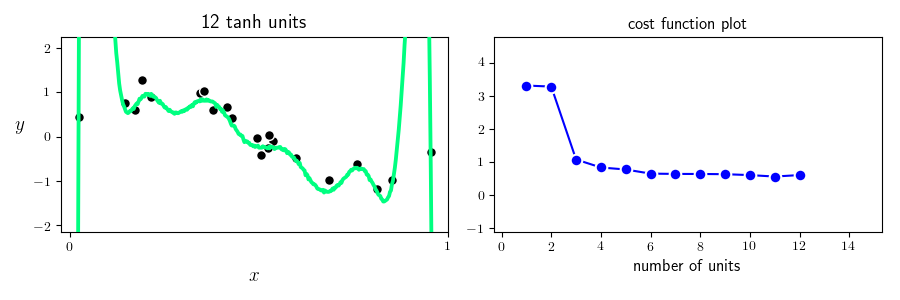
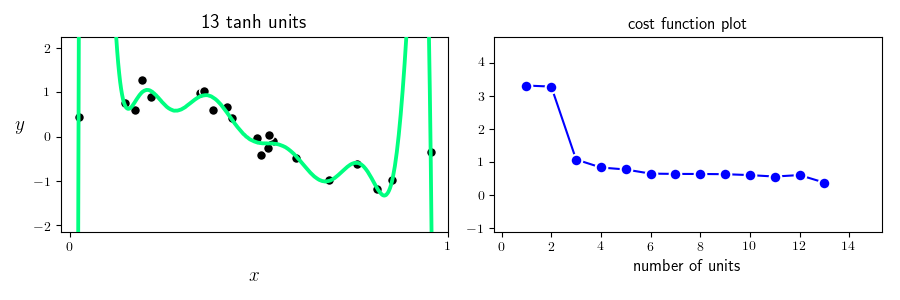
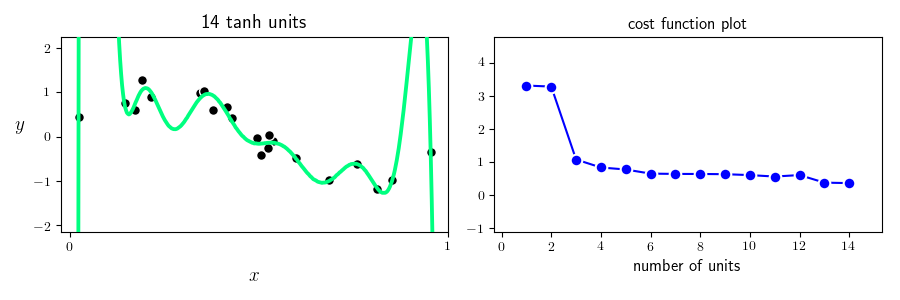

In [15]:
demo = nonlib.regression_basis_single.Visualizer()
csvname = datapath + 'noisy_sin_sample.csv'
demo.load_data(csvname)
demo.brows_single_fit(basis='tanh',num_units = [v for v in range(1,15)])

- For two inputs - $x_1$ and $x_2$ - the catalog of single layer functions with *relu* activation

\begin{equation}
f_1(x) = \text{tanh}\left(w_{1,0} + w_{1,1}x_1 + w_{1,2}x_2\right), ~~ f_2(x) = \text{tanh}\left(w_{2,0} + w_{2,1}x_1 + w_{2,2}x_2\right) ...
\end{equation}

- or likewise

\begin{equation}
f_1(x) = \text{max}\left(0,w_{1,0} + w_{1,1}x_1 + w_{1,2}x_2\right), ~~ f_2(x) = \text{max}\left(0,w_{2,0} + w_{2,1}x_1 + w_{2,2}x_2\right) ...
\end{equation}


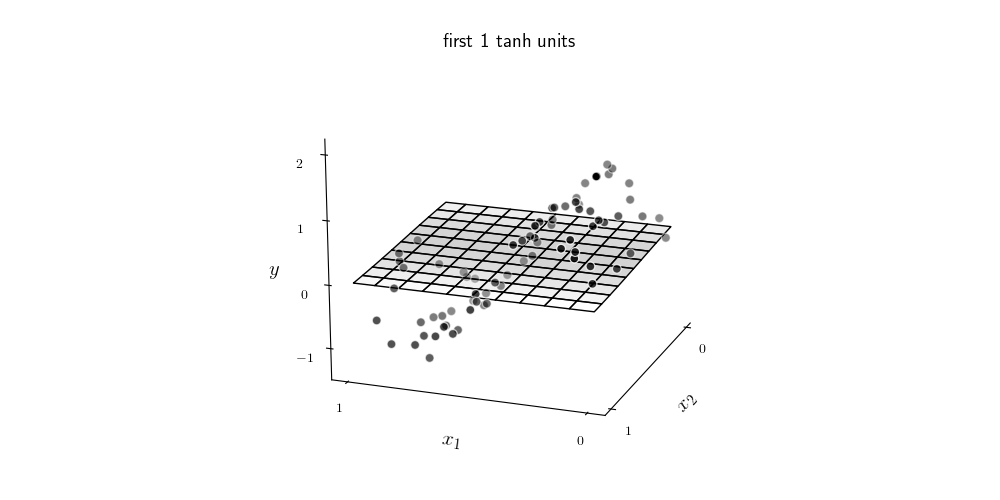
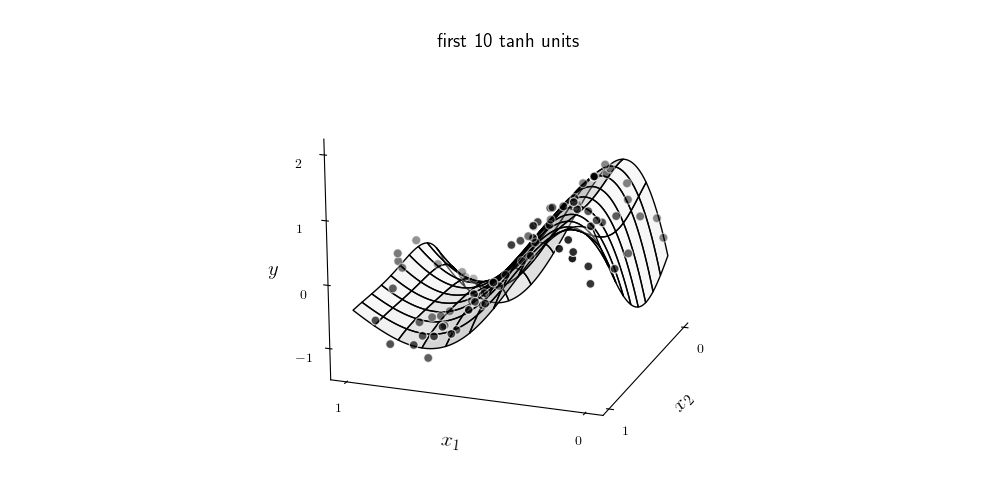
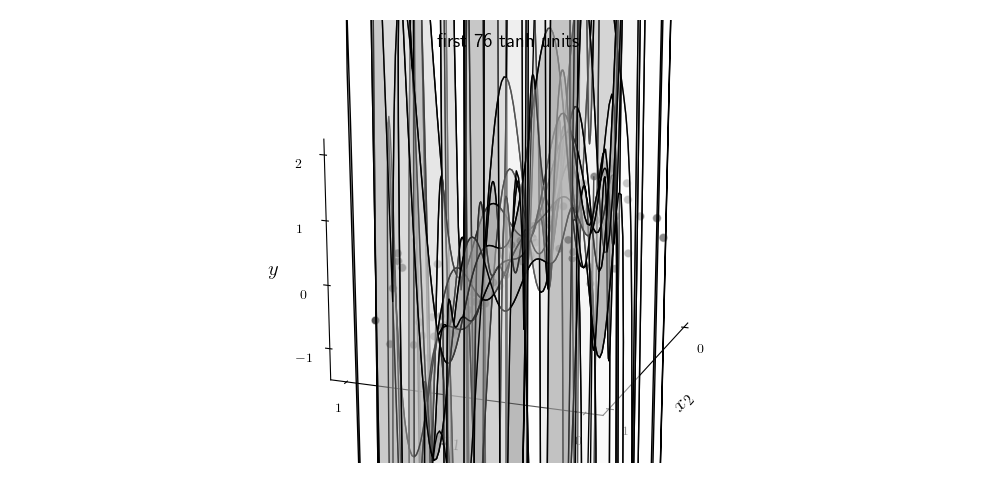

In [19]:
demo = nonlib.regression_basis_comparison_3d.Visualizer()
csvname = datapath + '3d_noisy_sin_sample.csv'
demo.load_data(csvname)
demo.brows_single_fits(num_units =  [v for v in range(1,12)] ,view = [20,110],basis = 'net')

- Generalizes to $N$ dimensional input

- **General attributes of neural network bases:**
    - elements are of the same general type, each has *adjustable* shape (with internal parameters)
    - leads to *non-convex* cost functions for regression / classification
    - especially great for large high dimensional input problems 
    - often used with logistic regression (for historical reasons)

# 3.  Trees

- **Basic example:** depth-1 tree, also known as a *stump*

\begin{equation}
f_1(x) = \begin{cases} x < V_1 \,\,\,\,\, a_1 \\ x \geq  V_1 \,\,\,\,\, b_1   \end{cases}  ~~~~~~~~
f_2(x) = \begin{cases} x < V_2 \,\,\,\,\, a_2 \\ x \geq  V_2 \,\,\,\,\, b_2  \end{cases} ~~ \cdots
\end{equation}

- Vocab: for $f_j$ the value $V_j$ called a *split point*, $a_j$ and $b_j$ called *levels* 

<IPython.core.display.Javascript object>


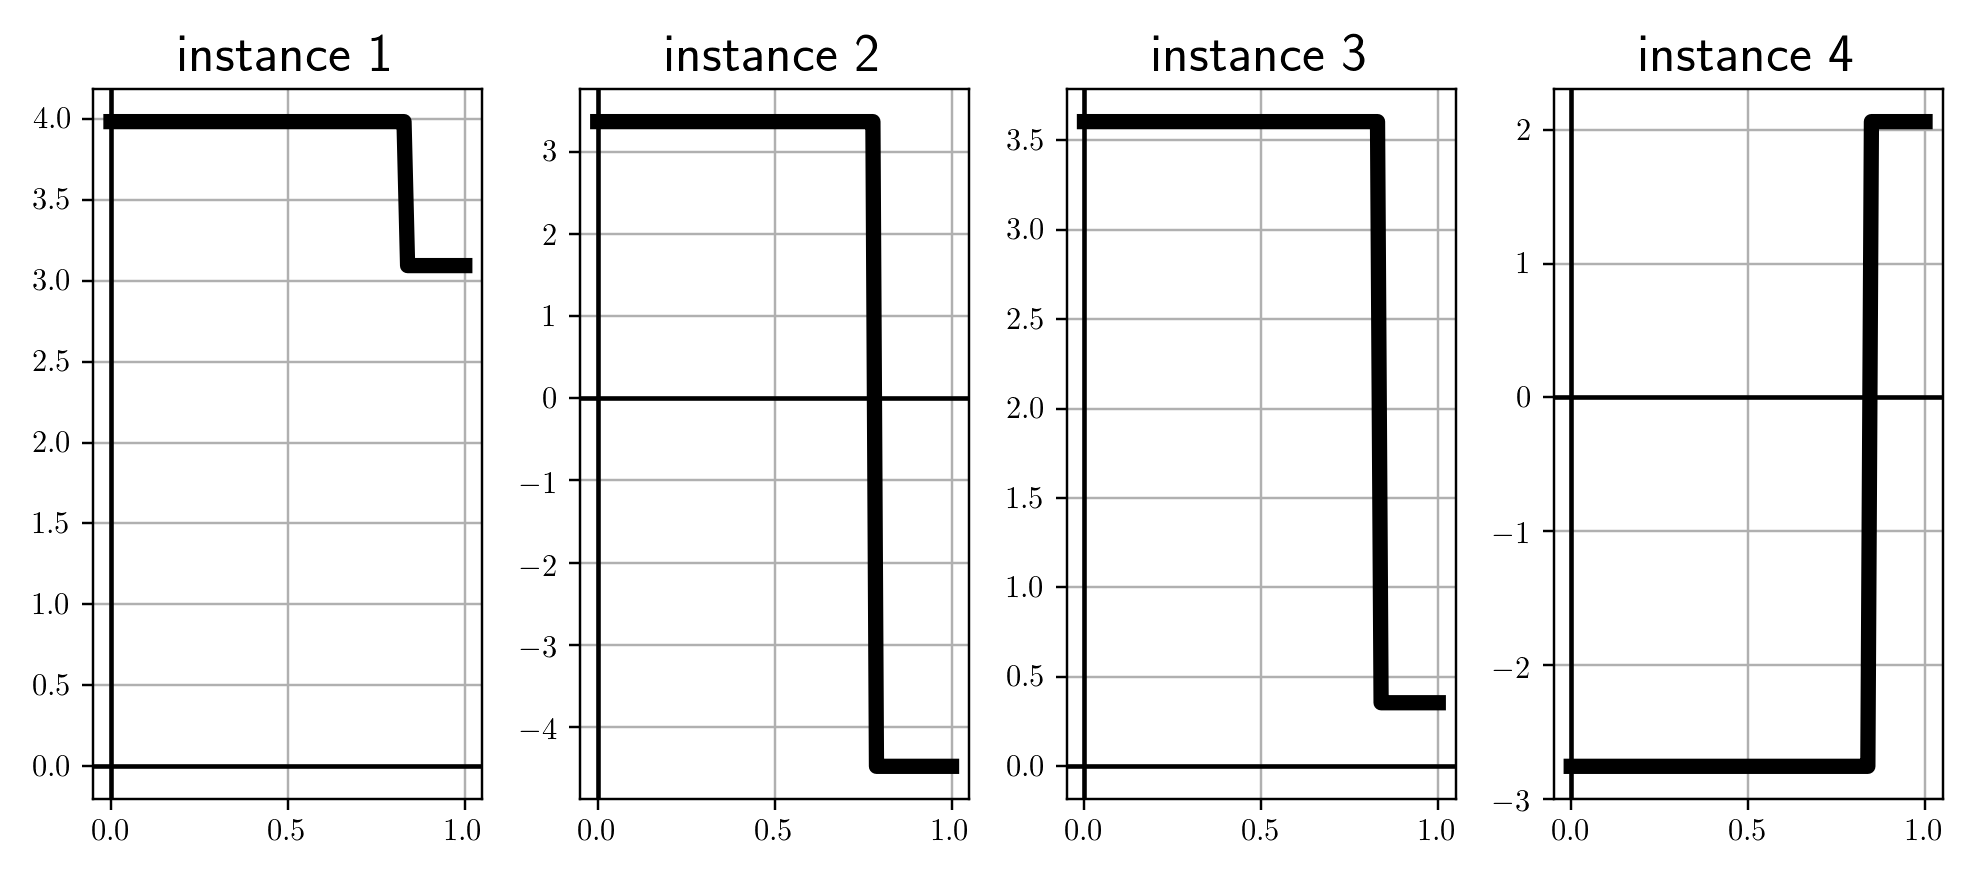

In [10]:
# import Draw_Bases class for visualizing various basis element types
demo = nonlib.DrawBases.Visualizer()

# plot the first 4 elements of the polynomial basis
demo.show_1d_tree(depth = 1)

- Split points and levels set directly using data, not internal parameters

- e.g., a split point placed between two inputs, left / right level set to average of output to the left / right


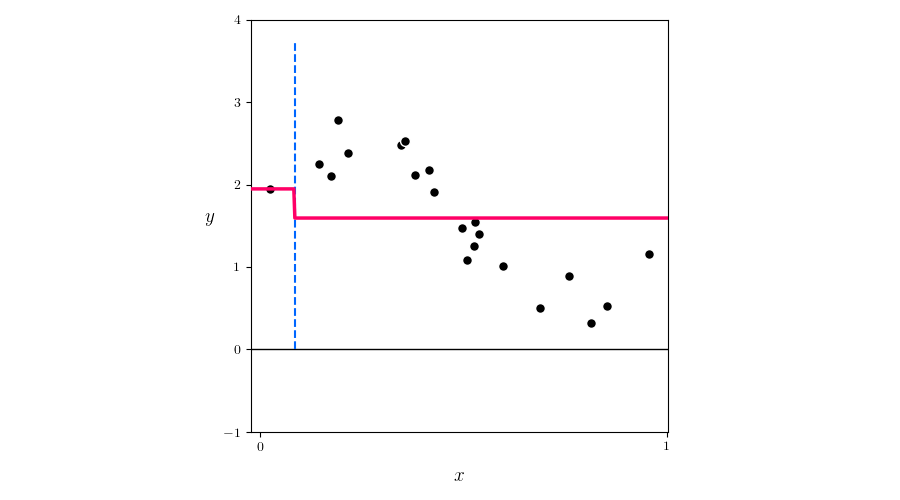
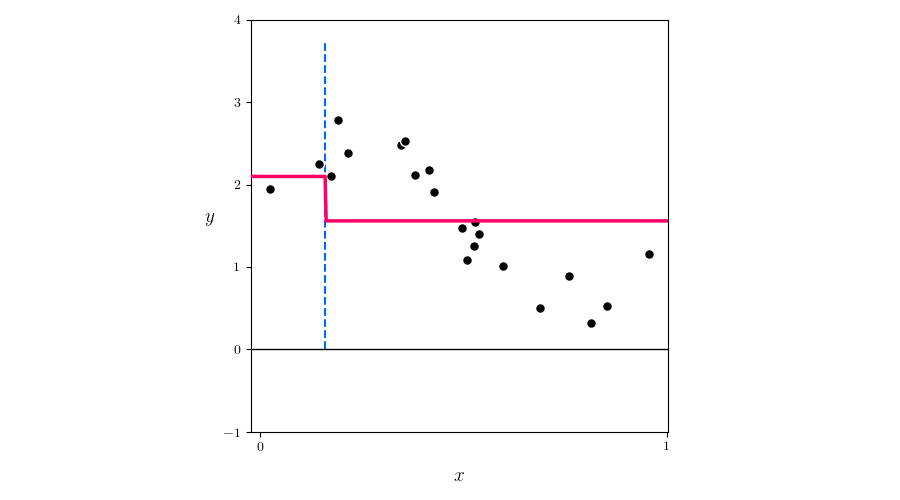
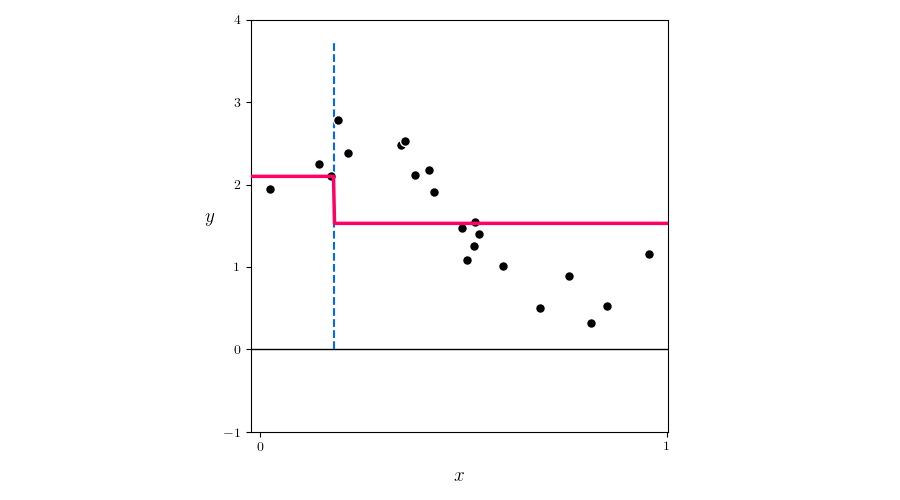
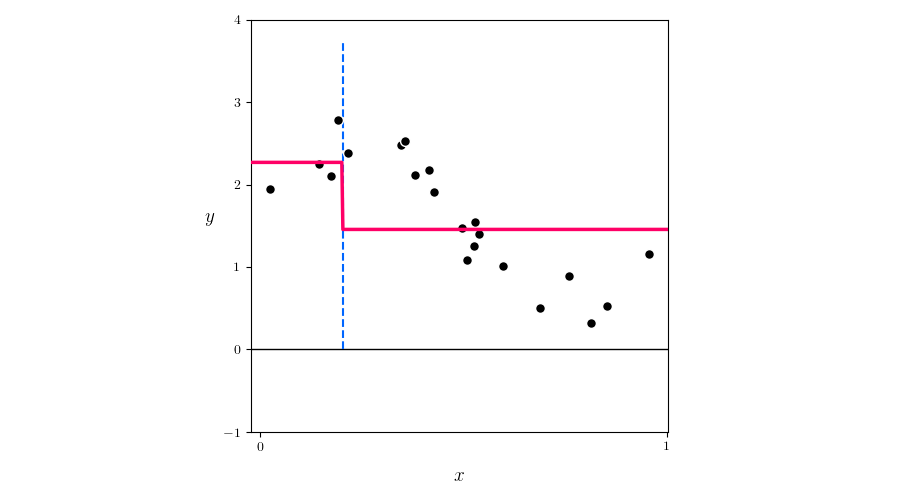
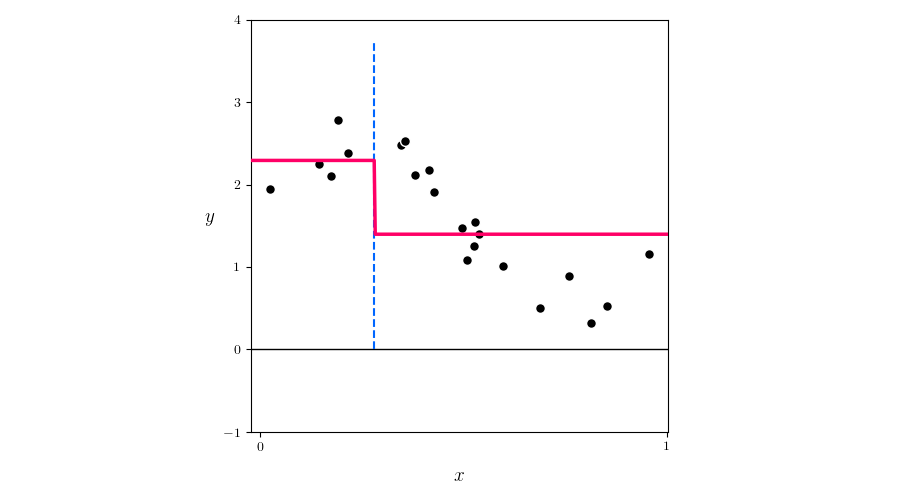
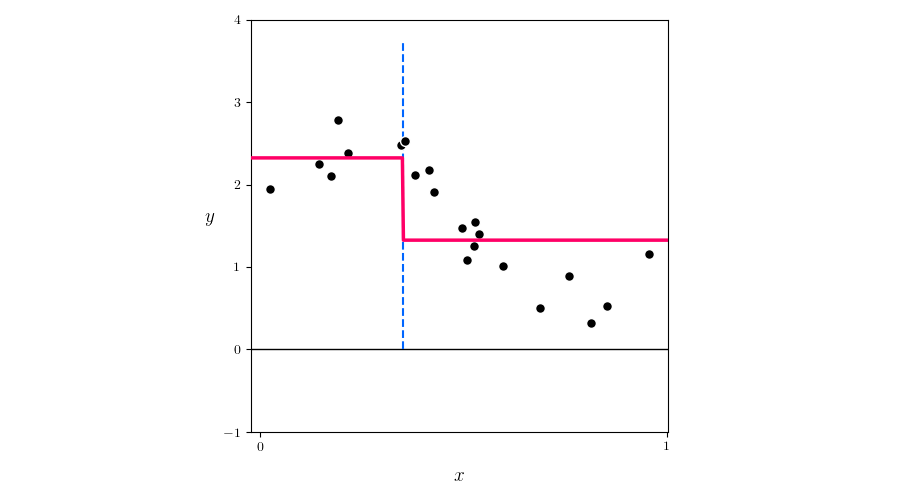
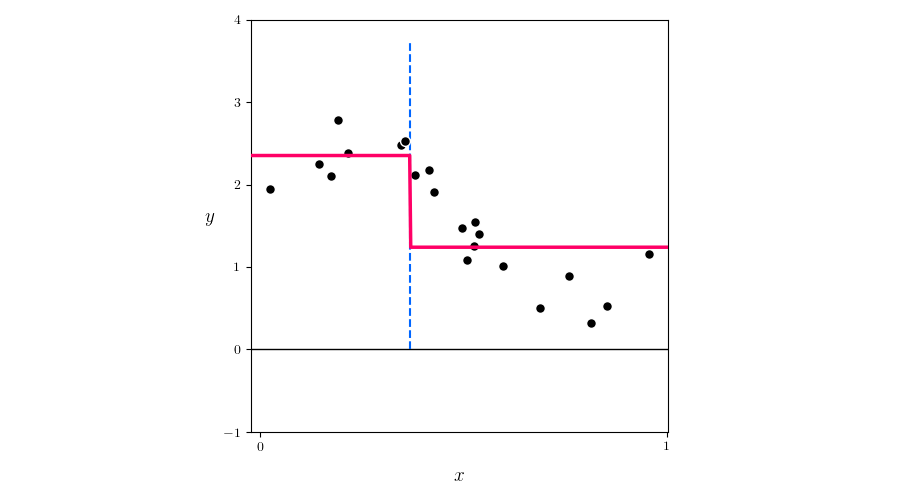
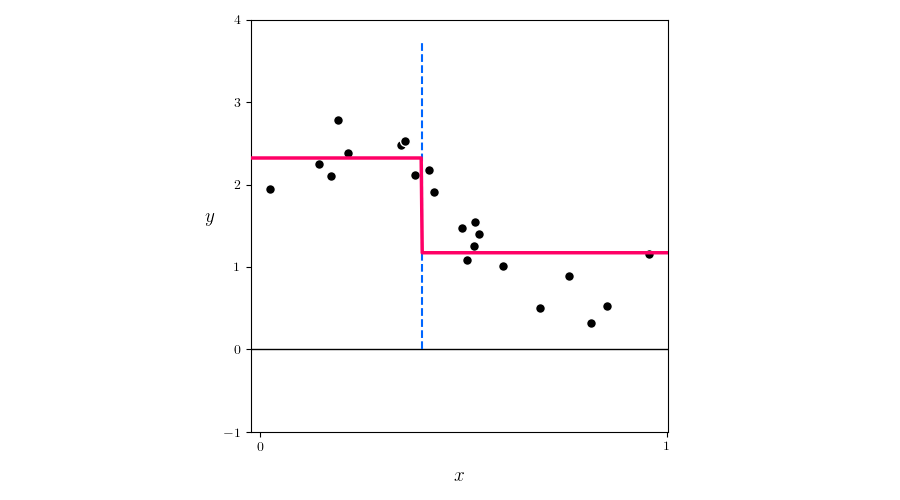
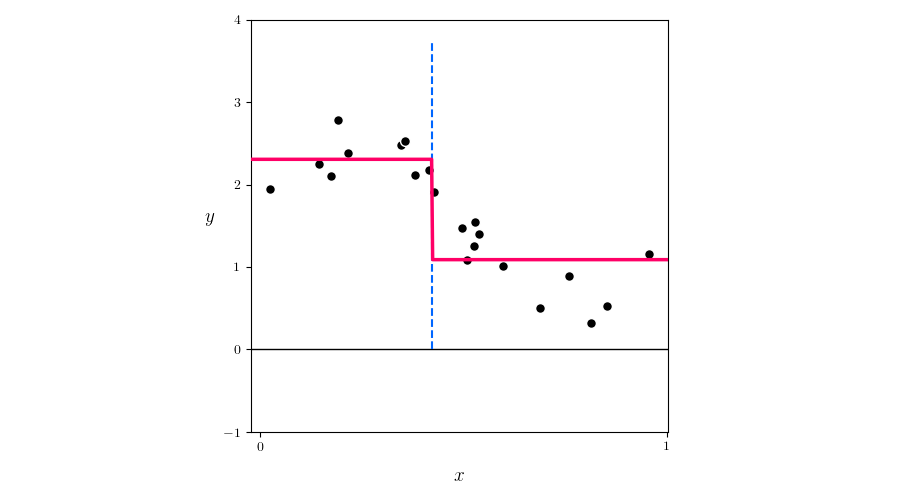
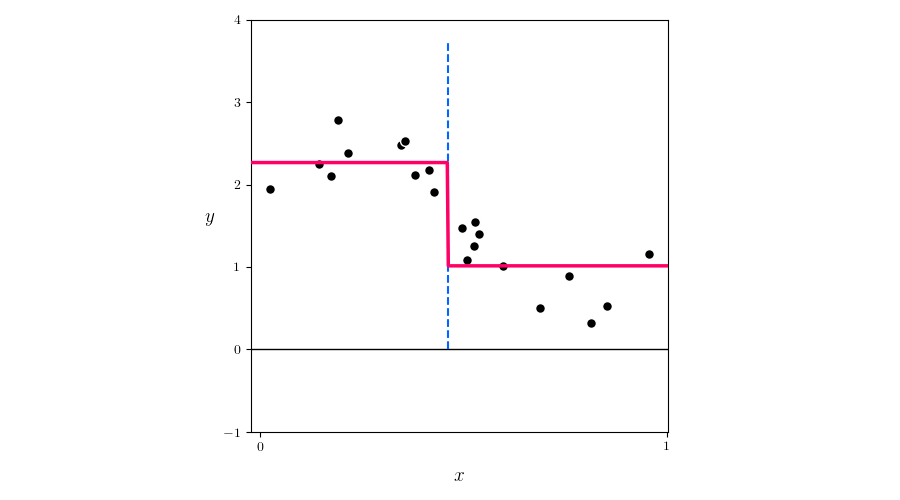
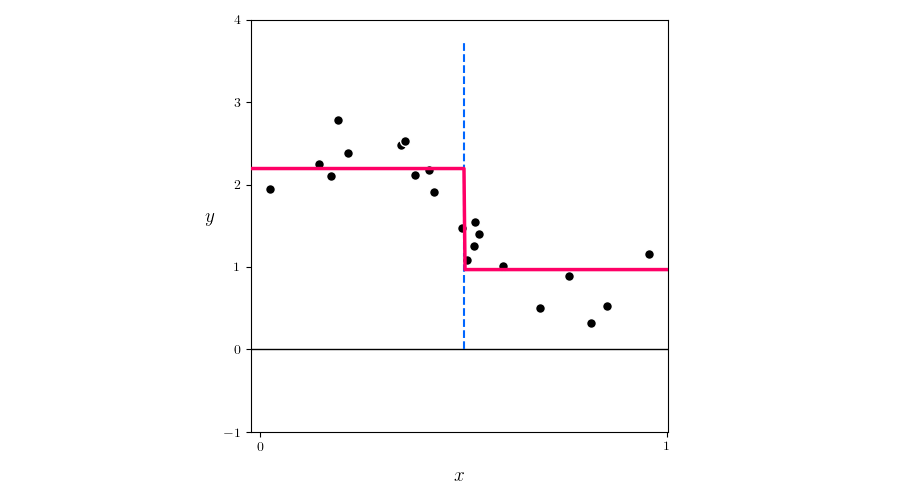
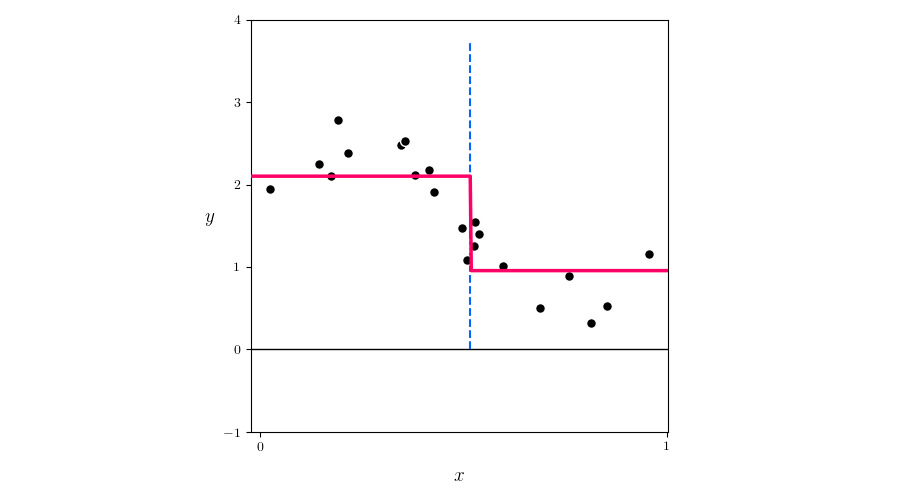
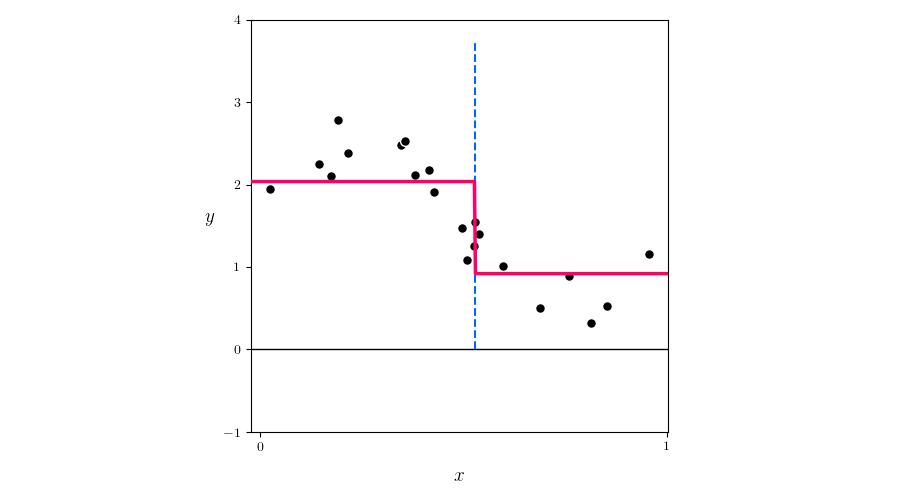
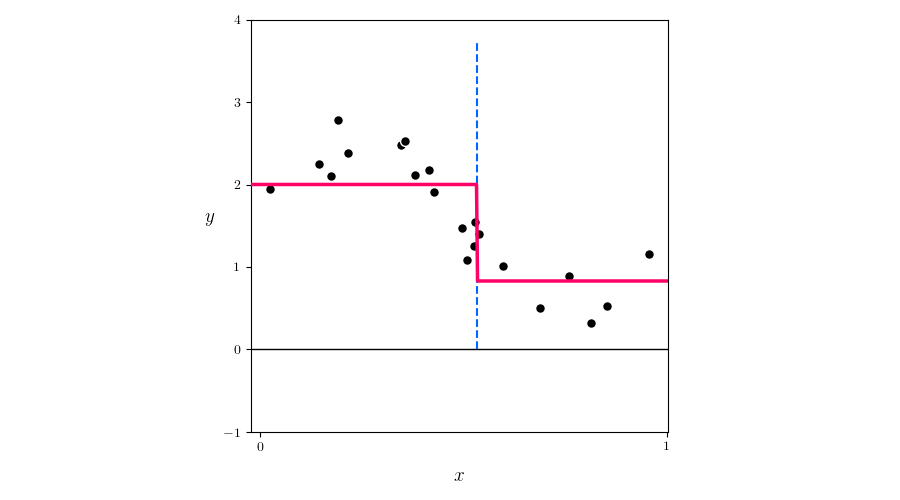
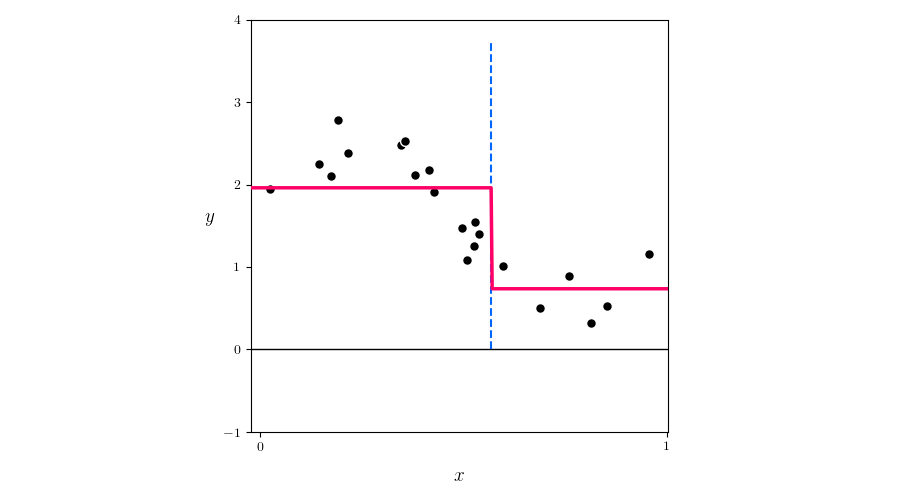
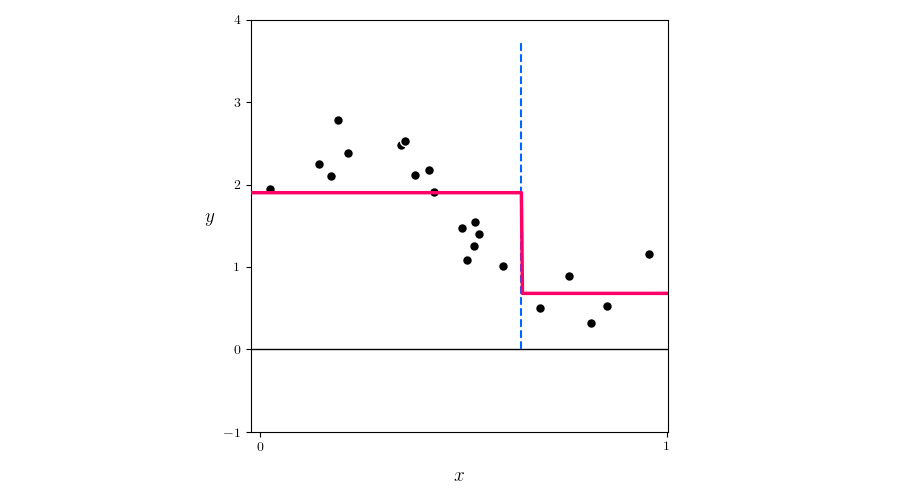
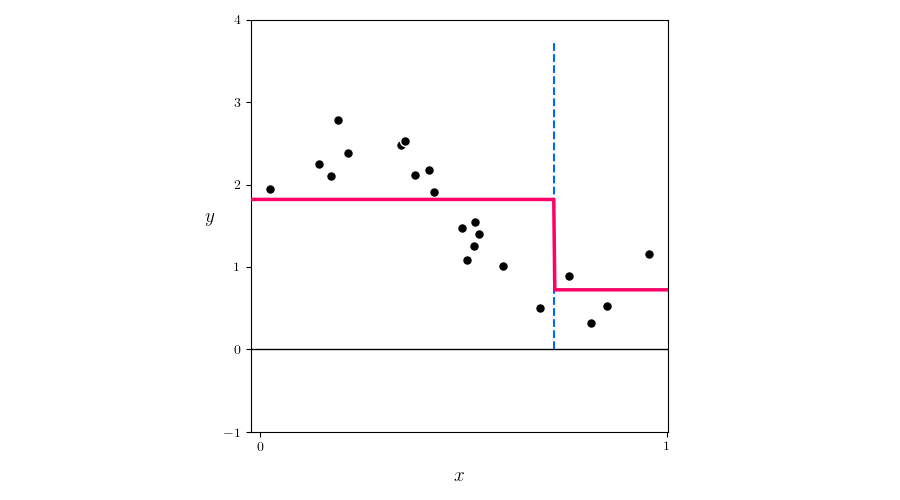
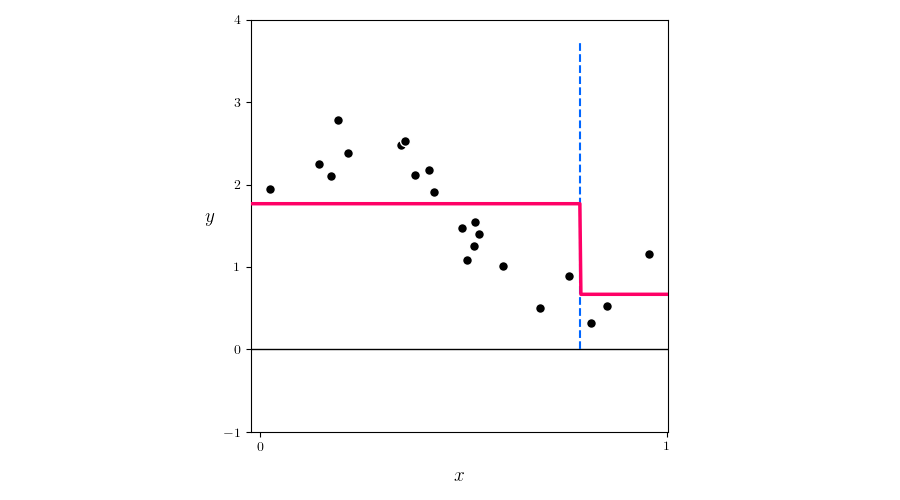
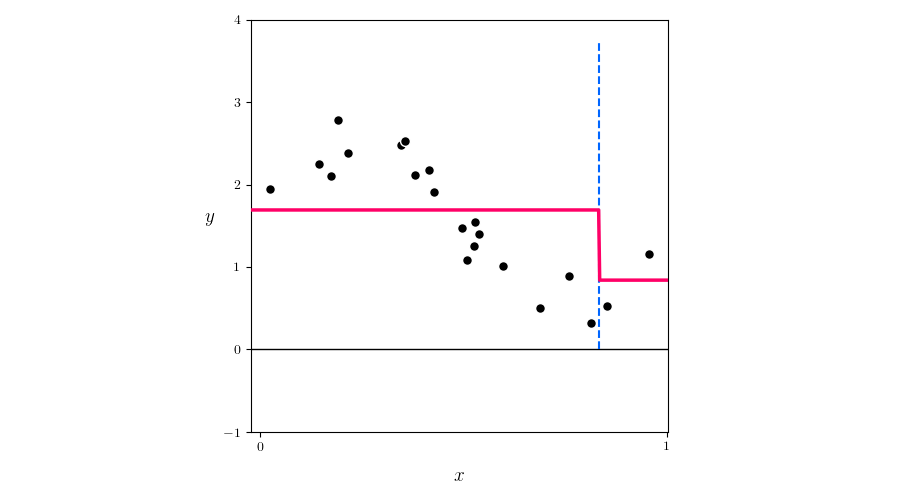
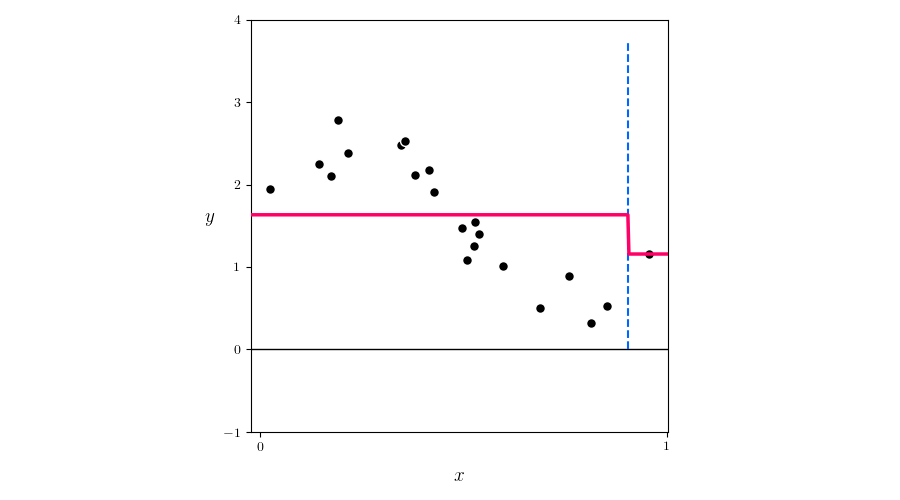

In [20]:
demo = nonlib.stump_visualizer_2d.Visualizer()
csvname = datapath + 'noisy_sin_raised.csv'
demo.load_data(csvname)
demo.browse_stumps()


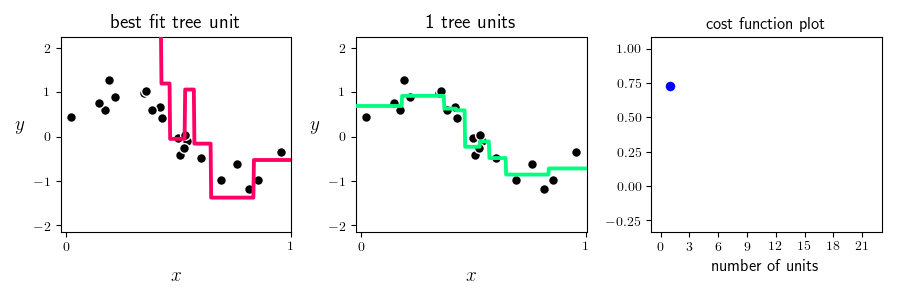
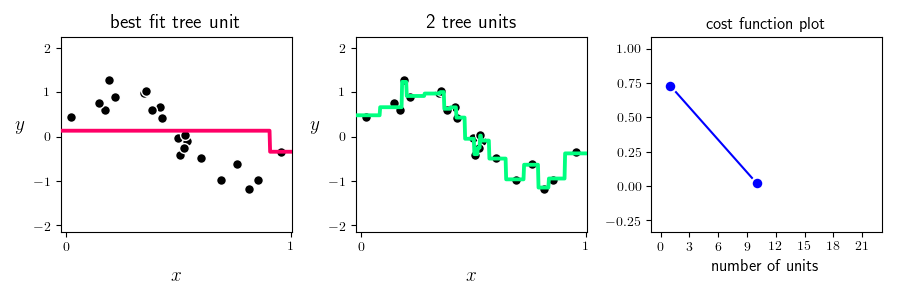
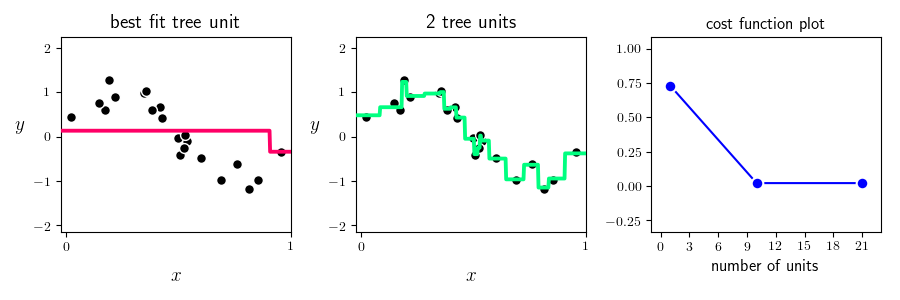

In [21]:
demo = nonlib.regression_basis_single.Visualizer()
csvname = datapath + 'noisy_sin_sample.csv'
demo.load_data(csvname)
demo.brows_single_fit(basis='tree',num_elements = [v for v in range(1,10)])


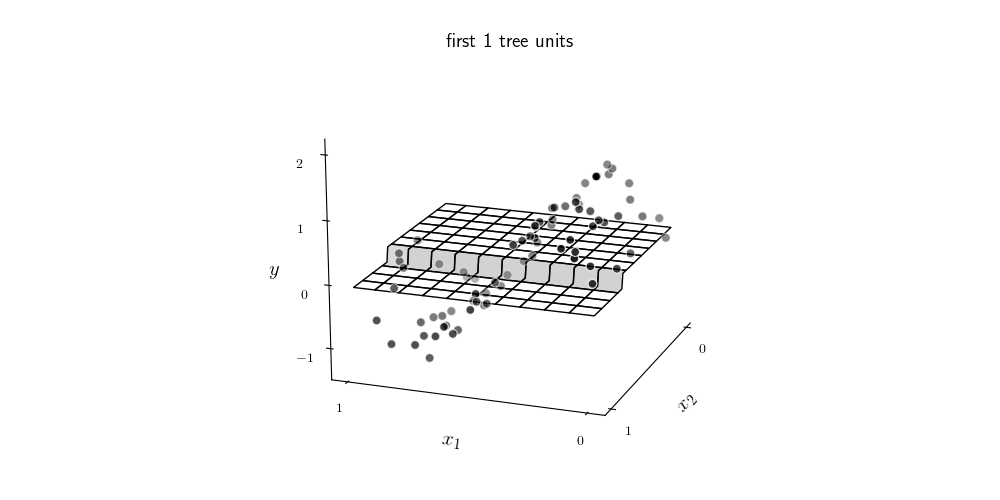
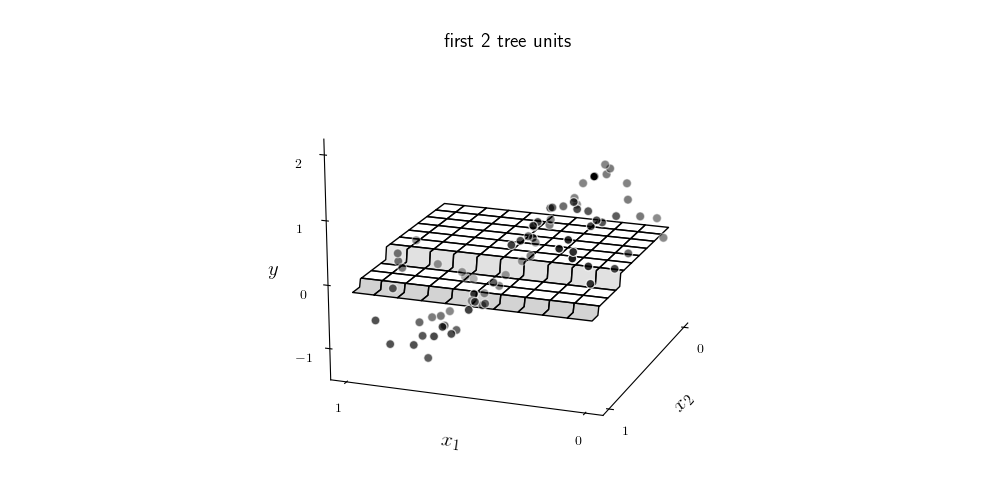
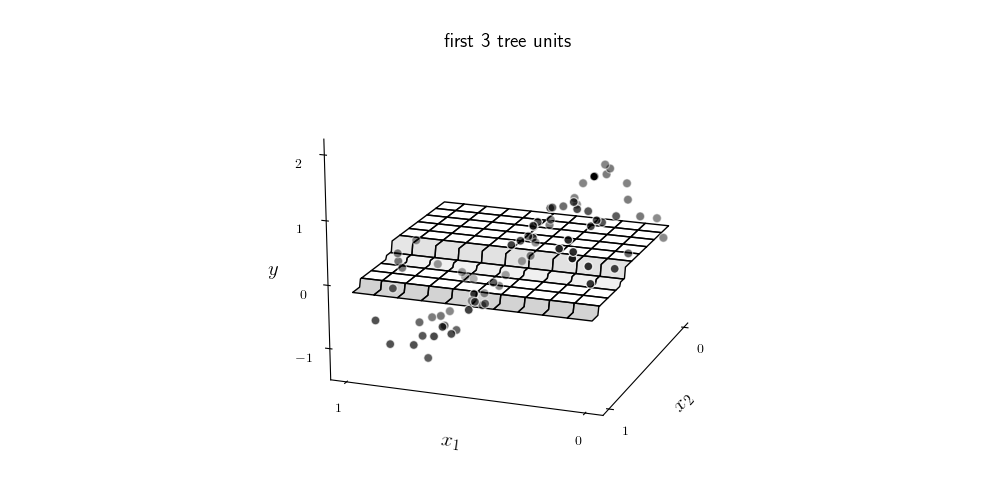
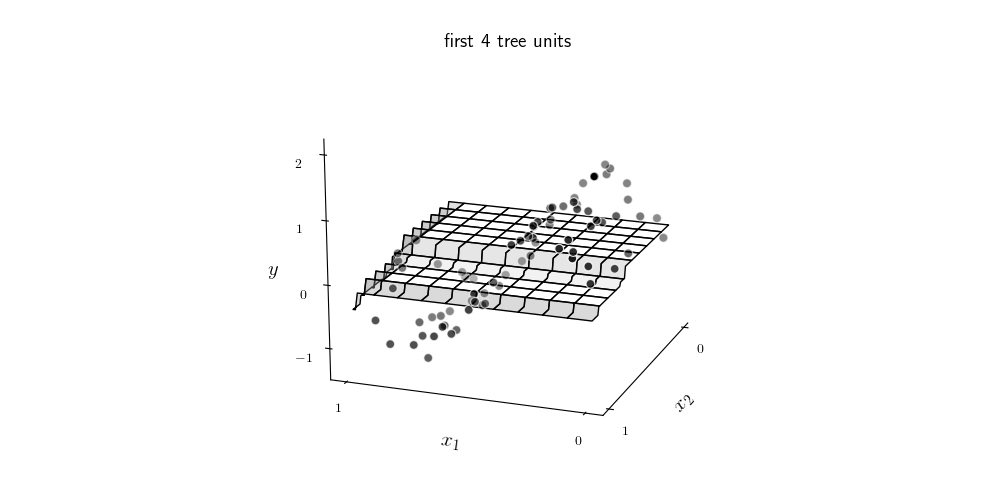
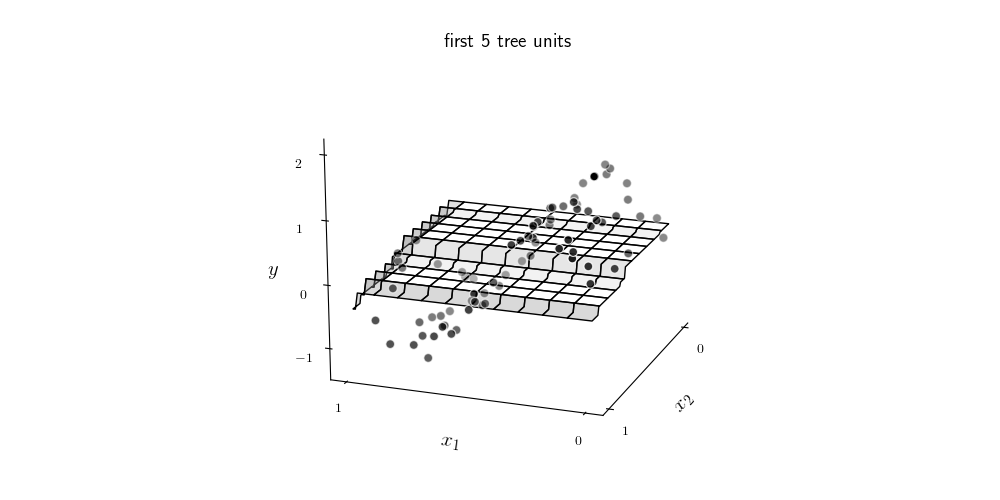
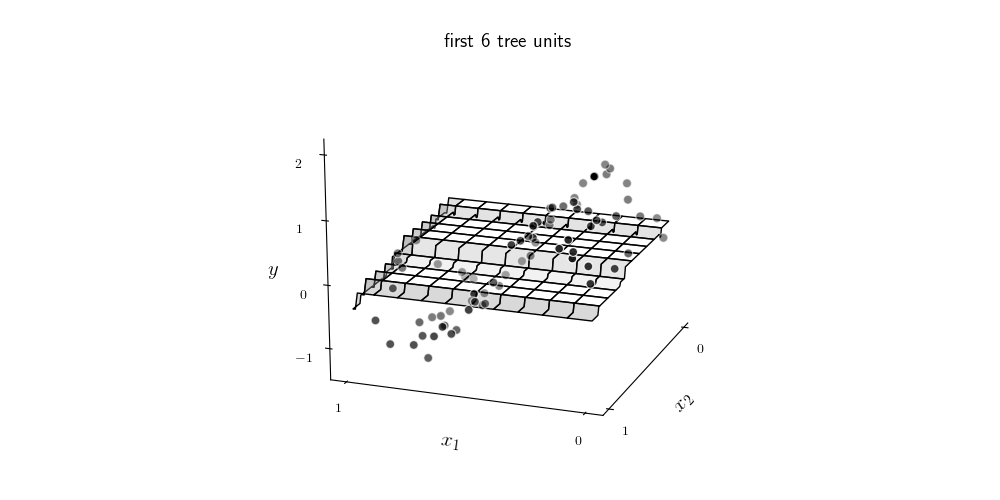
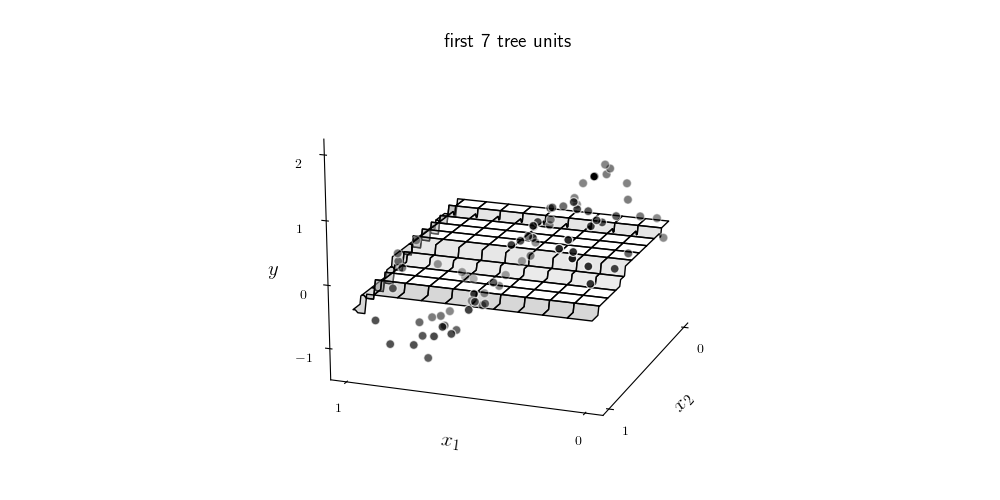
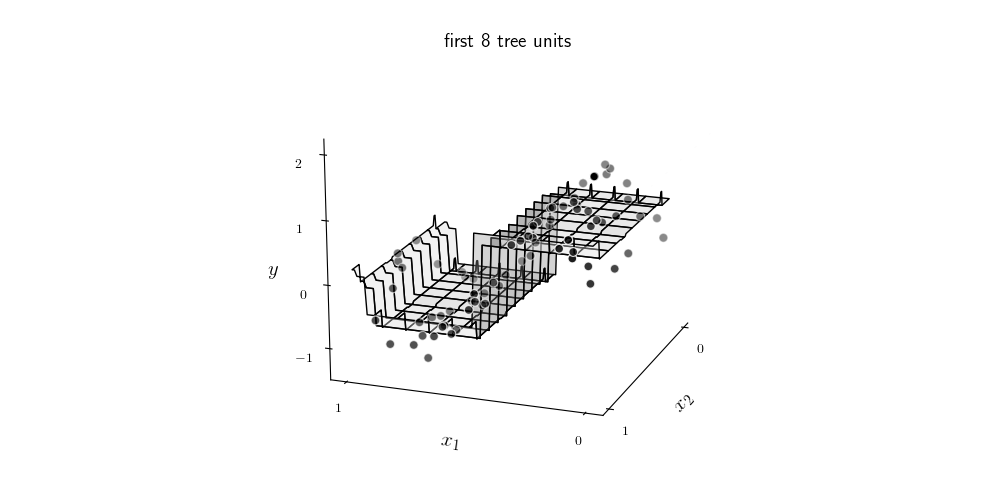
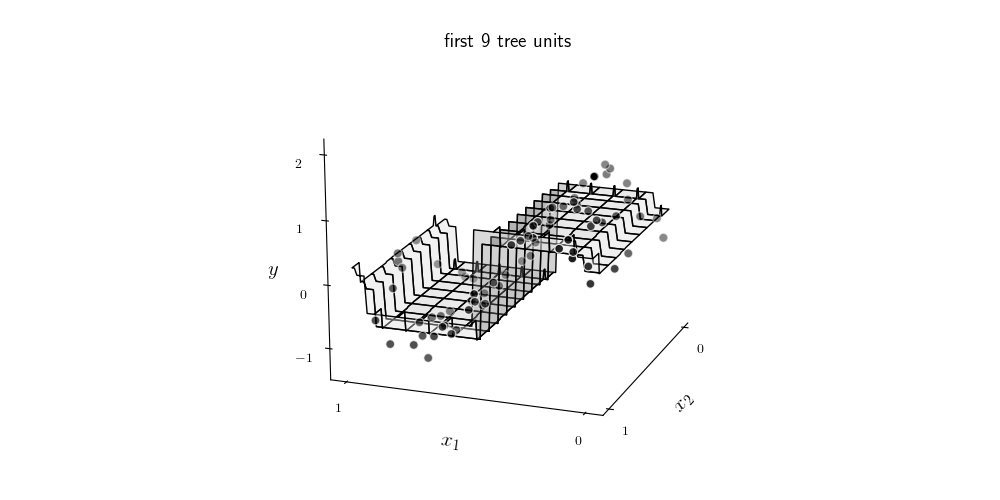
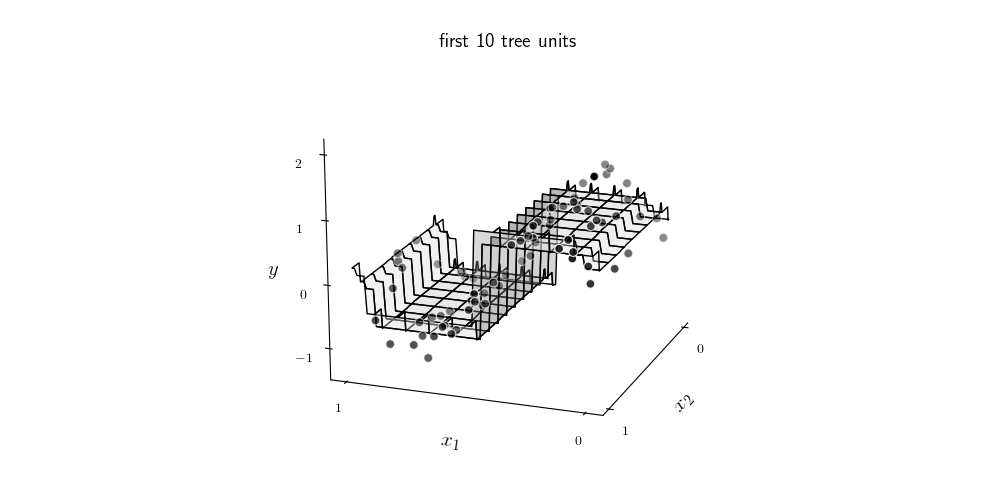
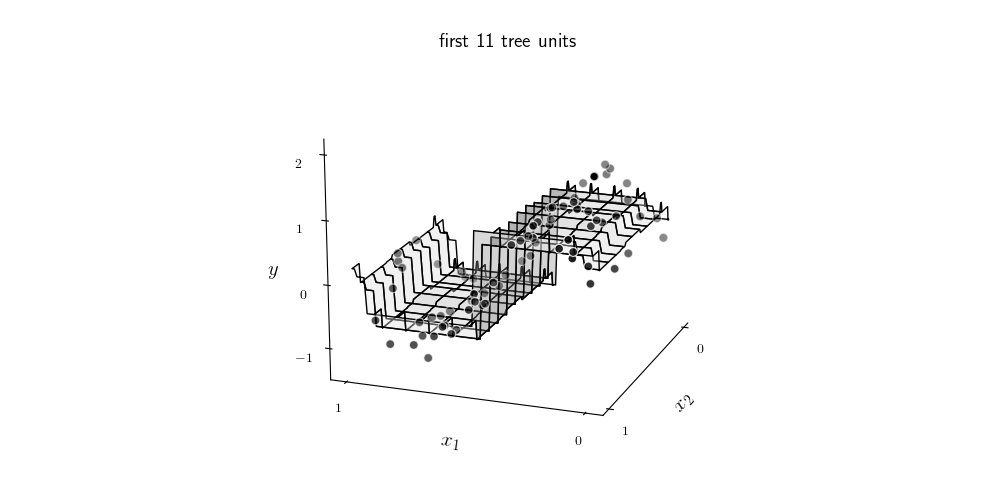
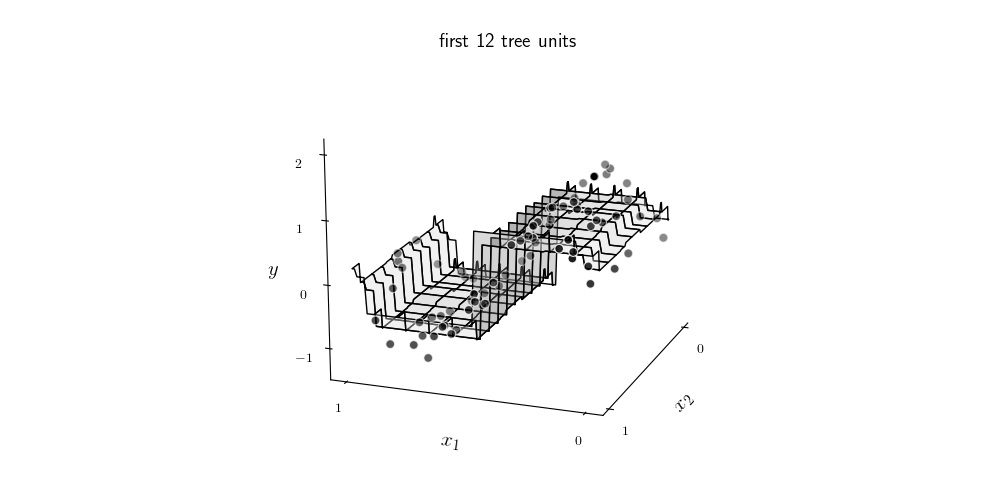
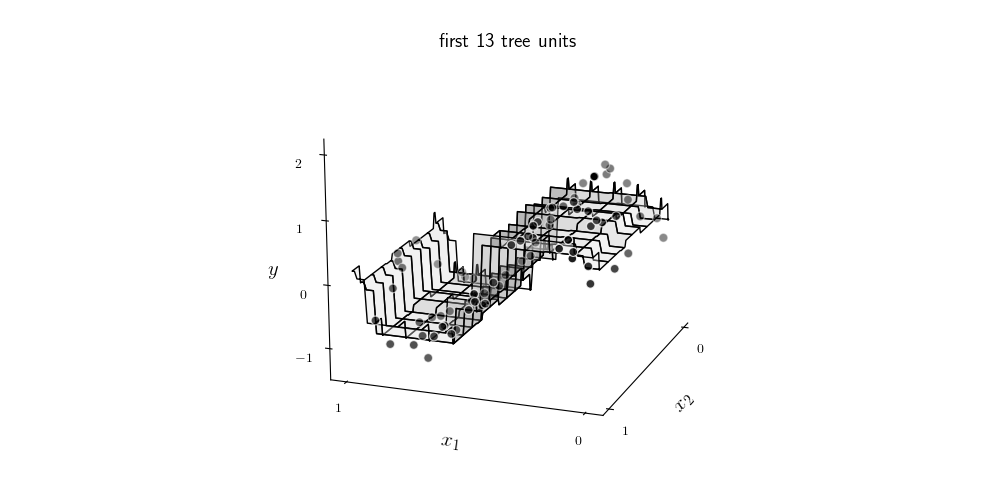
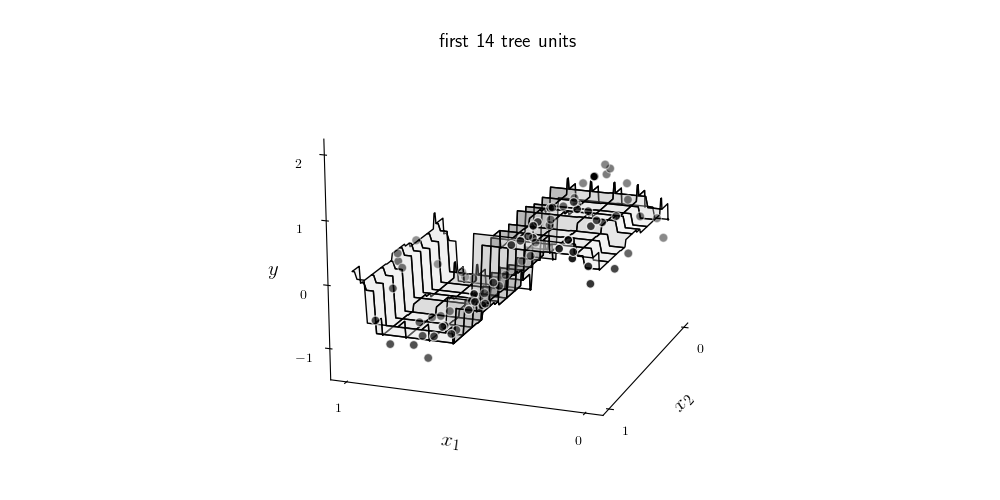
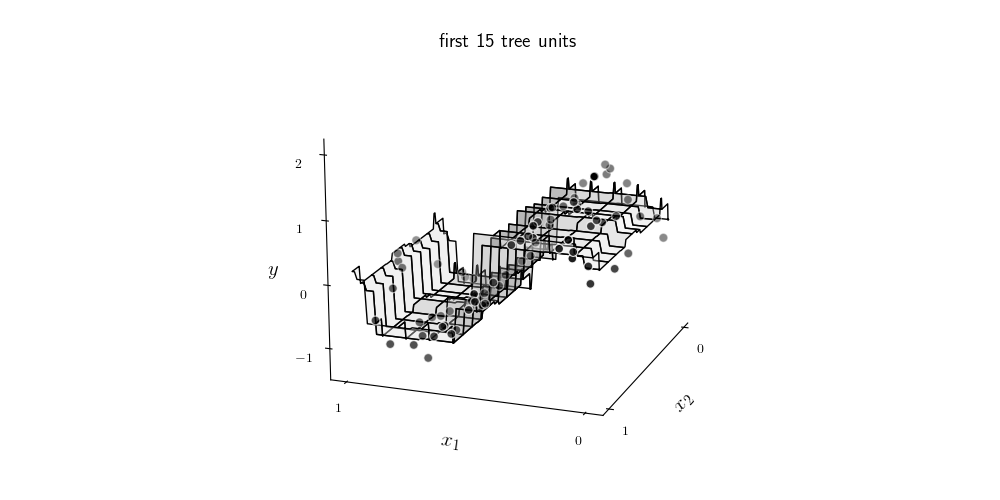
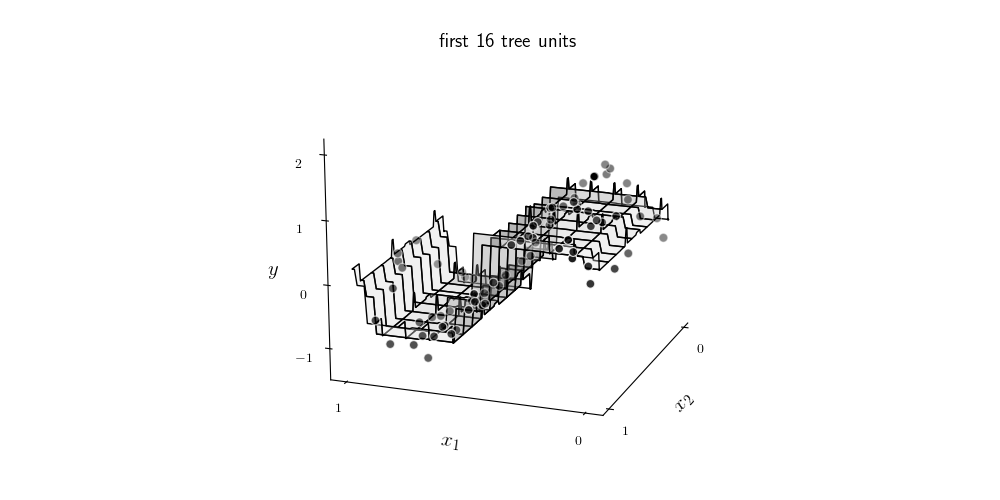
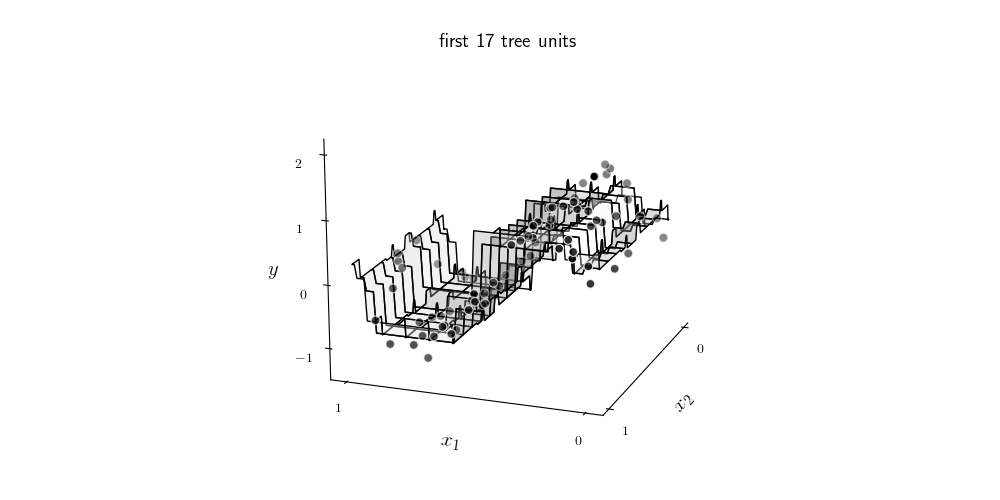
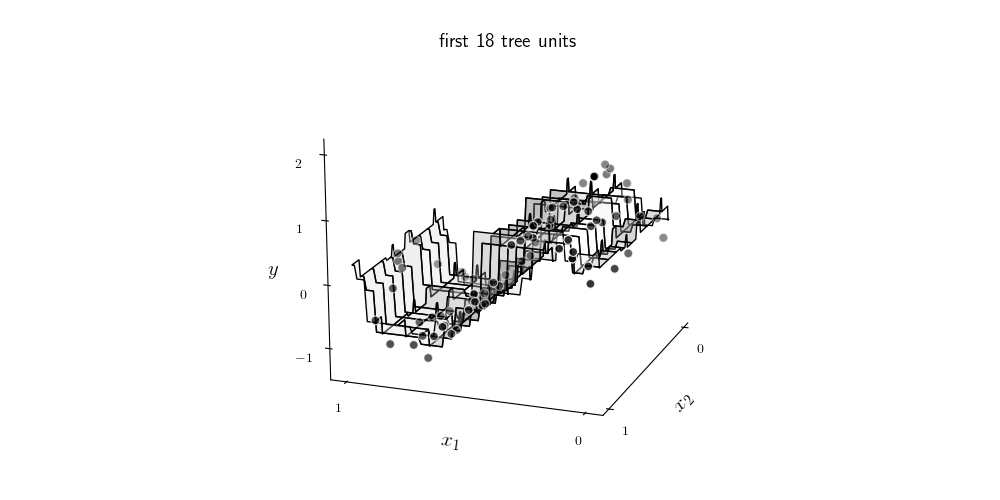
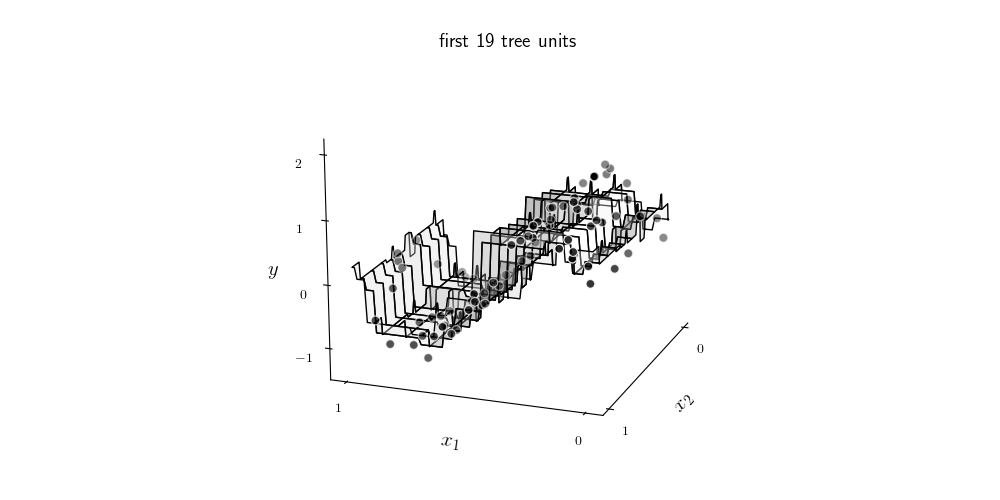

In [22]:
demo = nonlib.regression_basis_comparison_3d.Visualizer()
csvname = datapath + '3d_noisy_sin_sample.csv'
demo.load_data(csvname)
demo.brows_single_fits(num_elements =  [v for v in range(1,20)] ,view = [20,110],basis = 'tree')

- Generalizes to $N$ dimensional input (split points / levels in each individual dimension)

- **General attributes of tree bases:**
    - each element is adjustable, with internal parameters pre-set greedily to data 
    - leads to *convex* cost functions for regression / classification, trained via *boosting* (greedy coordinate descent)
    - great for large sparse datasets

# How many elements to choose?

- The more elements we use the better we fit our data (provided we optimize correctly)

- This is good in theory, but not in practice

- In theory -with infinite clean data and ininite computation - the more elements (of any basis) --> better fit / separation

- In fact: in such an instance all three catalogues equal, and can perfectly represent / separate


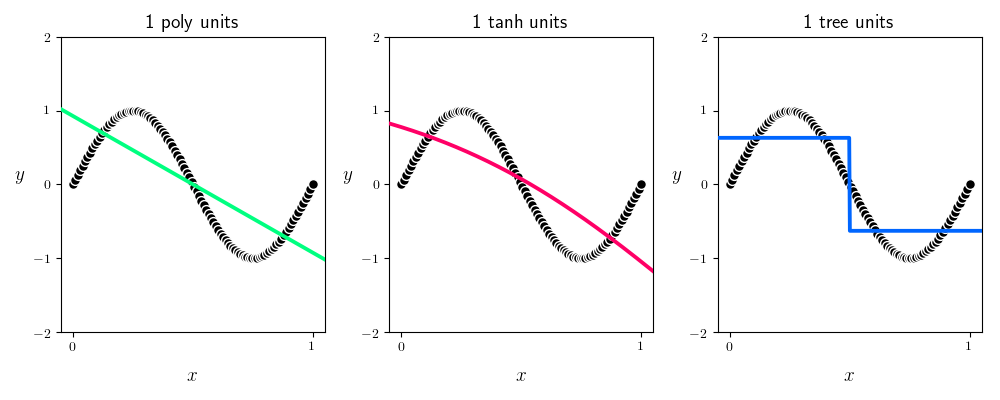
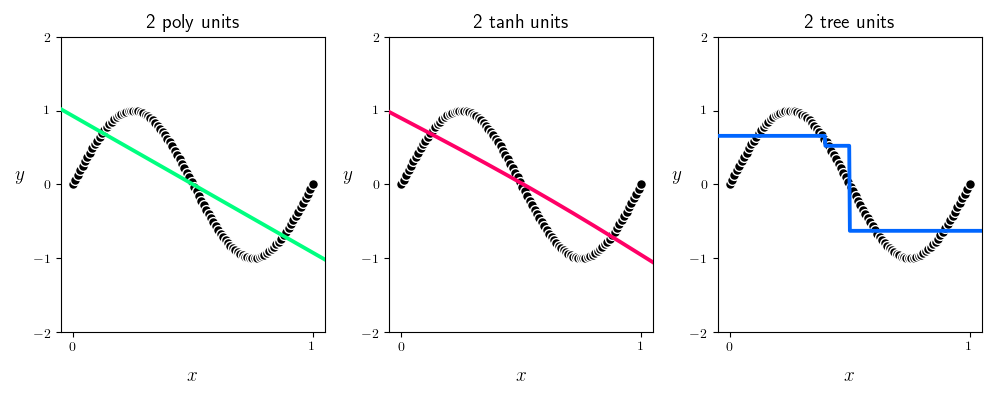
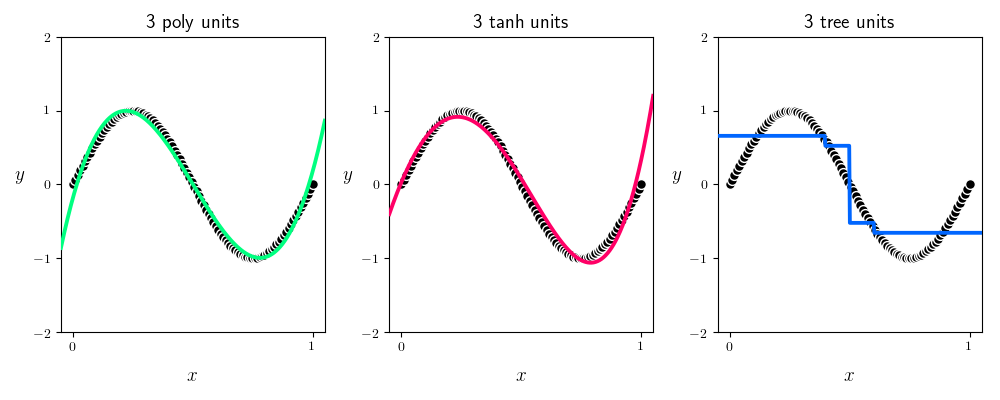
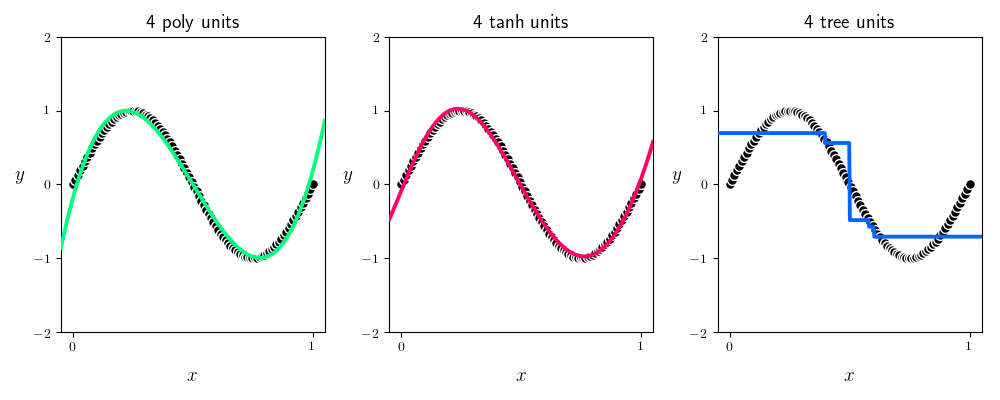
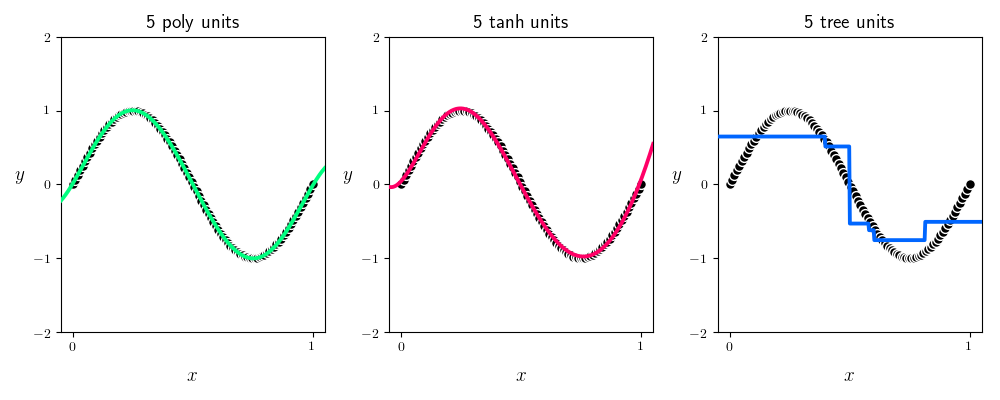
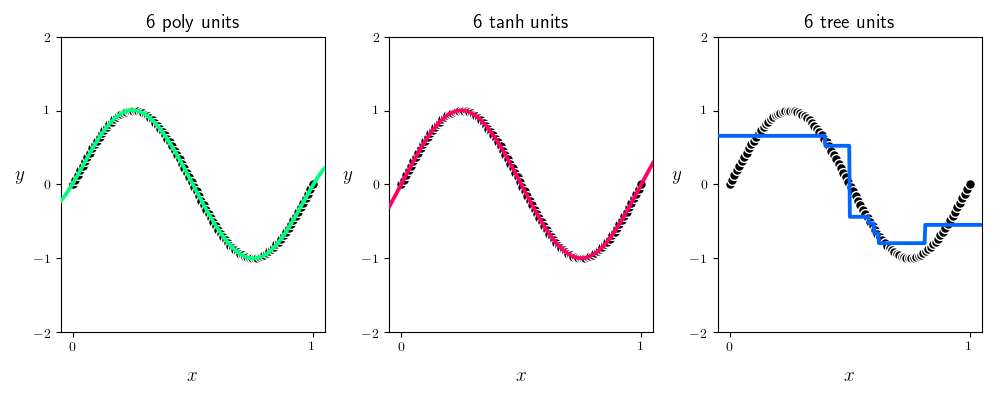
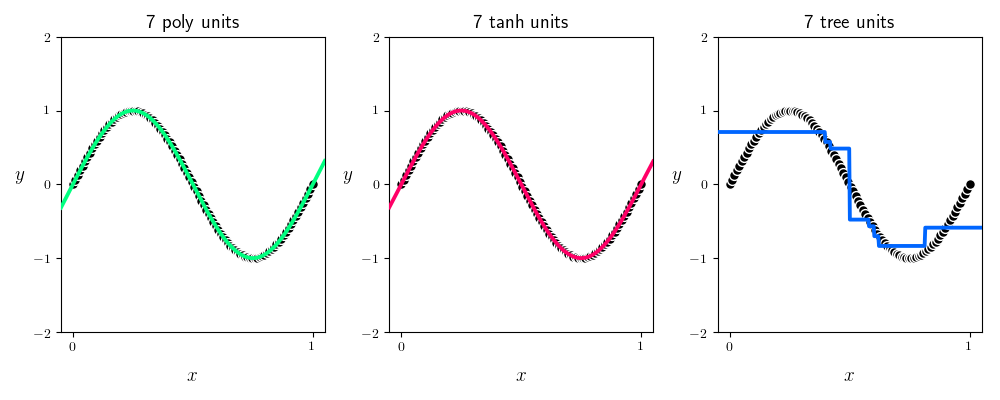
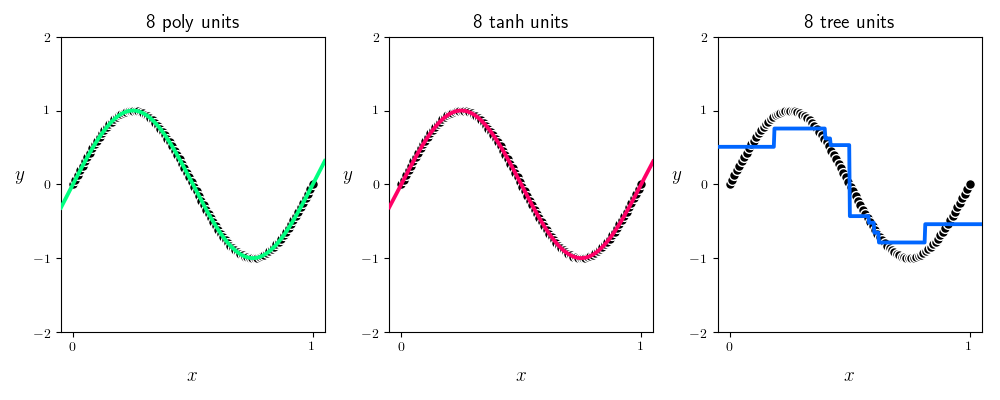
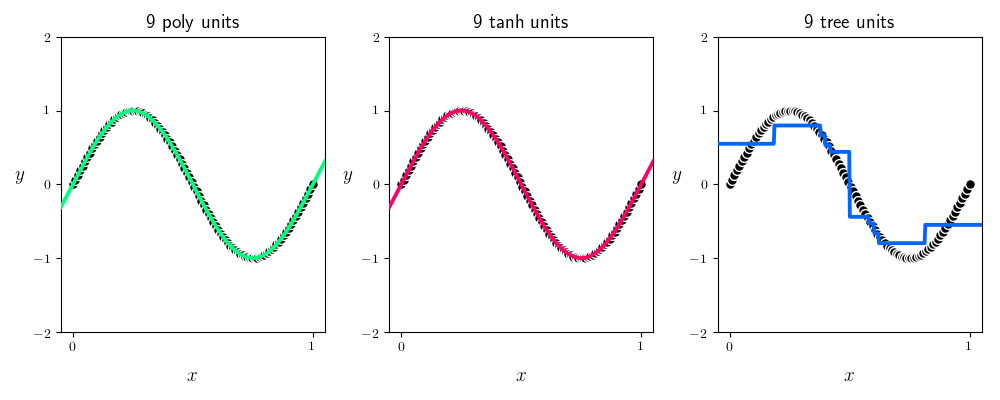
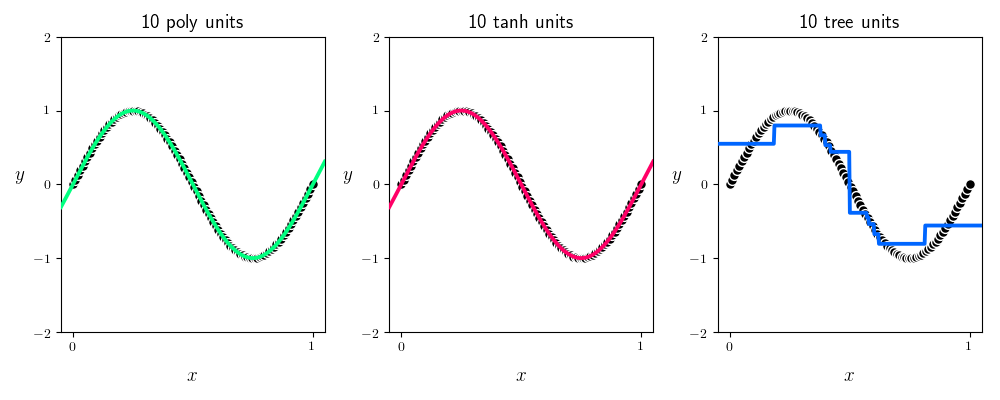
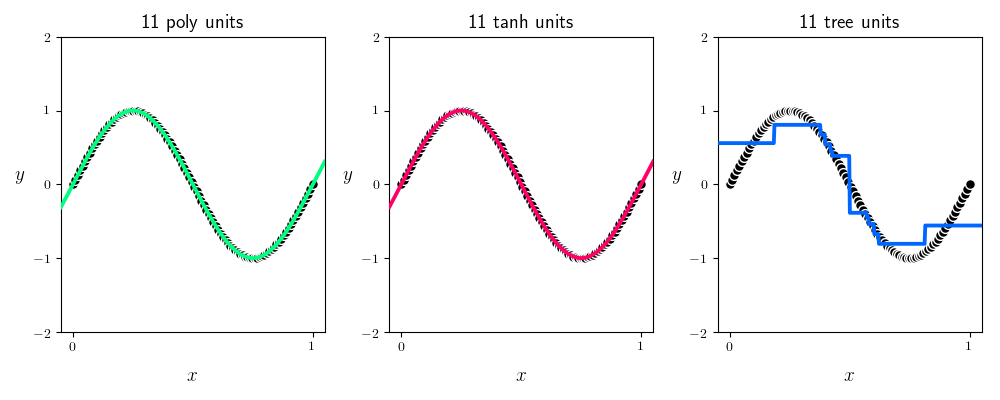
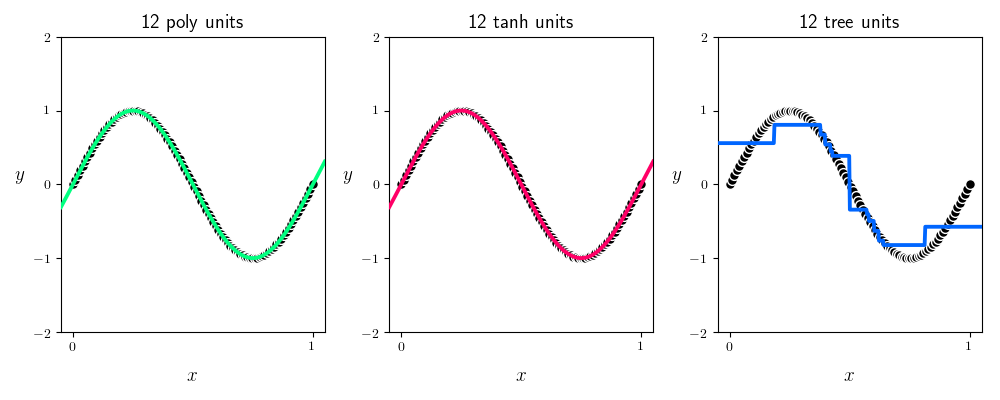
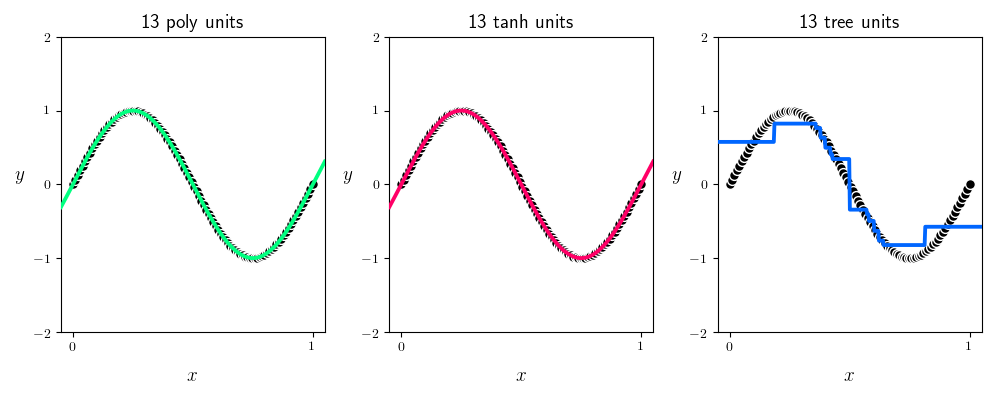
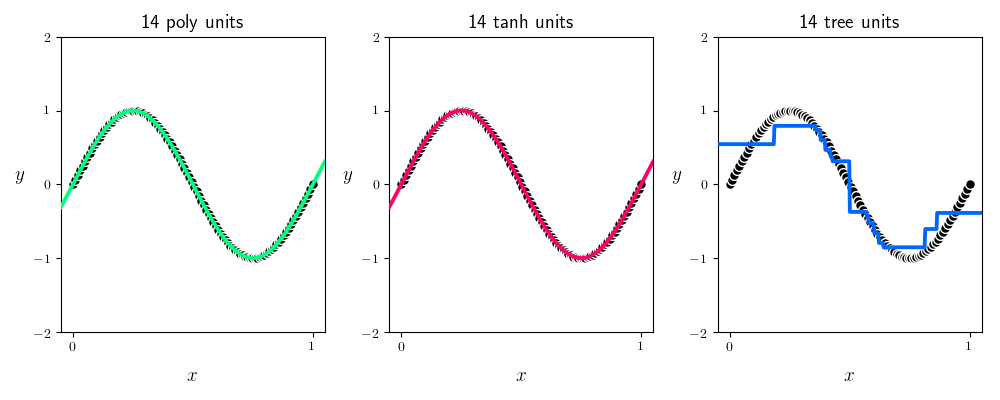
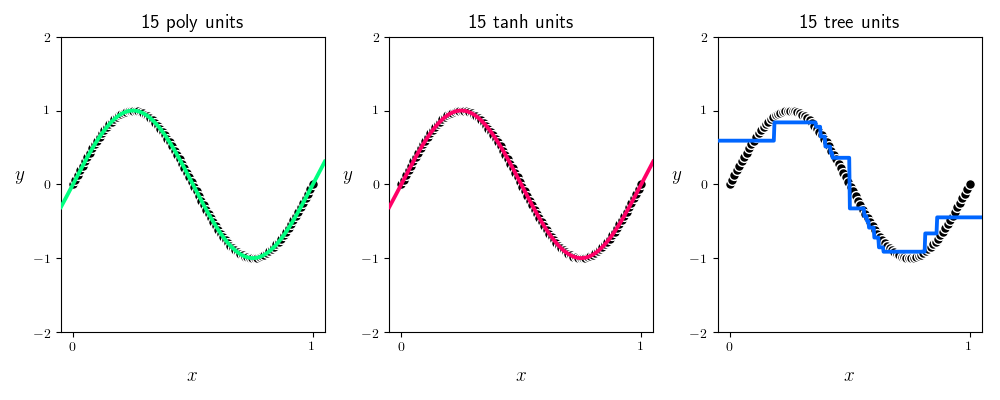
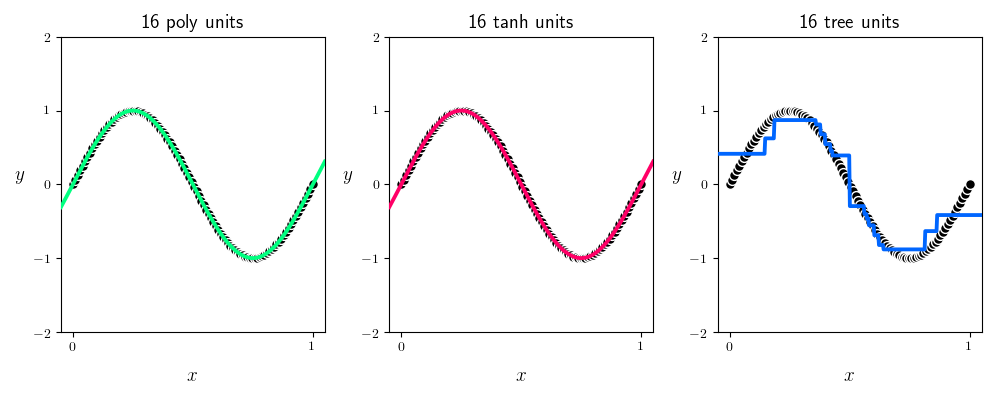
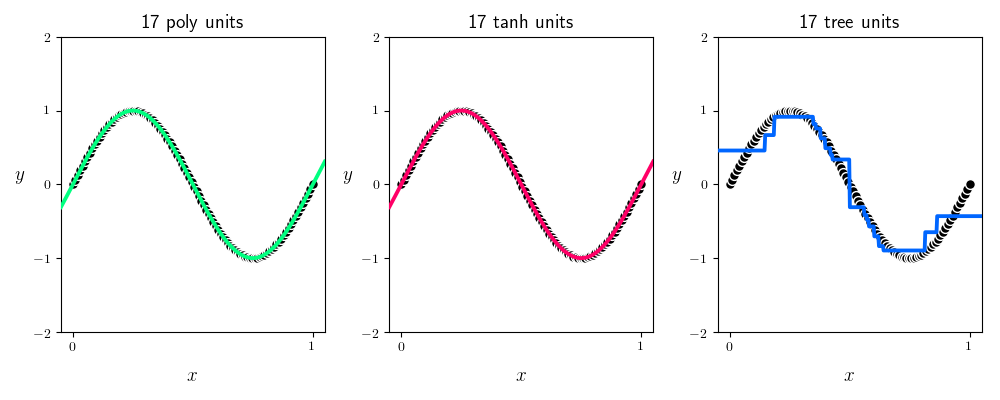
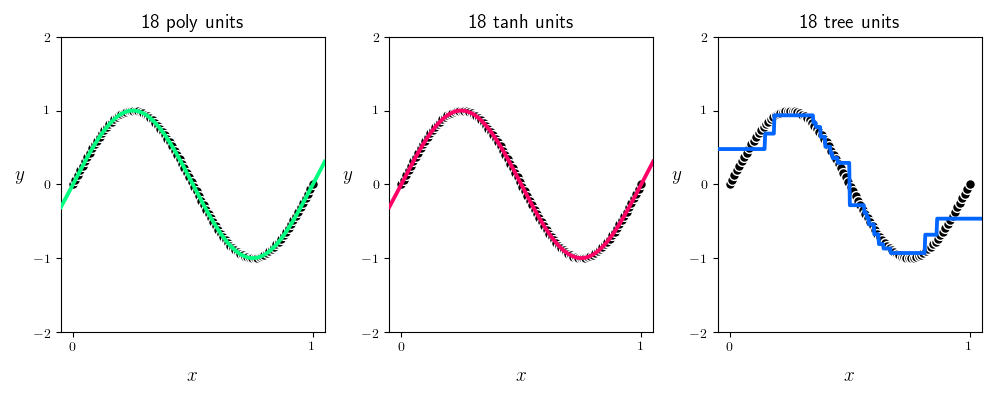
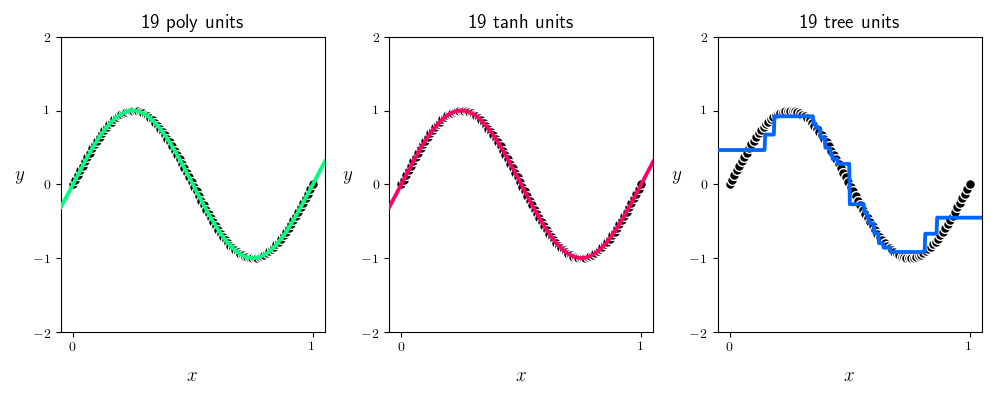
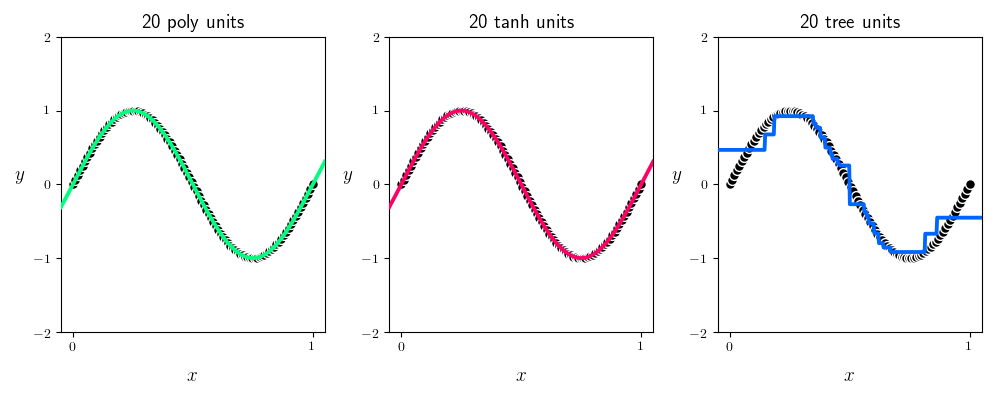
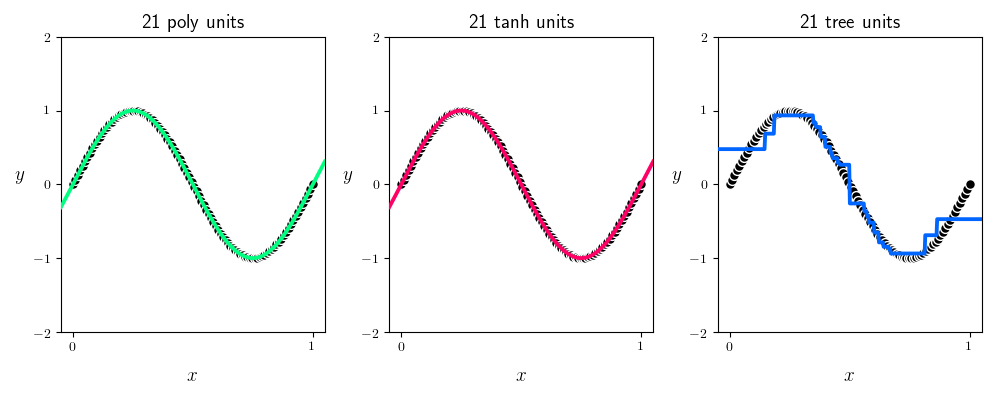
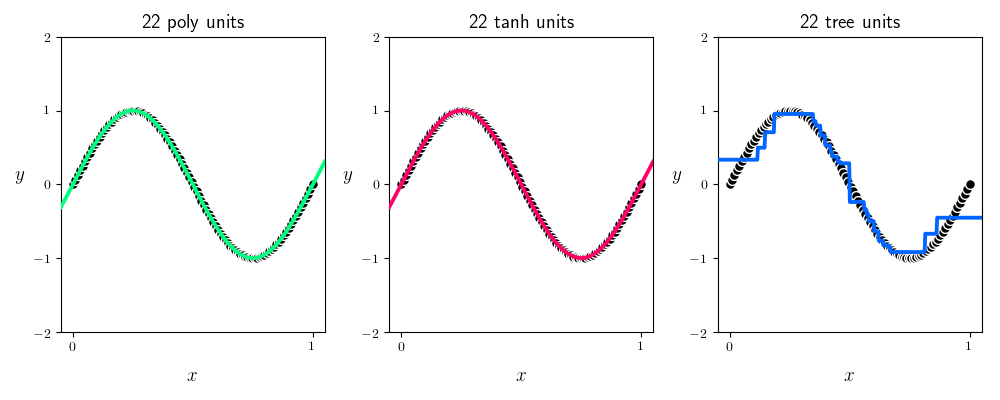
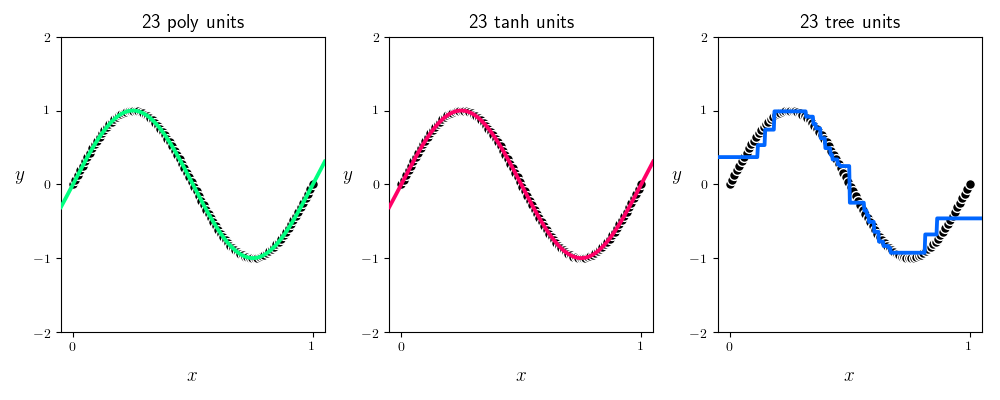
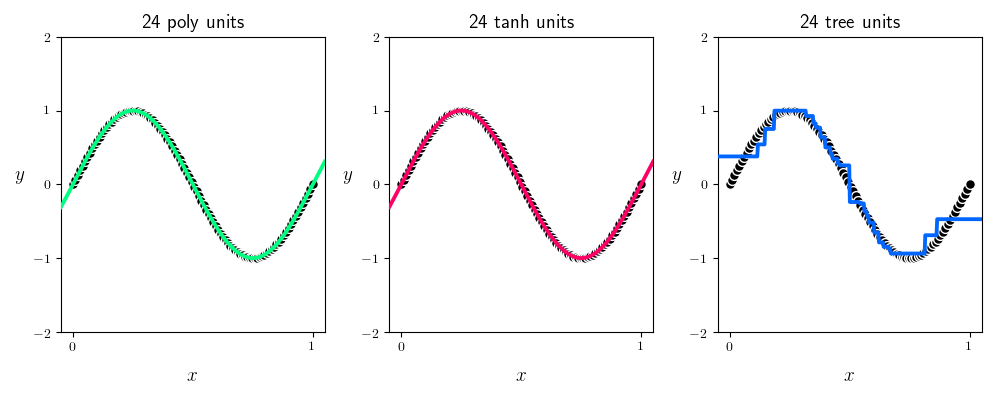
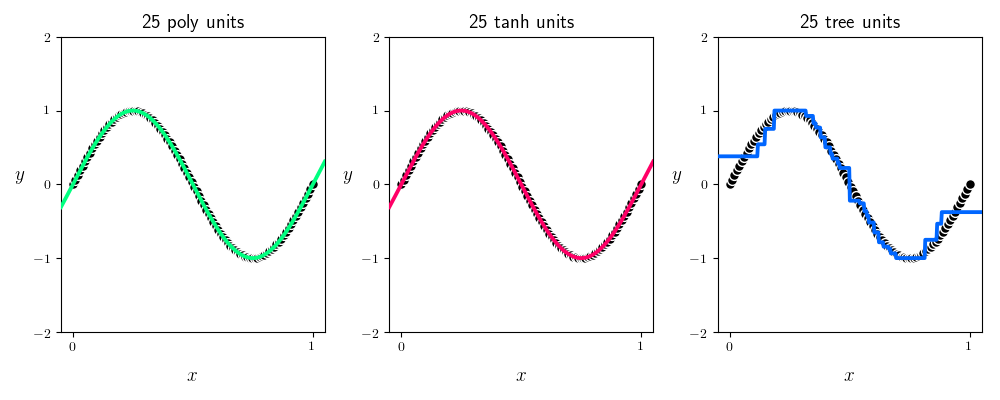
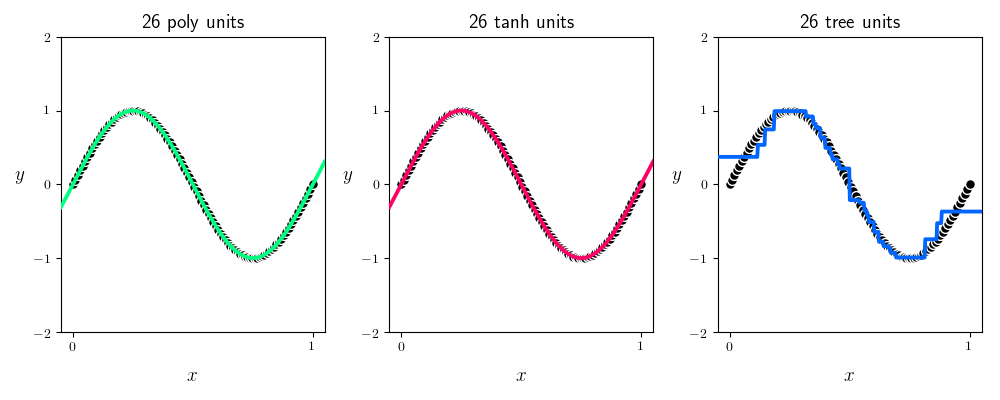
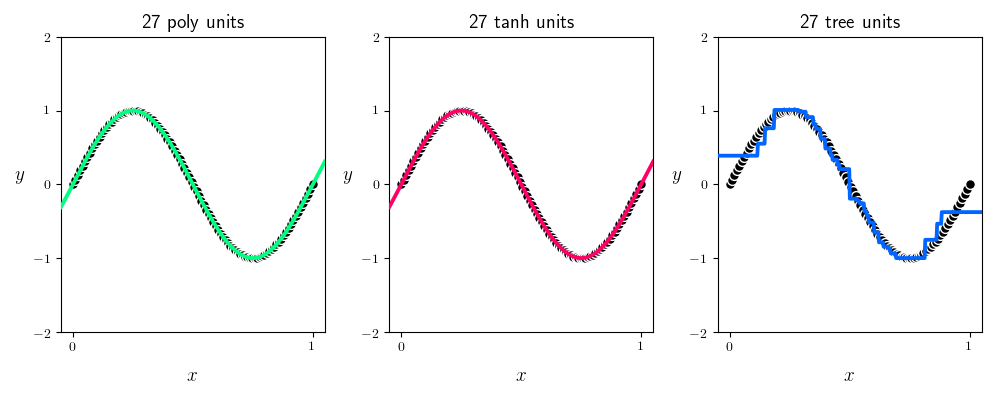
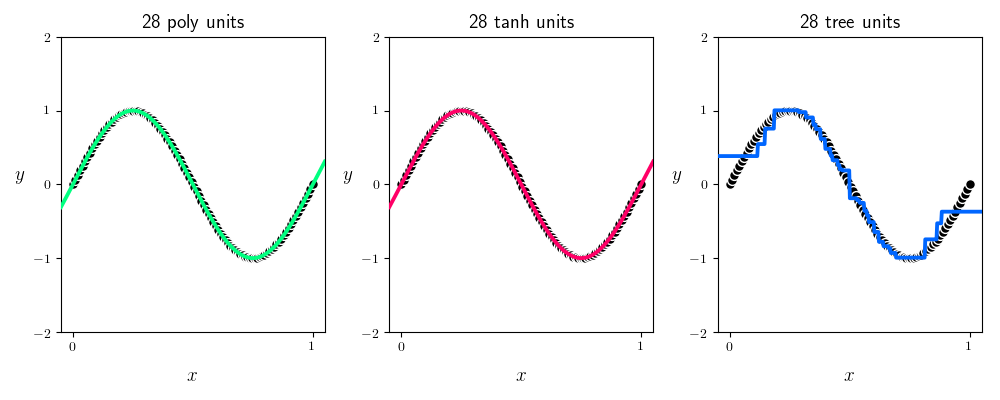
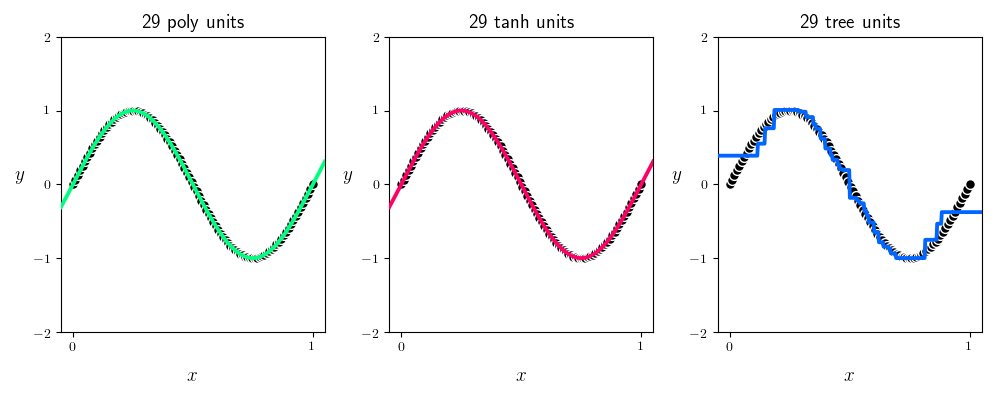
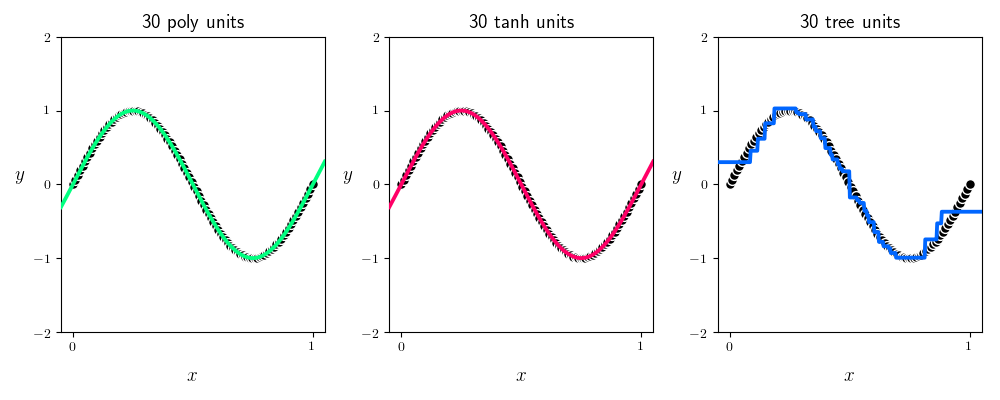
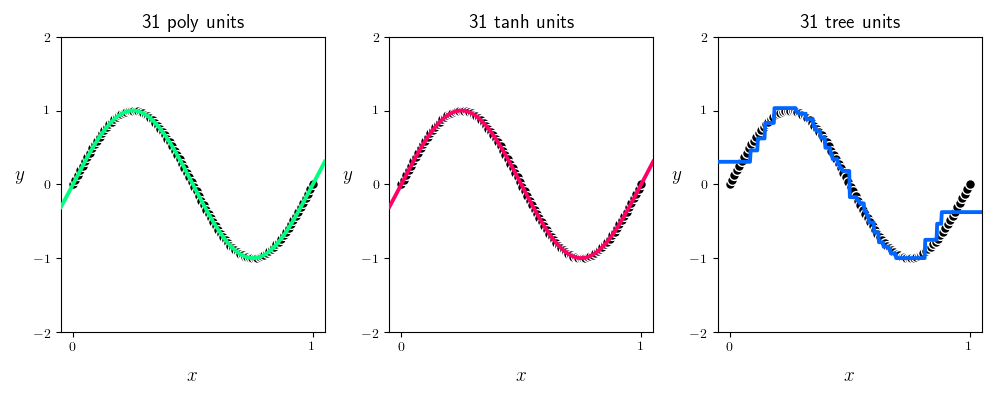
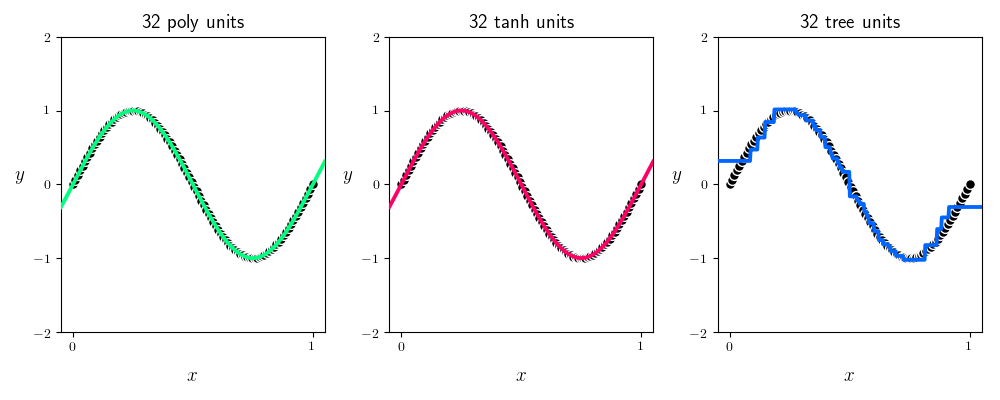
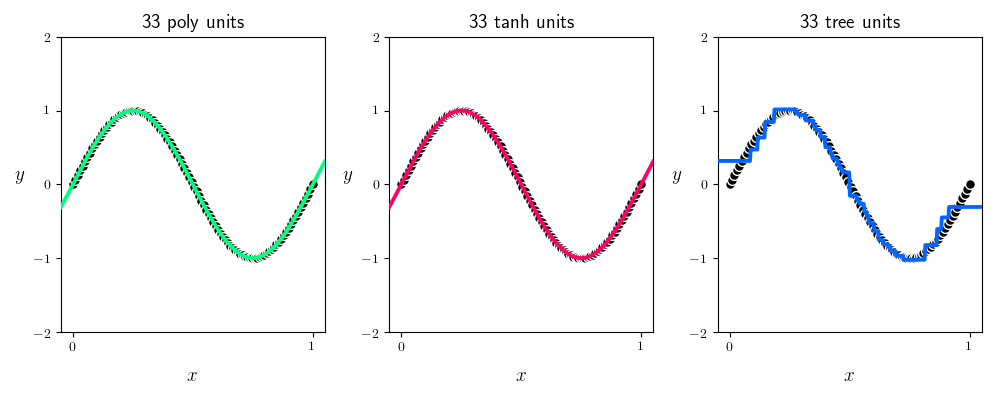
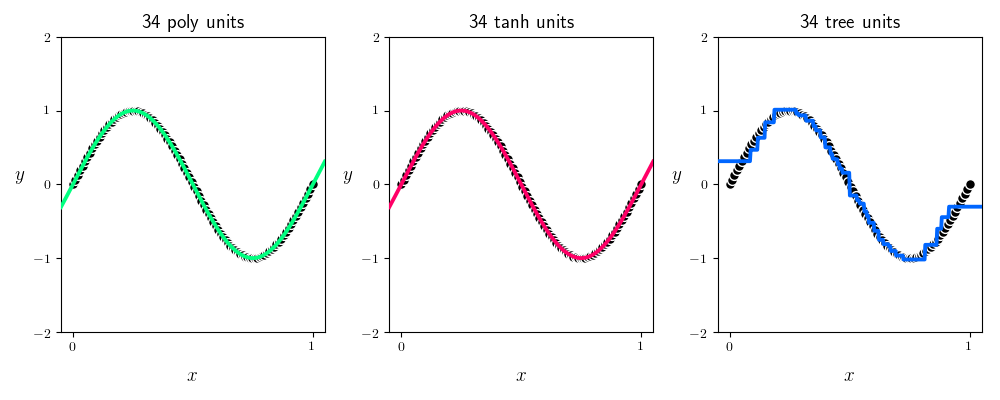
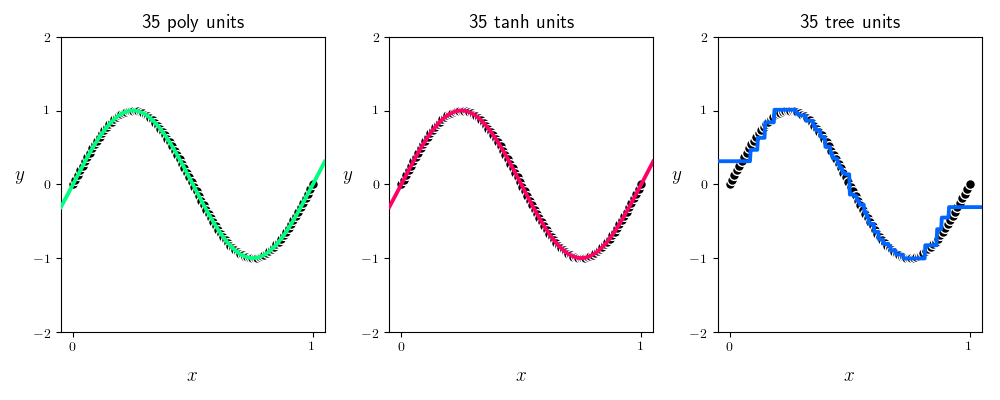
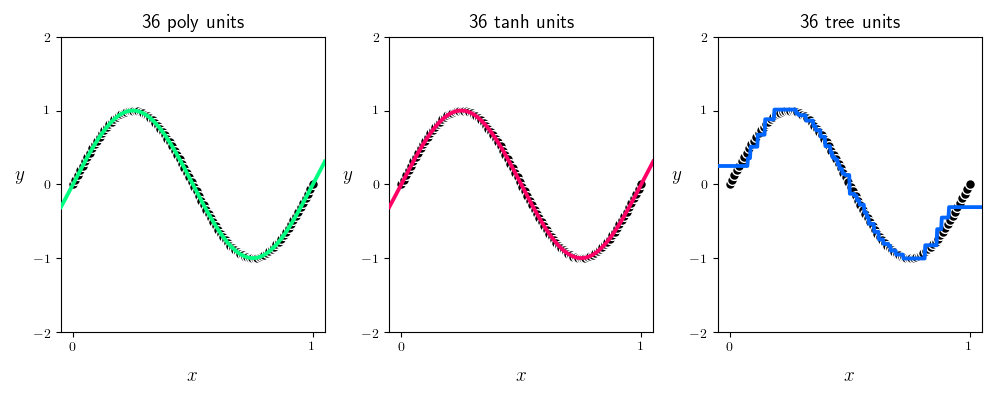
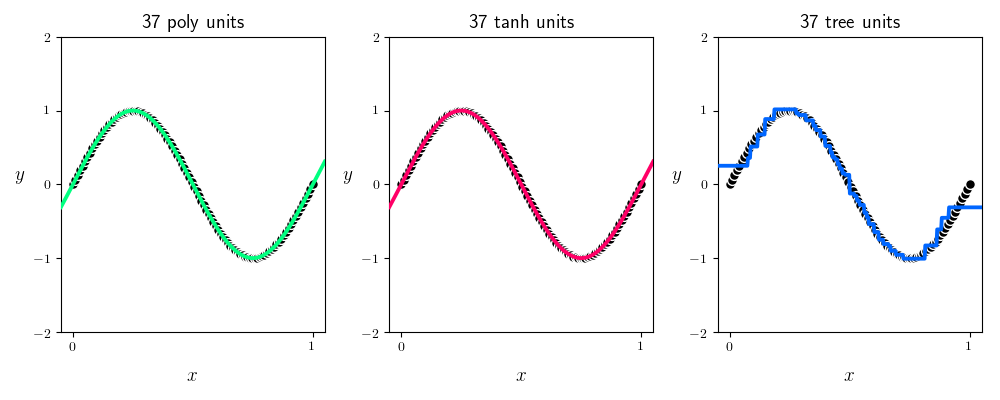
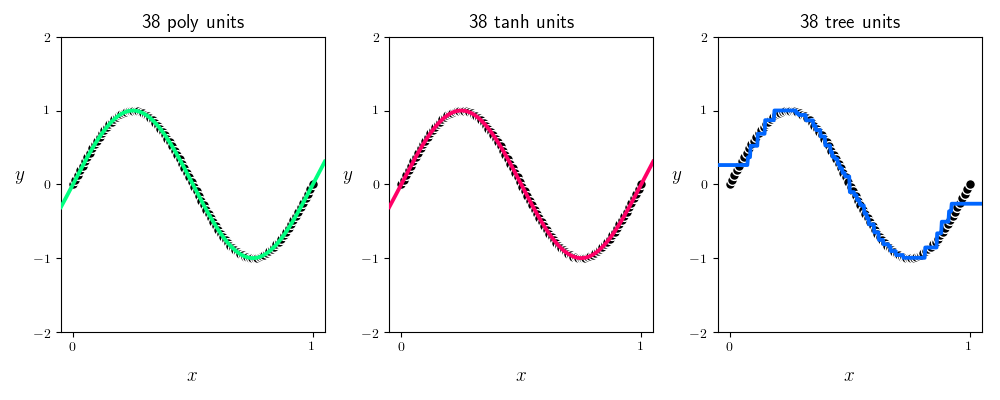
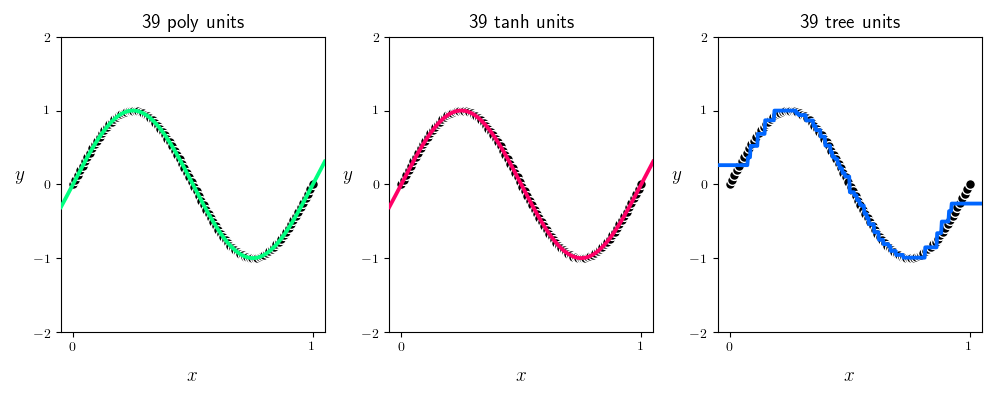
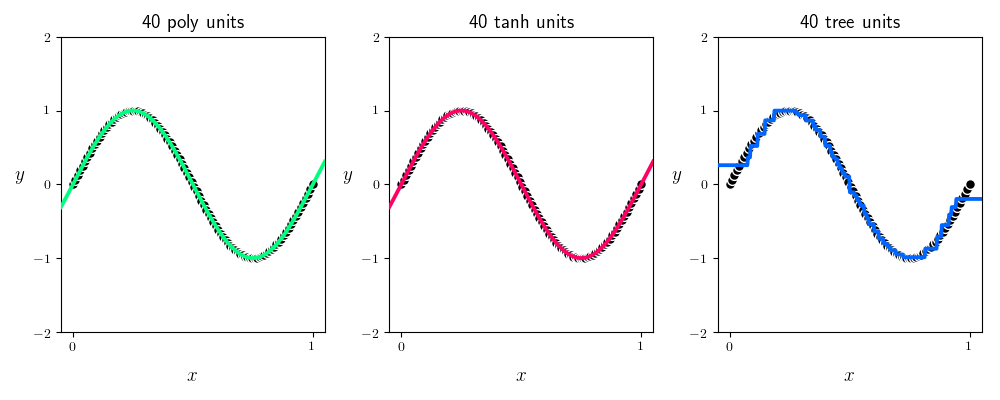
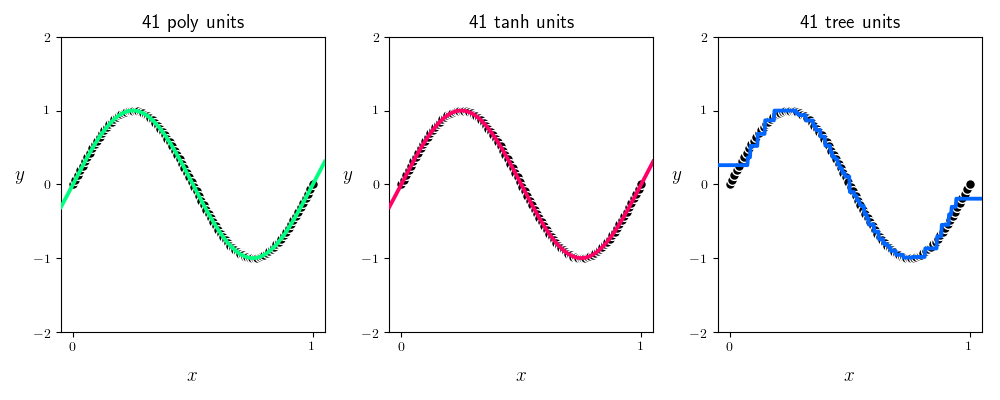
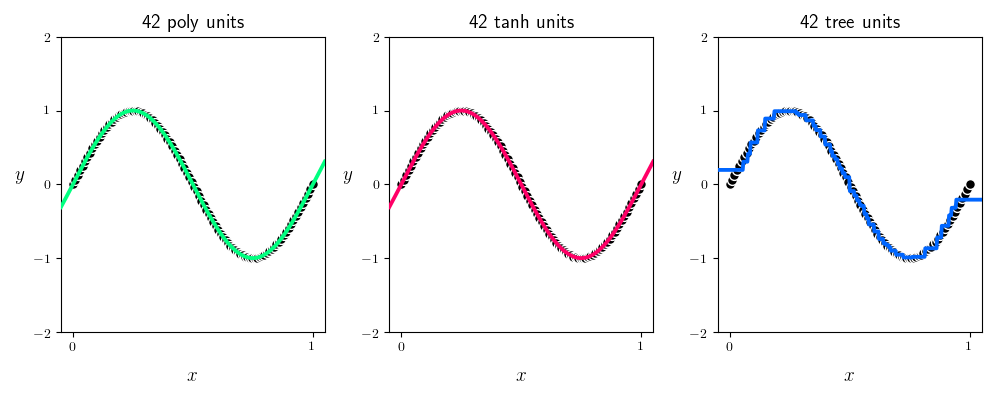
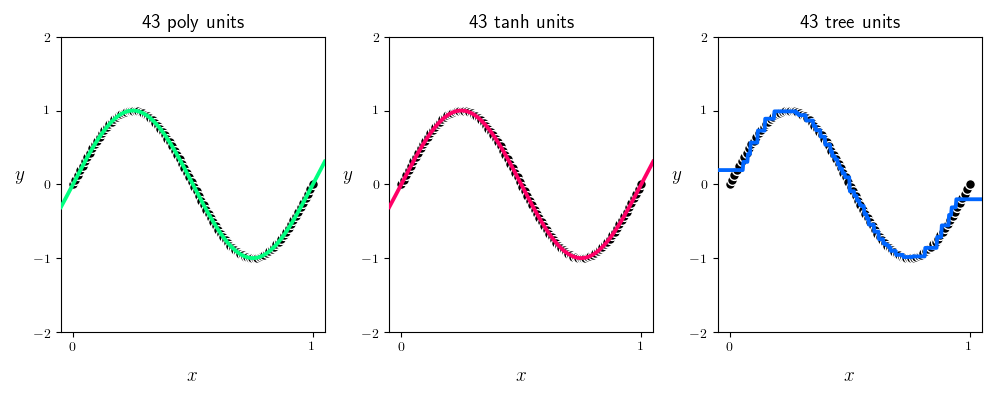
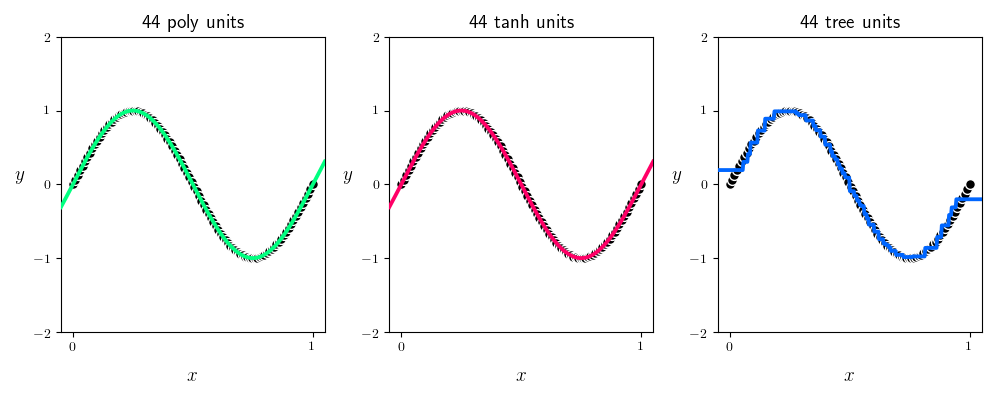
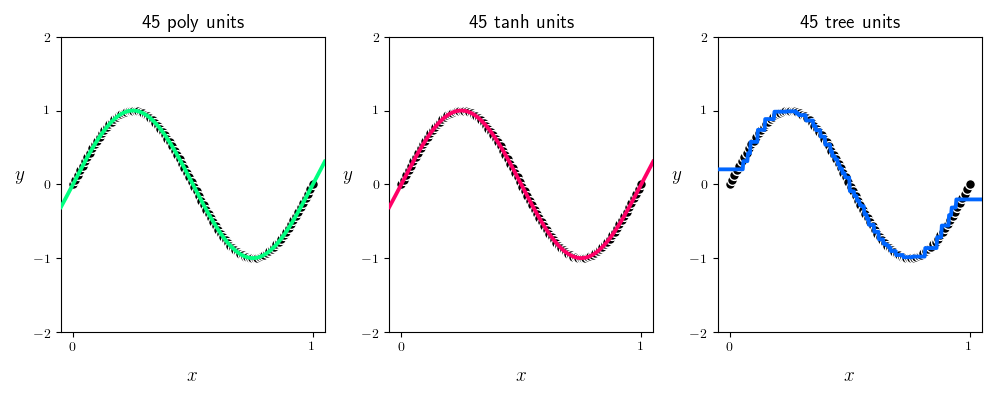
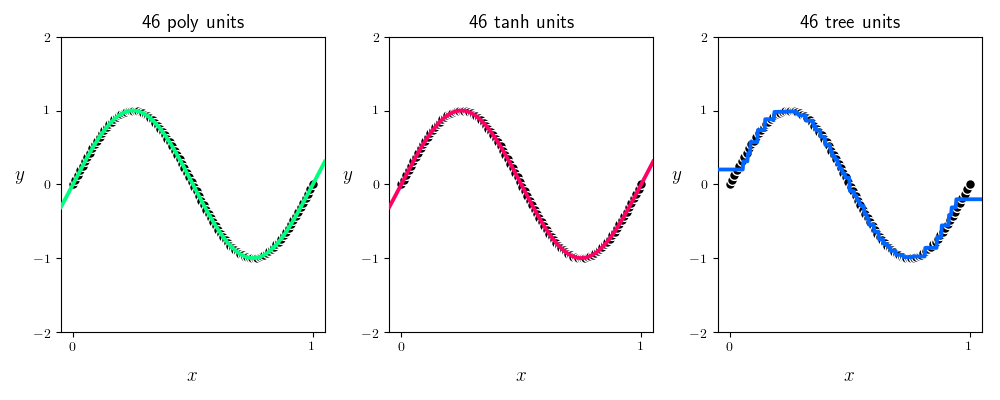
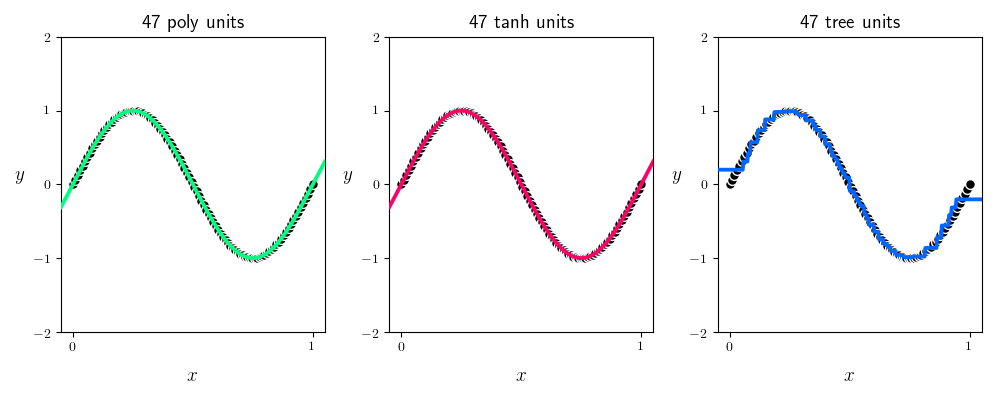
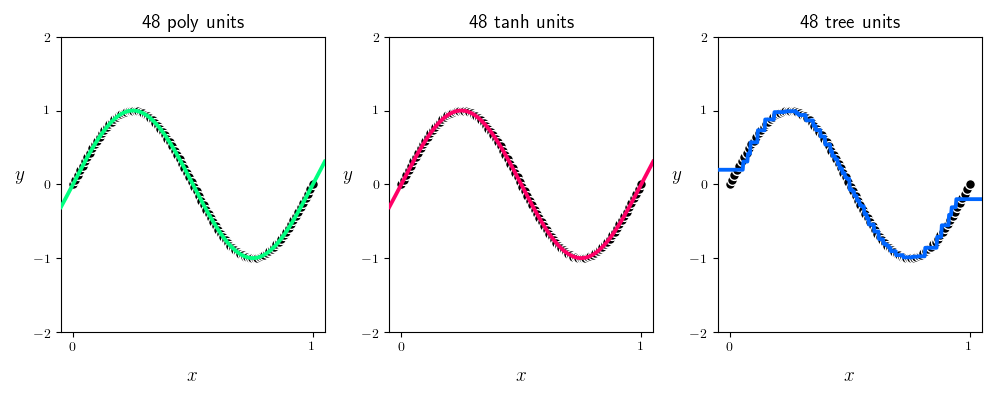
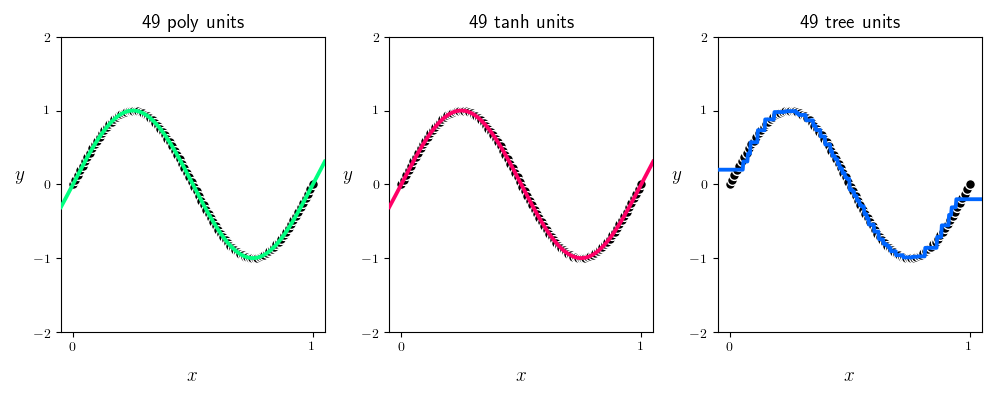

In [7]:
demo = nonlib.regression_basis_comparison_2d.Visualizer()
csvname = datapath + 'sin_function.csv'
demo.load_data(csvname)
demo.brows_fits(num_elements = [v for v in range(1,50,1)])

- With real data however more elements $\neq$ better fit


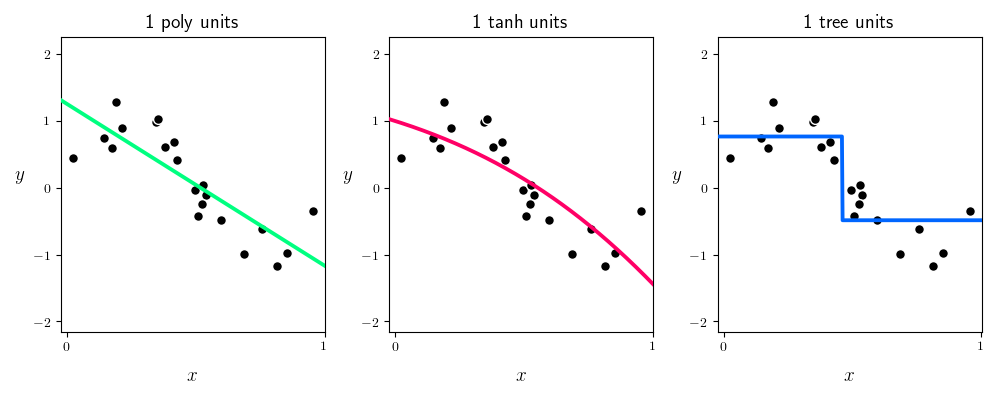
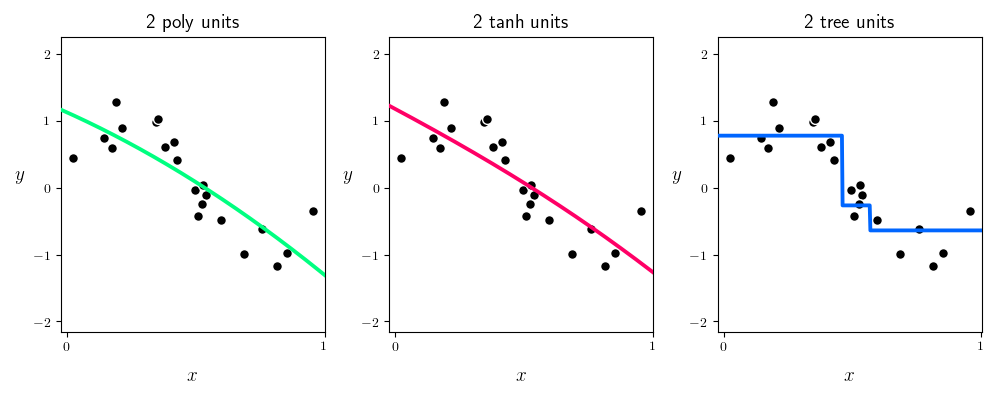
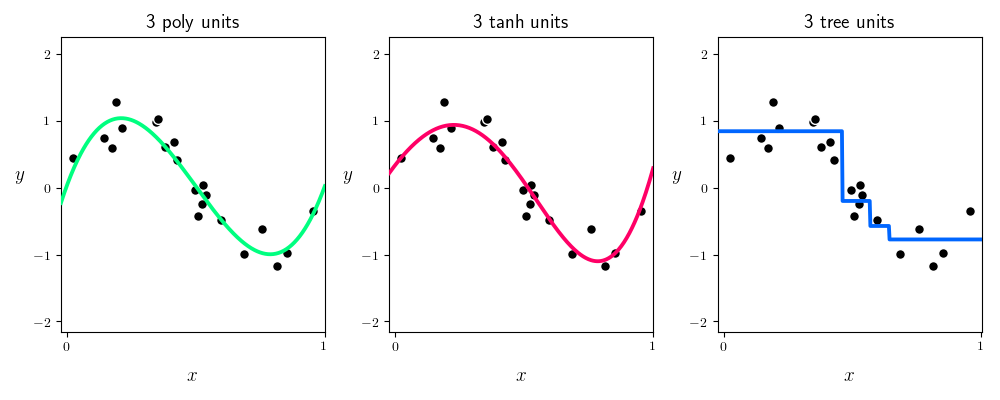
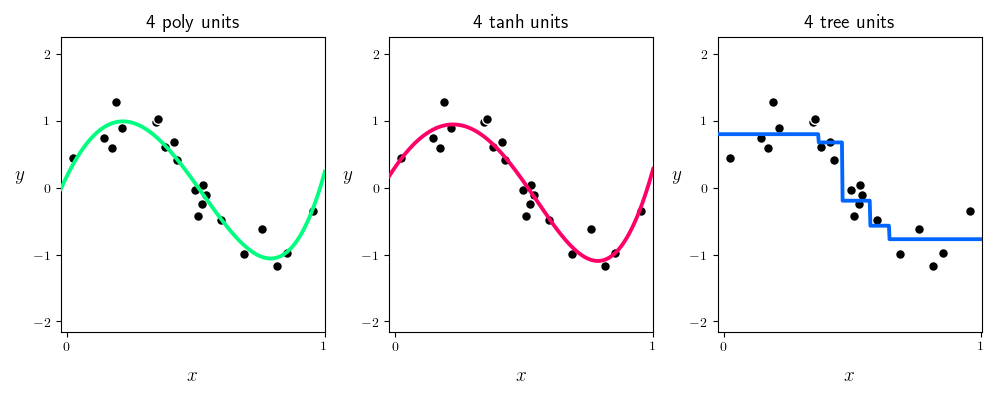
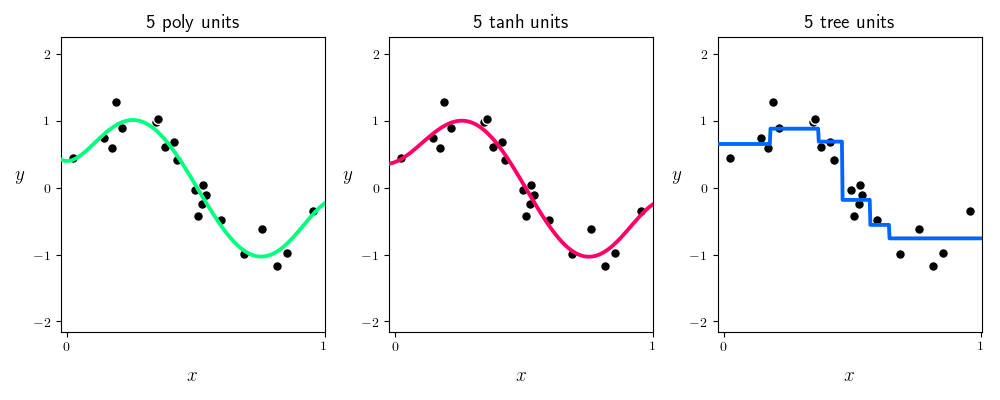
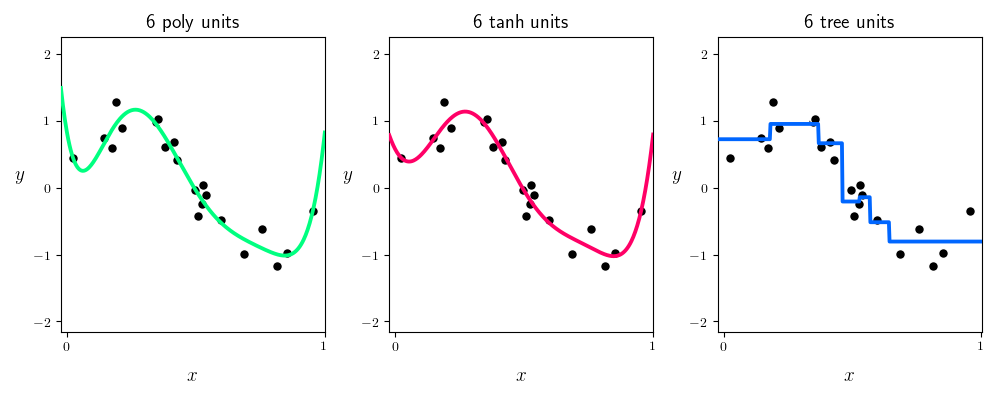
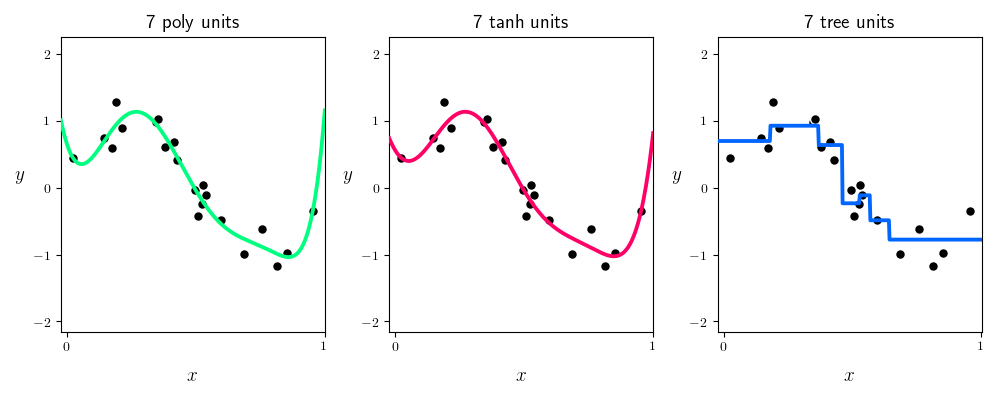
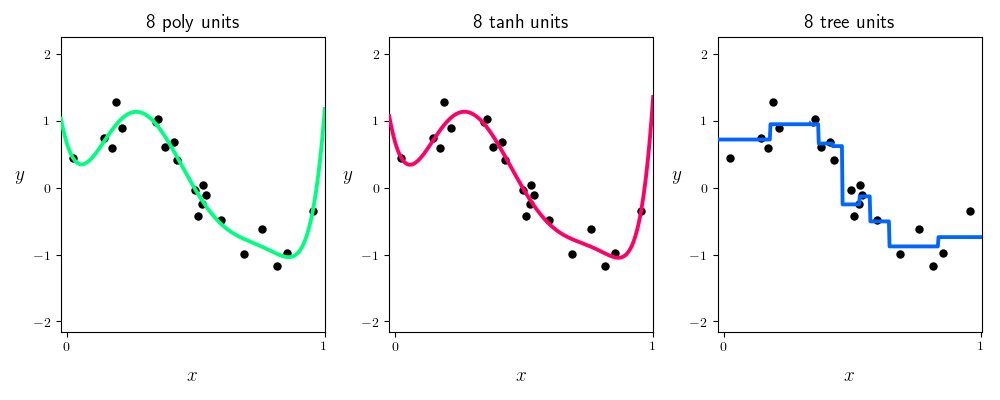
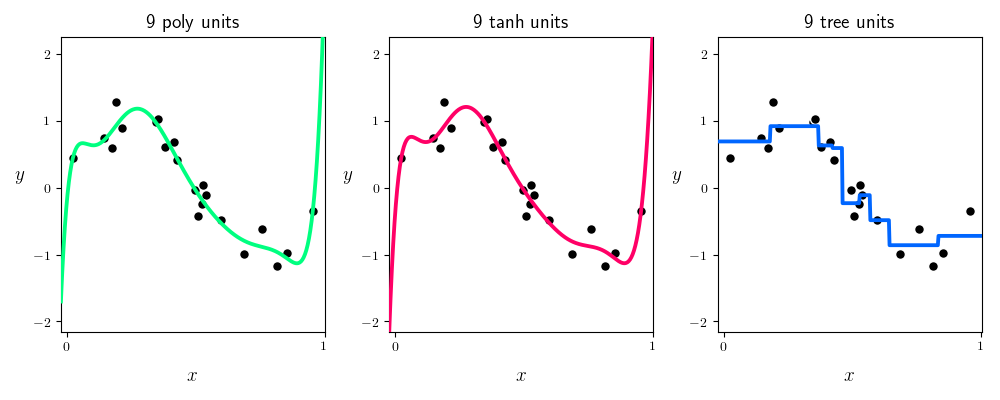
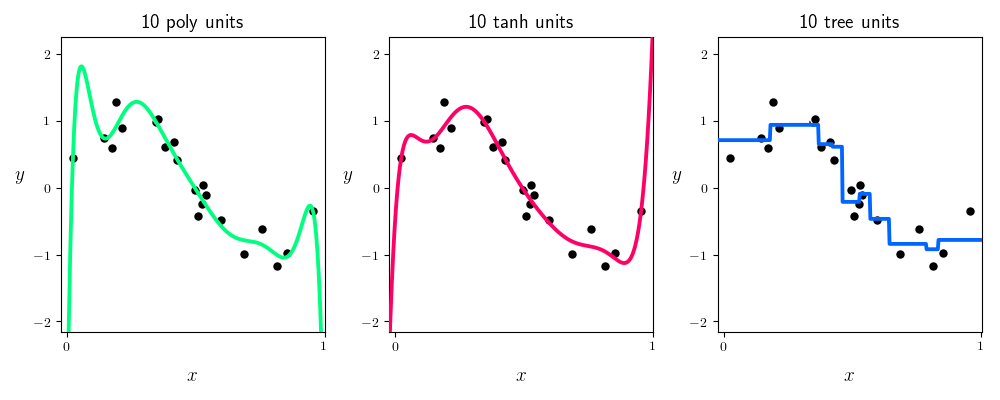
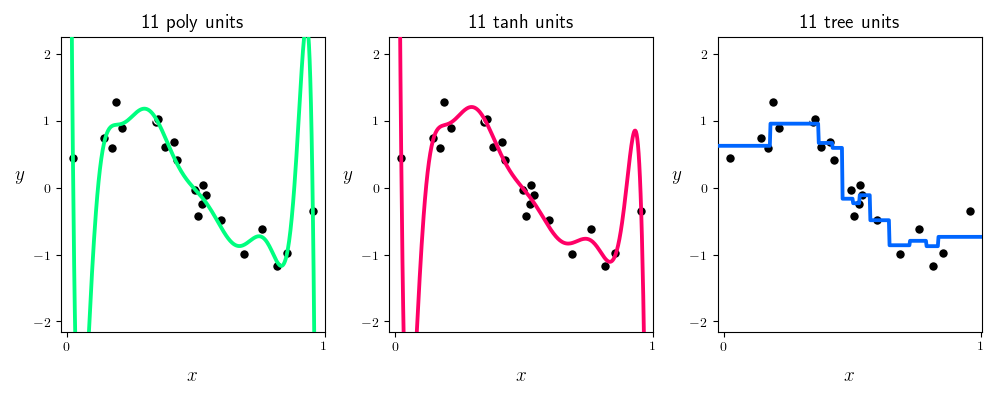
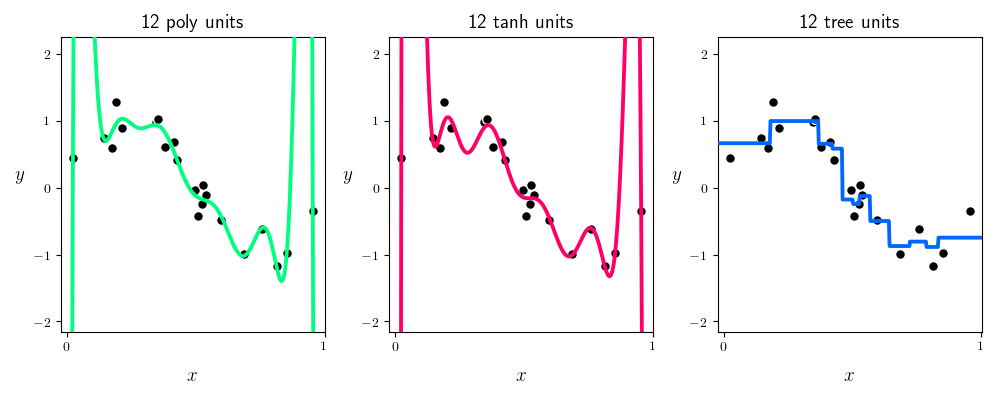
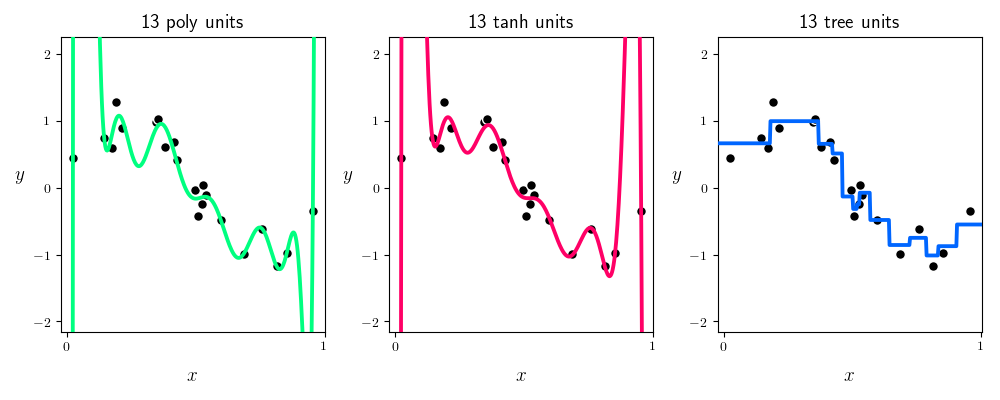
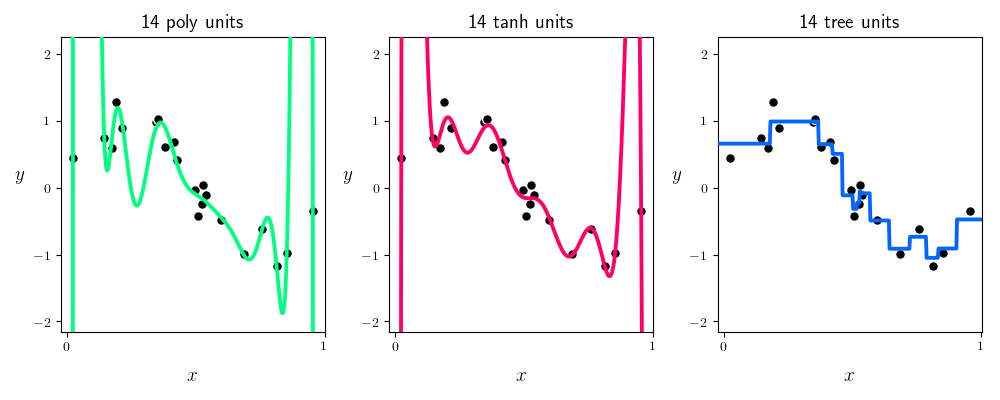
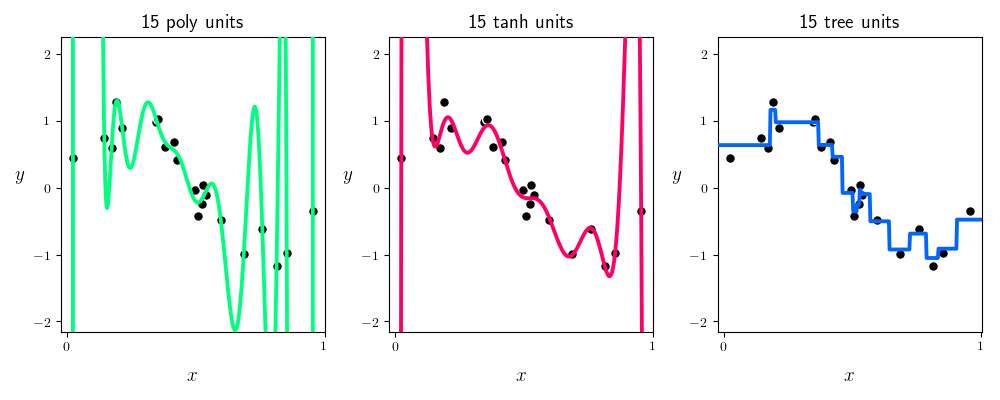
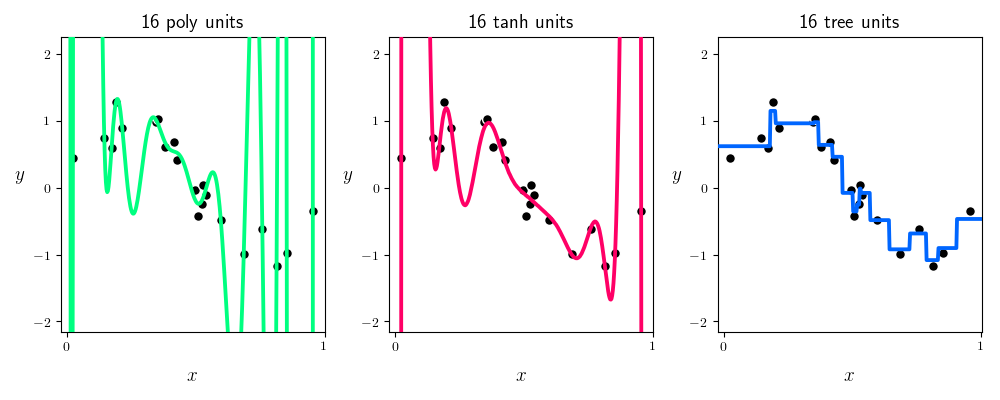
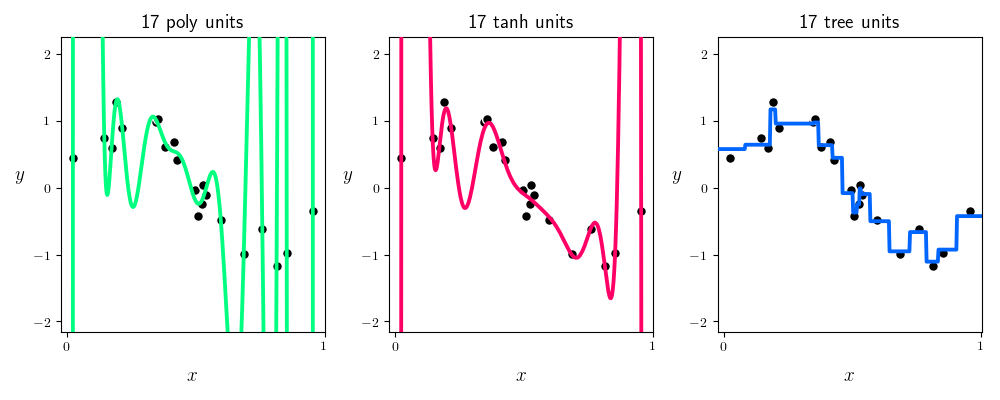
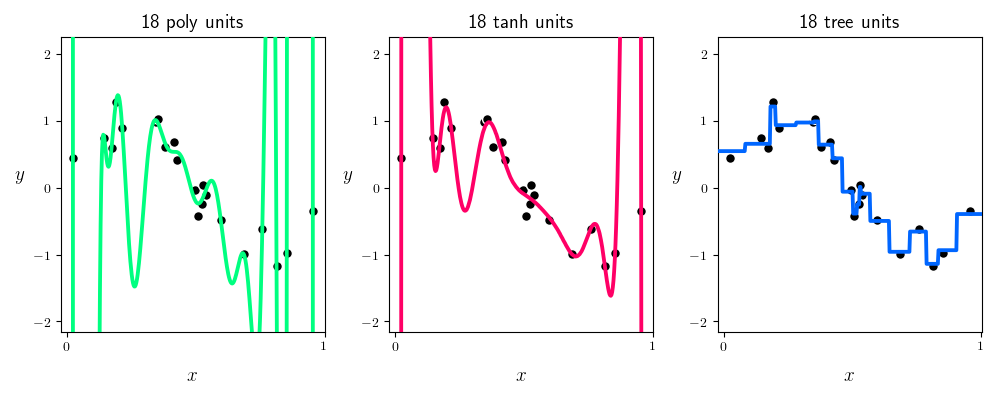
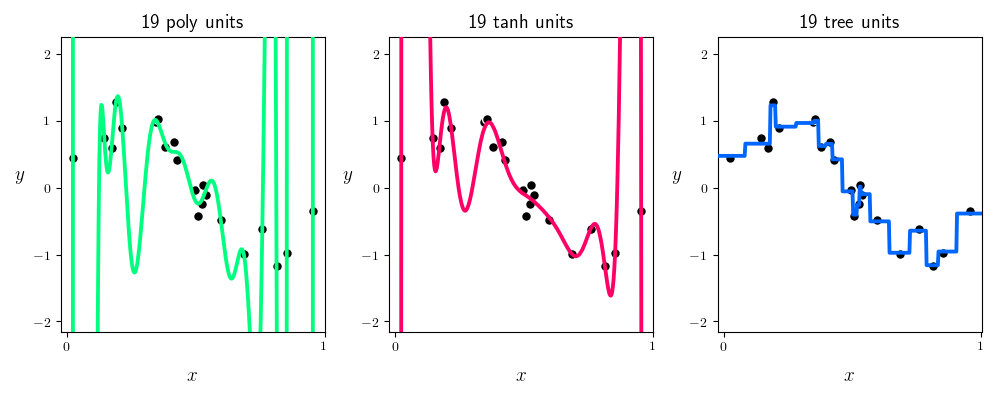
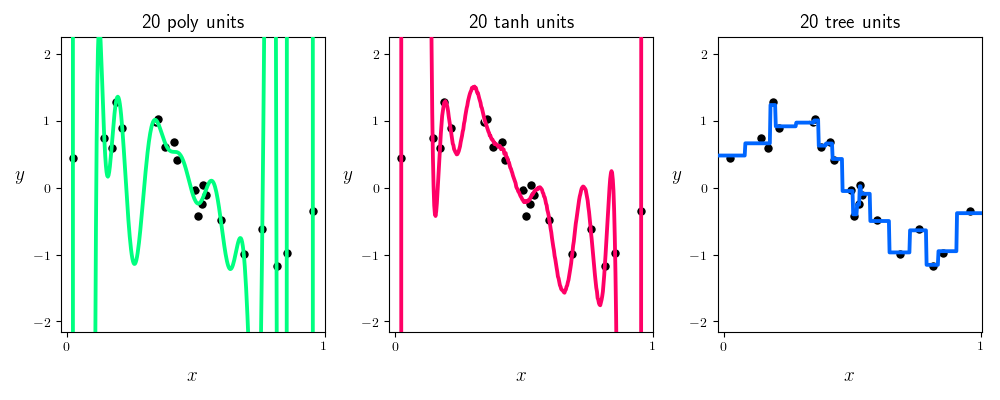
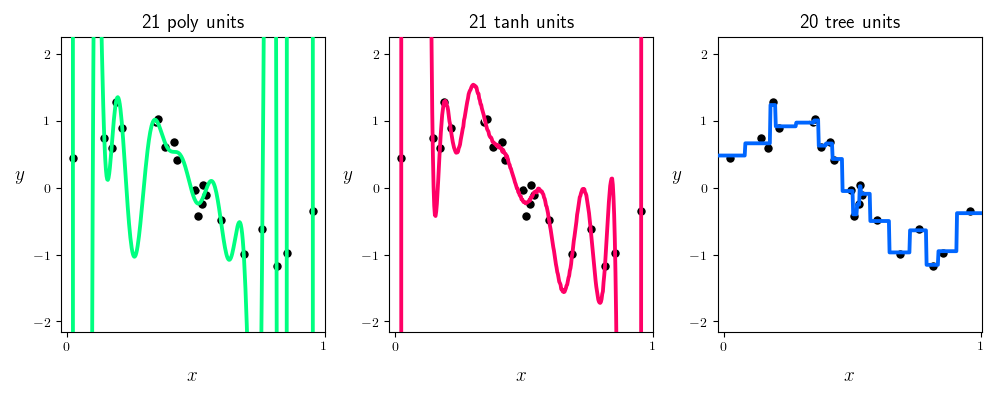
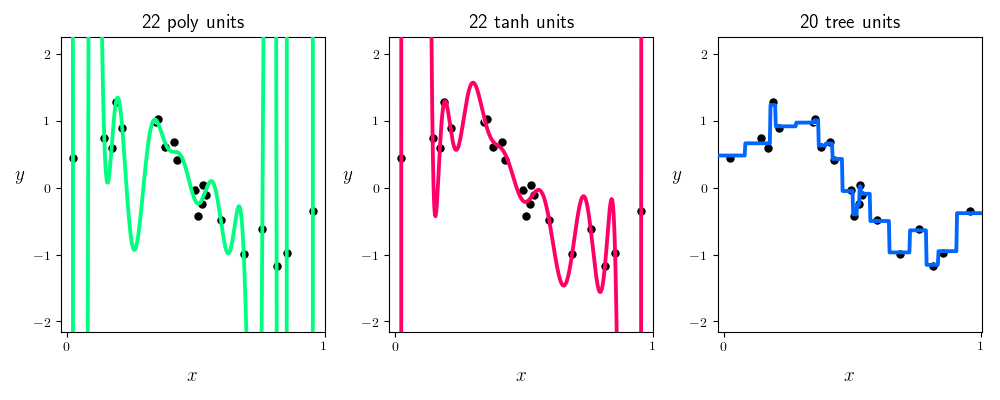
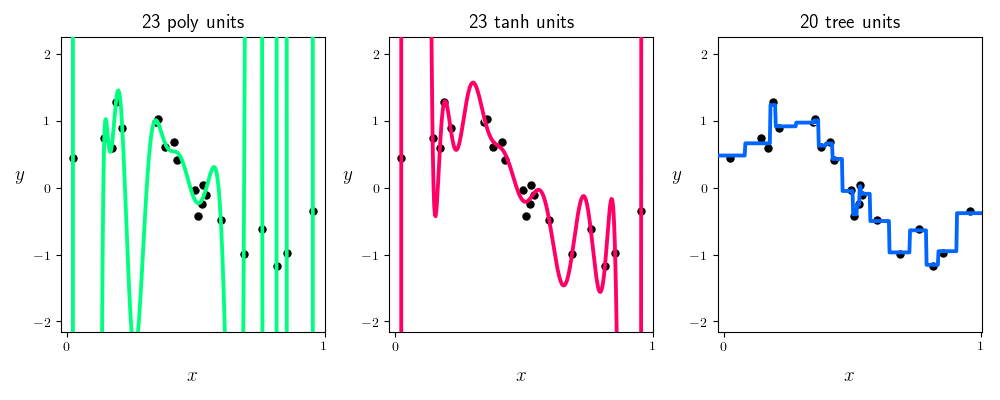
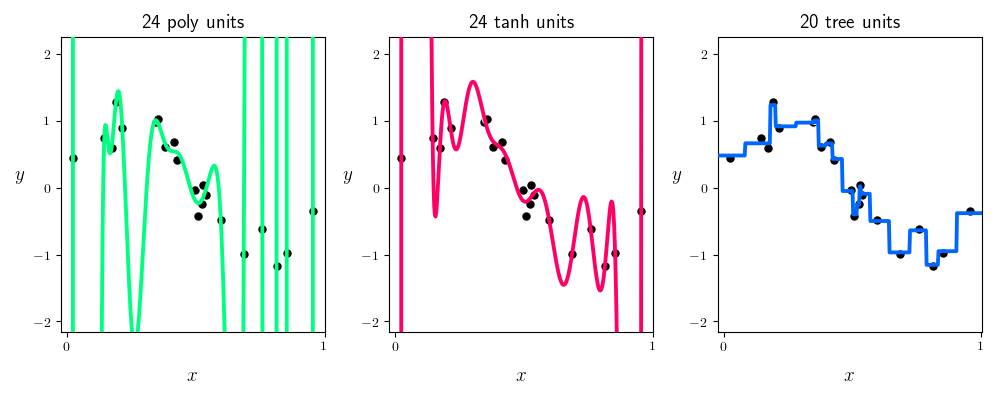

In [5]:
demo = nonlib.regression_basis_comparison_2d.Visualizer()
csvname = datapath + 'noisy_sin_sample.csv'
demo.load_data(csvname)
demo.brows_fits(num_elements = [v for v in range(1,25)])

- Nothing has 'gone wrong' here - we just do not know ahead of time how many elements is 'too little' and how many is 'too much' (in terms of nonlinearity)

- i.e., error on training set always goes down as we add elements (provided we optimize correctly)


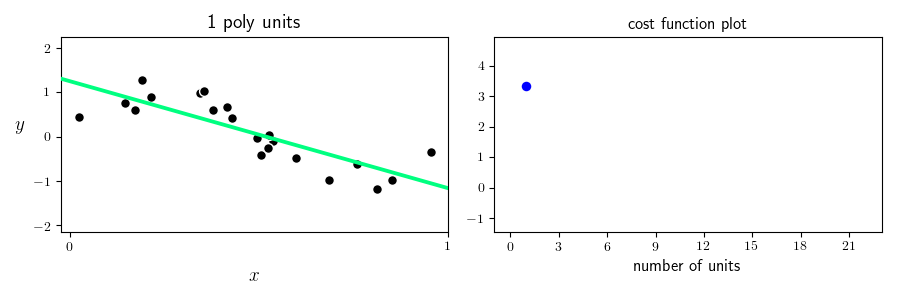
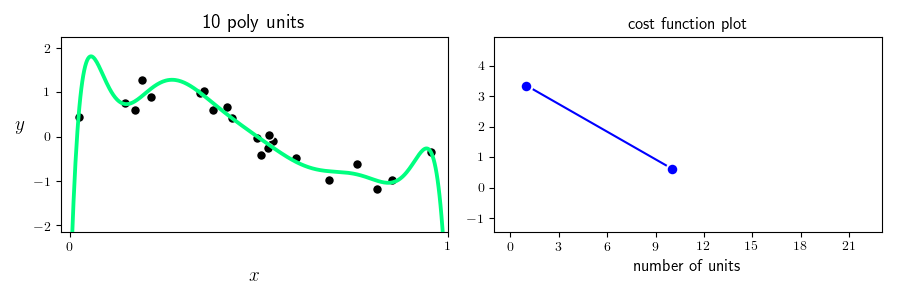
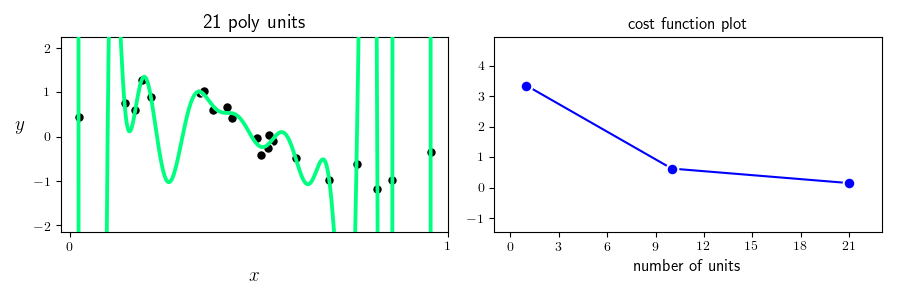

In [25]:
demo = nonlib.regression_basis_single.Visualizer()
csvname = datapath + 'noisy_sin_sample.csv'
demo.load_data(csvname)
demo.brows_single_fit(basis='poly',num_elements = [v for v in range(1,25)])

- When fit is not nonlinear enough / we use too few basis features --> call this *underfitting*

- When fit is too nonlinear / we use too many basis features --> call this *overfitting*

- The way of finding best combination of elements to use called *cross-validation*